# Preparations   

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
#import plotly.graph_objects as go

In [2]:
from pyecharts.charts import Page,Sankey
from pyecharts import options as opts 

In [3]:
from chord import Chord

In [4]:
pd.set_option('display.max_columns',80) #pd.set_option('display.max_rows',50)
pd.set_option('max_colwidth',200) #pd.set_option('expand_frame_repr', False) #禁止自动换行(设置为Flase不自动换行，True反之)
#pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places

#unconstrained gravity model
import statsmodels.api as sm   
import statsmodels.formula.api as smf   
import scipy.stats  

def CalcRSqaured(observed, estimated):
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    return R2


from math import sqrt
def CalcRMSE(observed, estimated):
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    return RMSE

In [5]:
f2015 = pd.read_csv("f2015.csv") 
f2016 = pd.read_csv("f2016.csv")
f2017 = pd.read_csv("f2017.csv")
f2018 = pd.read_csv("f2018.csv")
f2019 = pd.read_csv("f2019.csv")
f2019.sample(n=3)

,月份,城市1,城市2,迁入迁出,类型,人数
50417,2,德阳,乐山,in,bus,1936
128842,4,淮南,上海,out,air,665
170245,5,荆门,深圳,in,train,5609


In [6]:
for i in f2015,f2016,f2017,f2018,f2019:
    i.rename(columns={'月份':'DateTime', '城市1':'Orig', '城市2':'Dest', '迁入迁出':'Direction', '类型':'Type','人数':'Flow'} ,inplace= True)
f2019.sample(n=3)

,DateTime,Orig,Dest,Direction,Type,Flow
39362,2,临沂,温州,out,air,14
194356,6,晋城,东莞,in,air,5
140686,4,阜新,四平,in,bus,30


In [7]:
### FLOW Within Guangdong province and HONGKONG AND MACAO

csvlist = [f2015,f2016,f2017,f2018,f2019]
dictx = {'广州(.*)':'Guangzhou','深圳(.*)':'Shenzhen','珠海(.*)':'Zhuhai','汕头(.*)':'Shantou',
        '佛山(.*)':'Foshan','韶关(.*)':'Shaoguan','河源(.*)':'Heyuan','梅州(.*)':'Meizhou',
        '惠州(.*)':'Huizhou','汕尾(.*)':'Shanwei','东莞(.*)':'Dongguan','中山(.*)':'Zhongshan',
        '江门(.*)':'Jiangmen','阳江(.*)':'Yangjiang','湛江(.*)':'Zhanjiang','茂名(.*)':'Maoming',
        '肇庆(.*)':'Zhaoqing','清远(.*)':'Qingyuan','潮州(.*)':'Chaozhou','揭阳(.*)':'Jieyang',
        '云浮(.*)':'Yunfu','澳门(.*)':'Macau','香港(.*)':'Hongkong'}
for n in range(5):
    x = csvlist[n]
    print(str(2015+n)+'s original value:',len(x))

    #1DROP NULL
    x = x[x.Flow != 0]
    
    #2EXTRACT FLOW WITH IN THE CHOSEN CITIES
    x = x[x.Orig.str.contains("广州|深圳|珠海|汕头|佛山|韶关|河源|梅州|惠州|汕尾|东莞|中山|江门|阳江|湛江|茂名|肇庆|清远|潮州|揭阳|云浮|澳门|香港")
      & x.Dest.str.contains("广州|深圳|珠海|汕头|佛山|韶关|河源|梅州|惠州|汕尾|东莞|中山|江门|阳江|湛江|茂名|肇庆|清远|潮州|揭阳|云浮|澳门|香港")]
    print('1 counts after extracting cities in GD province,and HK and MC:',len(x)) #1取大湾区并删除空值后数量

    #3CHANGING THE NAMES INTO ENGLISH
    x.replace({'Orig':dictx,'Dest':dictx} ,inplace = True ,regex = True)
    
    #4CHANGE THE DATA TYPE OF DATE  
    x['DateTime']=(x['DateTime'] +(2015+n)*100)
    x['DateTime'] = pd.to_datetime(x['DateTime'] , format = "%Y%m") 
    
    #5DROP DUPLICATED DATA(keep =  first， maybe groupby().agg(sum)) !!!! ，最好是不变 
    x.drop_duplicates(subset=['DateTime', 'Orig', 'Dest','Direction', 'Type'],keep ='first', inplace = True) 
    print('2 counts after dropping duplicates:',len(x))# 不变就对了 #2尝试去重后数量

    #6UNIFYING THE DIRECTION OF FLOW
    x.loc[x['Direction'] =='in',['Orig', 'Dest']] = x.loc[x['Direction'] == 'in',['Dest', 'Orig']].values
    #df.a, df.b = np.where(df.a > df.b, [df.b, df.a], [df.a, df.b])  !!!!
    x.drop(columns = ['Direction'] ,inplace = True)
    
    #7DROP DUPLICATED DATA(keep =  first， maybe groupby().agg(sum)) !!!!  
    x.drop_duplicates(subset=['DateTime', 'Orig', 'Dest', 'Type'],keep ='first', inplace = True) 
    print('3 counts after redropping duplicates after unifying directions :',len(x),'\n\n') #3再按照数值外值去重后数量
    csvlist[n] = x

f15,f16,f17,f18,f19 = csvlist
del f2015,f2016,f2017,f2018,f2019,csvlist,dictx
# display(f15.info(),f15.sample(n=20))

2015s original value: 516246
1 counts after extracting cities in GD province,and HK and MC: 10600
2 counts after dropping duplicates: 10417
3 counts after redropping duplicates after unifying directions : 6640 


2016s original value: 534121
1 counts after extracting cities in GD province,and HK and MC: 10843
2 counts after dropping duplicates: 10843
3 counts after redropping duplicates after unifying directions : 7018 


2017s original value: 540526
1 counts after extracting cities in GD province,and HK and MC: 10969
2 counts after dropping duplicates: 10969
3 counts after redropping duplicates after unifying directions : 7205 


2018s original value: 555143
1 counts after extracting cities in GD province,and HK and MC: 10908
2 counts after dropping duplicates: 10908
3 counts after redropping duplicates after unifying directions : 7178 


2019s original value: 275583
1 counts after extracting cities in GD province,and HK and MC: 7163
2 counts after dropping duplicates: 7163
3 counts a

In [8]:
f2015 = pd.read_csv("f2015.csv") # index_col
f2016 = pd.read_csv("f2016.csv")
f2017 = pd.read_csv("f2017.csv")
f2018 = pd.read_csv("f2018.csv")
f2019 = pd.read_csv("f2019.csv")
for i in f2015,f2016,f2017,f2018,f2019:
    i.rename(columns={'月份':'DateTime', '城市1':'Orig', '城市2':'Dest', '迁入迁出':'Direction', '类型':'Type','人数':'Flow'} ,inplace= True)

In [9]:
### FLOW Related to Guangdong province and HONGKONG AND MACAO
csvlist = [f2015,f2016,f2017,f2018,f2019]
dictx = {'广州(.*)':'Guangzhou','深圳(.*)':'Shenzhen','珠海(.*)':'Zhuhai','汕头(.*)':'Shantou',
        '佛山(.*)':'Foshan','韶关(.*)':'Shaoguan','河源(.*)':'Heyuan','梅州(.*)':'Meizhou',
        '惠州(.*)':'Huizhou','汕尾(.*)':'Shanwei','东莞(.*)':'Dongguan','中山(.*)':'Zhongshan',
        '江门(.*)':'Jiangmen','阳江(.*)':'Yangjiang','湛江(.*)':'Zhanjiang','茂名(.*)':'Maoming',
        '肇庆(.*)':'Zhaoqing','清远(.*)':'Qingyuan','潮州(.*)':'Chaozhou','揭阳(.*)':'Jieyang',
        '云浮(.*)':'Yunfu','澳门(.*)':'Macau','香港(.*)':'Hongkong'}
for n in range(5):
    x = csvlist[n]
    print(str(2015+n)+'s original value:',len(x))

    #1DROP NULL
    x = x[x['Flow'] != 0]
    
    #2EXTRACT FLOW WITH IN THE CHOSEN CITIES
    x = x[x.Orig.str.contains("广州|深圳|珠海|汕头|佛山|韶关|河源|梅州|惠州|汕尾|东莞|中山|江门|阳江|湛江|茂名|肇庆|清远|潮州|揭阳|云浮|澳门|香港")
        | x.Dest.str.contains("广州|深圳|珠海|汕头|佛山|韶关|河源|梅州|惠州|汕尾|东莞|中山|江门|阳江|湛江|茂名|肇庆|清远|潮州|揭阳|云浮|澳门|香港")]
    print('1 counts after extracting cities in GD province,and HK and MC:',len(x))

    #3CHANGING THE NAMES INTO ENGLISH
    x.replace({'Orig':dictx,'Dest':dictx} ,inplace = True ,regex = True)
    
    #4CHANGE THE DATA TYPE OF DATE    
    x['DateTime']=(x['DateTime'] +(2015+n)*100)
    x['DateTime'] = pd.to_datetime(x['DateTime'] , format = "%Y%m") 
    
    #5DROP DUPLICATED DATA(keep =  first， maybe groupby().agg(sum))
    x.drop_duplicates(subset=['DateTime', 'Orig', 'Dest','Direction', 'Type'],keep ='first', inplace = True) 
    print('2 counts after dropping duplicates:',len(x))# 不变就对了

    #6UNIFYING THE DIRECTION OF FLOW
    x.loc[x['Direction'] =='in',['Orig', 'Dest']] = x.loc[x['Direction'] == 'in',['Dest', 'Orig']].values
    #df.a, df.b = np.where(df.a > df.b, [df.b, df.a], [df.a, df.b])  !!!!
    x.drop(columns = ['Direction'] ,inplace = True)
    
    #7DROP DUPLICATED DATA(keep =  first， maybe groupby().agg(sum)) !!!!  
    x.drop_duplicates(subset=['DateTime', 'Orig', 'Dest', 'Type'],keep ='first', inplace = True) 
    print('3 counts after redropping duplicates after unifying directions:',len(x),'\n\n')
    csvlist[n] = x

g15,g16,g17,g18,g19 = csvlist
del f2015,f2016,f2017,f2018,f2019,csvlist,dictx

2015s original value: 516246
1 counts after extracting cities in GD province,and HK and MC: 77450
2 counts after dropping duplicates: 76540
3 counts after redropping duplicates after unifying directions: 72718 


2016s original value: 534121
1 counts after extracting cities in GD province,and HK and MC: 78499
2 counts after dropping duplicates: 78499
3 counts after redropping duplicates after unifying directions: 74672 


2017s original value: 540526
1 counts after extracting cities in GD province,and HK and MC: 74523
2 counts after dropping duplicates: 74523
3 counts after redropping duplicates after unifying directions: 70755 


2018s original value: 555143
1 counts after extracting cities in GD province,and HK and MC: 74278
2 counts after dropping duplicates: 74278
3 counts after redropping duplicates after unifying directions: 67175 


2019s original value: 275583
1 counts after extracting cities in GD province,and HK and MC: 43594
2 counts after dropping duplicates: 43594
3 counts

In [10]:
# Concatenate all the years 
ff = pd.concat([f15,f16,f17,f18,f19], ignore_index=True)  #all years other places excluded
gg = pd.concat([g15,g16,g17,g18,g19], ignore_index=True)  #all years other places included
display(len(ff),len(gg) ) #
display(ff.sample(n=10),gg.sample(n=10)) #

32773

324227

,DateTime,Orig,Dest,Type,Flow
21827,2018-02-01,Shantou,Zhaoqing,bus,1398
1253,2015-03-01,Jiangmen,Dongguan,bus,85204
11691,2016-09-01,Shenzhen,Zhuhai,bus,87809
13369,2016-12-01,Shanwei,Shantou,train,19138
12903,2016-11-01,Zhuhai,Qingyuan,train,4570
631,2015-02-01,Huizhou,Dongguan,bus,638212
30929,2019-05-01,Shenzhen,Heyuan,bus,121974
17604,2017-07-01,Shantou,Meizhou,bus,30678
30631,2019-05-01,Jiangmen,Yunfu,bus,42748
19544,2017-10-01,Shenzhen,Heyuan,bus,125295


,DateTime,Orig,Dest,Type,Flow
320835,2019-08-01,安顺,Shenzhen,air,36
107781,2016-06-01,哈尔滨,Zhanjiang,air,273
54970,2015-09-01,Zhongshan,贵港市,bus,36018
204945,2017-10-01,Dongguan,绍兴市,air,55
84652,2016-03-01,Zhuhai,三亚市,air,2117
209209,2017-11-01,Meizhou,长春,air,18
280729,2018-12-01,Guangzhou,天津,air,11502
174005,2017-05-01,Huizhou,Meizhou,train,18505
32772,2015-06-01,吉安市,Dongguan,train,41400
233993,2018-03-01,贵港,Shenzhen,air,501


# plotting overall trend    

In [11]:
ff_bus = ff[ff.Type == 'bus']  
ff_train = ff[ff.Type == 'train'] 
ff_air = ff[ff.Type == 'air']  

# ffsum_alltype = pd.DataFrame(ff['Flow'].groupby(ff['DateTime']).sum())

ff_bustrend = pd.DataFrame(ff_bus['Flow'].groupby(ff_bus['DateTime']).sum())
ff_traintrend = pd.DataFrame(ff_train['Flow'].groupby(ff_train['DateTime']).sum())
ff_airtrend = pd.DataFrame(ff_air['Flow'].groupby(ff_air['DateTime']).sum())

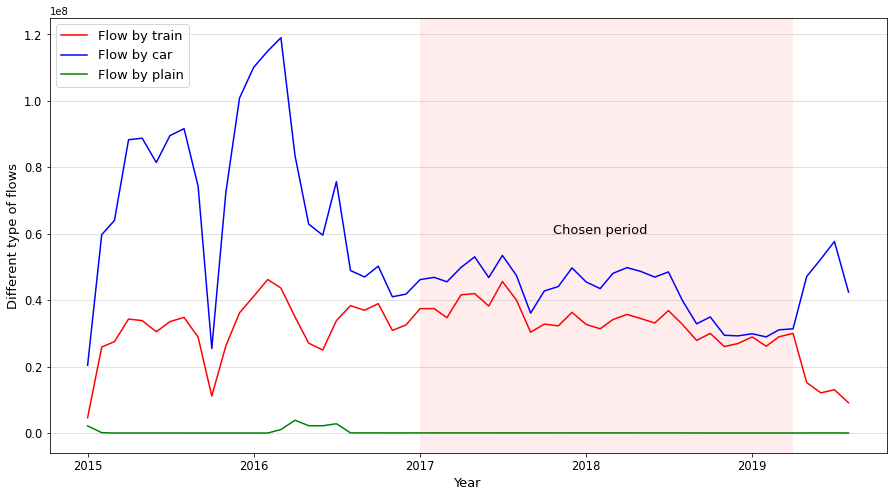

In [12]:
#xy=(mdates.date2num(datetime.datetime(2020,05,14)), 50)
#axes.set_xticklabels()函数：设置主刻度的标签。
#axes.Axis.set_minor_locator()函数：设置坐标轴最小刻度。参数是一个Locator类。示例如下：

fig = plt.figure(figsize=(15,8))#
t1 = 'Chosen period'
x1 = ff_traintrend.index
x2 = ff_airtrend.index
y1,y2,y3 =  ff_traintrend.Flow , ff_bustrend.Flow ,  ff_airtrend.Flow
# display(len(x),len(y1),len(y2),len(y3))
plt.plot(x1,y1, color="r",label='Flow by train')#,linewidth= 1.8)
plt.plot(x1,y2, color="b",label='Flow by car')#,linewidth= 1.8)
plt.plot(x2,y3, color="g",label='Flow by plain')#,linewidth= 1.8)
plt.grid(color='grey',alpha=0.3, axis = 'y' )
plt.legend(loc='best',fontsize=13)
plt.xlabel('Year',fontsize=13)
plt.ylabel('Different type of flows',fontsize=13)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.axvspan('2017-01-01','2019-04-01', facecolor='red', alpha=0.07)
plt.text(mdates.date2num(x1[37]), 60000000,t1, rotation=0,  wrap=True , ha='center',fontsize=13)
#plt.suptitle('Overall Trend - Only flow within cities in GD province, HK and MC',) #fontsize=13
plt.savefig('./pics/1Overall_trend.jpg', dpi=150, bbox_inches='tight')
plt.show()



# fig = plt.figure(figsize=(15,8))
# x1 = gg_traintrend.index
# x2 = gg_airtrend.index
# y1,y2,y3 =  gg_traintrend.Flow , gg_bustrend.Flow ,  gg_airtrend.Flow

# # display(len(x),len(y1),len(y2),len(y3))

# plt.plot(x1,y1, color="#c00000",label='Train',linewidth= 1.8)
# plt.plot(x1,y2, color="#558ed5",label='Bus',linewidth= 1.8)
# plt.plot(x2,y3, color="#e46c0a",label='Air',linewidth= 1.8)
# plt.grid(color='grey',alpha=0.3, axis = 'y' )
# plt.legend(loc=1)
# plt.xlabel('Time')
# plt.ylabel('Flow')
# # plt.suptitle('Overall Trend - All flow related to cities in GD province, HK and MC',) #fontsize=14
# plt.show()

In [13]:
gg_bus = gg[gg.Type == 'bus']
gg_train = gg[gg.Type == 'train']
gg_air = gg[gg.Type == 'air']

#ggsum_alltype = pd.DataFrame(gg['Flow'].groupby(gg['DateTime']).sum())

gg_bustrend = pd.DataFrame(gg_bus['Flow'].groupby(gg_bus['DateTime']).sum())
gg_traintrend = pd.DataFrame(gg_train['Flow'].groupby(gg_train['DateTime']).sum())
gg_airtrend = pd.DataFrame(gg_air['Flow'].groupby(gg_air['DateTime']).sum())

In [14]:
ff_bus['DateTime'].sample(n = 5)

25439   2018-08-01
16000   2017-04-01
10984   2016-08-01
1611    2015-03-01
23094   2018-04-01
Name: DateTime, dtype: datetime64[ns]

In [15]:
ff_bus1719 = ff_bus[(ff_bus['DateTime'] >= '2017-01-01')& (ff_bus['DateTime'] < '2019-05-01')] # 
ff_train1719 = ff_train[(ff_train['DateTime'] >= '2017-01-01')& (ff_train['DateTime'] < '2019-05-01')] #  
print(ff_bus1719.count(),'\n',ff_train1719.count())

DateTime    7721
Orig        7721
Dest        7721
Type        7721
Flow        7721
dtype: int64 
 DateTime    7779
Orig        7779
Dest        7779
Type        7779
Flow        7779
dtype: int64


# Drawing and extracting pivot_tables    

In [16]:
ff_bus_pivot = pd.pivot_table(ff_bus1719, values ="Flow", index="Orig", columns = "Dest",aggfunc=np.sum, margins=False)
#ff_bus_pivot

In [17]:
ff_train_pivot = pd.pivot_table(ff_train1719, values ="Flow", index="Orig", columns = "Dest",aggfunc=np.sum, margins=False)
#ff_train_pivot

# Merging data    

In [18]:
car_duration = pd.read_excel('car_duration.xlsx')
train_duration = pd.read_excel('train_duration_n.xlsx')
train_duration_st = pd.read_excel('train_duration_st.xlsx')
train_duration_lt = pd.read_excel('train_duration_lt.xlsx')
statistics = pd.read_excel('statistics.xlsx')

In [19]:
display(car_duration.head(3), train_duration.head(3),train_duration_st.head(3), train_duration_lt.head(3),statistics.head(3))

,Unnamed: 0,Guangzhou,Shenzhen,Zhuhai,Shantou,Foshan,Shaoguan,Heyuan,Meizhou,Huizhou,Shanwei,Dongguan,Zhongshan,Jiangmen,Yangjiang,Zhanjiang,Maoming,Zhaoqing,Qingyuan,Chaozhou,Jieyang,Yunfu,Macau,Hongkong
0,Guangzhou,0.000000,106.300000,113.600000,290.416667,40.133333,166.300000,147.250000,265.366667,125.300000,200.516667,65.900000,86.983333,80.233333,166.400000,304.350000,244.200000,87.733333,71.183333,293.350000,267.233333,112.95,122.233333,145.566667
1,Shenzhen,103.000000,0.000000,119.516667,246.300000,109.366667,241.750000,139.266667,237.700000,85.133333,133.933333,69.050000,100.883333,113.450000,215.183333,349.766667,291.366667,162.466667,153.450000,264.000000,236.533333,188.90,141.716667,63.233333
2,Zhuhai,114.583333,123.066667,0.000000,330.700000,106.783333,263.533333,209.066667,308.850000,154.500000,229.366667,104.816667,54.633333,79.666667,156.783333,304.933333,245.516667,141.700000,164.333333,327.383333,301.033333,166.70,24.933333,85.133333


,Unnamed: 0,Guangzhou,Shenzhen,Zhuhai,Shantou,Foshan,Shaoguan,Heyuan,Meizhou,Huizhou,Shanwei,Dongguan,Zhongshan,Jiangmen,Yangjiang,Zhanjiang,Maoming,Zhaoqing,Qingyuan,Chaozhou,Jieyang,Yunfu,Macau,Hongkong
0,Guangzhou,0,29,54,147,18,51,140,206,59,90,27,26,30,85,150,116,34,24,124,176,72,94,46
1,Shenzhen,29,0,113,114,54,85,138,171,22,47,35,86,91,145,225,188,68,58,87,141,118,153,19
2,Zhuhai,54,112,0,288,78,110,363,306,167,173,204,28,106,166,264,221,101,129,228,270,126,40,152


,Cities,Guangzhou,Shenzhen,Zhuhai,Shantou,Foshan,Shaoguan,Heyuan,Meizhou,Huizhou,Shanwei,Dongguan,Zhongshan,Jiangmen,Yangjiang,Zhanjiang,Maoming,Zhaoqing,Qingyuan,Chaozhou,Jieyang,Yunfu,Macau,Hongkong
0,Guangzhou,0.0,29.000000,54.000000,128.784734,18.0,51.0,61.165399,166.523714,38.260108,76.731955,27.000000,28.799082,30.000000,85.000000,131.123223,105.954019,34.000000,24.0,126.368548,135.275654,72.000000,94.000000,46.000000
1,Shenzhen,29.0,0.000000,55.603447,104.113318,54.0,85.0,50.315352,171.000000,27.410061,47.000000,35.000000,36.968092,91.000000,145.000000,225.000000,188.000000,68.000000,58.0,87.000000,141.000000,118.000000,95.603447,19.000000
2,Zhuhai,54.0,55.603447,0.000000,165.356134,78.0,110.0,97.736799,197.537584,74.831508,107.663987,62.002918,18.635355,35.998797,86.246782,264.000000,125.462991,78.431098,129.0,157.300579,171.976809,89.461735,40.000000,95.603447


,Cities,Guangzhou,Shenzhen,Zhuhai,Shantou,Foshan,Shaoguan,Heyuan,Meizhou,Huizhou,Shanwei,Dongguan,Zhongshan,Jiangmen,Yangjiang,Zhanjiang,Maoming,Zhaoqing,Qingyuan,Chaozhou,Jieyang,Yunfu,Macau,Hongkong
0,Guangzhou,0.0,29.000000,54.000000,128.784734,18.000000,51.0,61.165399,121.861877,38.260108,76.731955,27.000000,28.799082,30.000000,85.000000,131.123223,105.954019,34.00000,24.0,126.368548,135.275654,72.00000,94.000000,46.000000
1,Shenzhen,29.0,0.000000,45.680741,104.113318,54.000000,85.0,50.315352,106.975511,27.410061,47.000000,35.000000,27.045386,38.439937,88.687922,153.073335,127.904131,68.00000,58.0,87.000000,141.000000,118.00000,85.680741,19.000000
2,Zhuhai,54.0,45.680741,0.000000,149.794059,50.543912,110.0,95.996093,152.656252,73.090802,97.741281,62.002918,18.635355,21.108578,71.356563,135.741975,110.572772,62.33503,129.0,147.377873,157.758484,60.02847,40.000000,85.680741


,City,Car_From_Average,Car_To_Average_Time,Car_Average,Train_From_Average_Now,Train_To_Average_Now,Train_Average_Time_Now,Train_From_Average_ST,Train_To_Average_ST,Train_Average_Time_ST,Train_From_Average_LT,Train_To_Average_LT,Train_Average_Time_LT,Population,Labour_Force,GDP_Avg,GDP,Investment_in_Fixed_Assets,Foreign_Trade,RD_Investment,Housing_Price,Education,Car_Ownership,Highway_Length,Railway_Length_Now,Railway_Length_ST,Railway_Length_LT,Train_Average_Accessibility,Car_Average_Accessibility
0,Guangzhou,152.326087,151.651449,151.988768,78.173913,80.260870,79.217391,61.751047,61.924960,61.838004,60.086631,60.260544,60.173588,1530.59,1125.89,15.437576,23628.60,7462.123310,10003.51,6777377.5,31692,0.640276,1822.209736,5.879432,369.409827,537.759438,623.258648,75.915052,39.567347
1,Shenzhen,163.737681,165.745652,164.741667,95.086957,95.739130,95.413043,81.907343,82.820387,82.363865,64.341358,65.167445,64.754401,1343.88,1283.37,20.036826,26927.09,7374.709489,29780.61,13282828.5,54790,0.252999,2552.480132,0.547668,198.736617,220.065201,313.046736,63.047404,36.515016
2,Zhuhai,173.826812,173.335507,173.581159,160.260870,164.304348,162.282609,90.087577,89.522359,89.804968,74.407524,73.016220,73.711872,202.37,161.17,16.978258,3435.89,2128.427687,2908.54,1083104.9,21134,0.647329,3415.466719,7.229332,77.653960,96.441973,96.441973,5.138315,4.803857


In [20]:
#UNSTACK TRAVEL TIME
datax = []
for index, row in car_duration.iterrows():
#     print(index)
    for i in np.arange(23):
        datax.append([row[0],car_duration.columns[i+1],row[1+i]])
car_duration  = pd.DataFrame(datax,columns = ['Origin','Destination','Driving_Time'])

datax = []
for index, row in train_duration.iterrows():
#     print(index)
    for i in np.arange(23):
        datax.append([row[0],train_duration.columns[i+1],row[1+i]])
train_duration = pd.DataFrame(datax,columns = ['Origin','Destination','Train_Time'])

datax = []
for index, row in train_duration_st.iterrows():
#     print(index)
    for i in np.arange(23):
        datax.append([row[0],train_duration_st.columns[i+1],row[1+i]])
train_duration_st = pd.DataFrame(datax,columns = ['Origin','Destination','Train_Time_st'])

datax = []
for index, row in train_duration_lt.iterrows():
#     print(index)
    for i in np.arange(23):
        datax.append([row[0],train_duration_lt.columns[i+1],row[1+i]])
train_duration_lt = pd.DataFrame(datax,columns = ['Origin','Destination','Train_Time_lt'])

In [21]:
#display(car_duration.info(),train_duration.info(),train_duration_st.info(),train_duration_lt.info())

In [22]:
train_duration = train_duration.merge(train_duration_st, left_on = ['Origin','Destination'], right_on = ['Origin','Destination'])
train_duration = train_duration.merge(train_duration_lt, left_on = ['Origin','Destination'], right_on = ['Origin','Destination'])
train_duration

,Origin,Destination,Train_Time,Train_Time_st,Train_Time_lt
0,Guangzhou,Guangzhou,0,0.000000,0.000000
1,Guangzhou,Shenzhen,29,29.000000,29.000000
2,Guangzhou,Zhuhai,54,54.000000,54.000000
3,Guangzhou,Shantou,147,128.784734,128.784734
4,Guangzhou,Foshan,18,18.000000,18.000000
...,...,...,...,...,...
524,Hongkong,Chaozhou,127,127.000000,127.000000
525,Hongkong,Jieyang,181,181.000000,181.000000
526,Hongkong,Yunfu,158,158.000000,158.000000
527,Hongkong,Macau,193,135.603447,125.680741


In [23]:
statistics_car = statistics[['City','Population','Labour_Force','GDP','Investment_in_Fixed_Assets','Foreign_Trade',
                             'RD_Investment', 'Housing_Price', 'Education',
                             'Car_Ownership','Highway_Length']]
statistics_train = statistics[['City','Population','Labour_Force', 'GDP','Investment_in_Fixed_Assets','Foreign_Trade',
                               'RD_Investment', 'Housing_Price', 'Education',
                               'Railway_Length_Now', 'Railway_Length_ST','Railway_Length_LT']]

In [24]:
statistics_train.columns

Index(['City', 'Population', 'Labour_Force', 'GDP',
       'Investment_in_Fixed_Assets', 'Foreign_Trade', 'RD_Investment',
       'Housing_Price', 'Education', 'Railway_Length_Now', 'Railway_Length_ST',
       'Railway_Length_LT'],
      dtype='object')

# Basic Accessibility      

In [25]:
#add information to destinations and calculate the basic accessibility
car = car_duration.merge(statistics_car, left_on = 'Destination', right_on = 'City')
car.drop(columns = ['City'], inplace = True)
car.rename(columns = {'Population':'Pop_Dest','Labour_Force':'Lab_Dest','GDP':'GDP_Dest',
                      'Investment_in_Fixed_Assets':'IFA_Dest','Foreign_Trade':'FT_Dest','RD_Investment':'RDI_Dest','Housing_Price':'HP_Dest','Education':'Edu_Dest',
                      'Car_Ownership':'CO_Dest','Highway_Length':'HWL_Dest'}, inplace = True)
car['Car_Acc_Orig1'] = car['Pop_Dest']**0.5 * car['GDP_Dest']**0.5 / car['Driving_Time']
#car['Car_Acc_Orig0'] = car['Pop_Orig']**0.5 * car['GDP_Orig']**0.5 * car['Pop_Dest']**0.5 * car['GDP_Dest']**0.5 / (car['Driving_Time']**2)
car.head(3)

,Origin,Destination,Driving_Time,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,CO_Dest,HWL_Dest,Car_Acc_Orig1
0,Guangzhou,Guangzhou,0.000000,1530.59,1125.89,23628.6,7462.12331,10003.51,6777377.5,31692,0.640276,1822.209736,5.879432,inf
1,Shenzhen,Guangzhou,103.000000,1530.59,1125.89,23628.6,7462.12331,10003.51,6777377.5,31692,0.640276,1822.209736,5.879432,58.386334
2,Zhuhai,Guangzhou,114.583333,1530.59,1125.89,23628.6,7462.12331,10003.51,6777377.5,31692,0.640276,1822.209736,5.879432,52.484006


In [26]:
train = train_duration.merge(statistics_train, left_on = 'Destination', right_on = 'City')
train.drop(columns = ['City'], inplace = True)
train.rename(columns = {'Population':'Pop_Dest','Labour_Force':'Lab_Dest','GDP':'GDP_Dest',
                        'Investment_in_Fixed_Assets':'IFA_Dest','Foreign_Trade':'FT_Dest','RD_Investment':'RDI_Dest','Housing_Price':'HP_Dest','Education':'Edu_Dest',
                        'Railway_Length_Now':'RLN_Dest', 'Railway_Length_ST':'RLS_Dest', 'Railway_Length_LT':'RLL_Dest'}, inplace = True)
train['Train_Acc_Orig1'] = train['Pop_Dest']**0.5 * train['GDP_Dest']**0.5/train['Train_Time']
#train['Train_Acc_Orig0'] = train['Pop_Dest']**0.5 * train['GDP_Dest']**0.5/(train['Train_Time']**2)
train['Train_Acc_Orig_st'] = train['Pop_Dest']**0.5 * train['GDP_Dest']**0.5/train['Train_Time_st']
train['Train_Acc_Orig_lt'] = train['Pop_Dest']**0.5 * train['GDP_Dest']**0.5/train['Train_Time_lt']
train.head(3)

,Origin,Destination,Train_Time,Train_Time_st,Train_Time_lt,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,RLN_Dest,RLS_Dest,RLL_Dest,Train_Acc_Orig1,Train_Acc_Orig_st,Train_Acc_Orig_lt
0,Guangzhou,Guangzhou,0,0.0,0.0,1530.59,1125.89,23628.6,7462.12331,10003.51,6777377.5,31692,0.640276,369.409827,537.759438,623.258648,inf,inf,inf
1,Shenzhen,Guangzhou,29,29.0,29.0,1530.59,1125.89,23628.6,7462.12331,10003.51,6777377.5,31692,0.640276,369.409827,537.759438,623.258648,207.372151,207.372151,207.372151
2,Zhuhai,Guangzhou,54,54.0,54.0,1530.59,1125.89,23628.6,7462.12331,10003.51,6777377.5,31692,0.640276,369.409827,537.759438,623.258648,111.366526,111.366526,111.366526


In [27]:
# calculate accessibility information
car_accessibility = car[car.Driving_Time != 0][['Origin','Car_Acc_Orig1']].groupby('Origin').agg('sum') 
train_accessibility = train[train.Train_Time != 0][['Origin','Train_Acc_Orig1','Train_Acc_Orig_st','Train_Acc_Orig_lt']].groupby('Origin').agg('sum')
# add travel time by train  information in planning scenarios
accessibility = car_accessibility.merge(train_accessibility,left_index= True, right_index= True)
accessibility = accessibility.merge(statistics,left_index= True, right_on= 'City')
accessibility = accessibility[['City',"Car_Average","Train_Average_Time_Now","Train_Average_Time_ST","Train_Average_Time_LT",
                               "Car_Acc_Orig1","Train_Acc_Orig1",'Train_Acc_Orig_st','Train_Acc_Orig_lt']]
# sort city sequence
accessibility.set_index('City',inplace=True)
index = ['Guangzhou','Shenzhen','Zhuhai','Foshan','Huizhou','Dongguan','Zhongshan','Jiangmen','Zhaoqing',#9
         'Hongkong','Macau',#+2
         'Shantou','Shaoguan','Heyuan','Meizhou','Shanwei','Yangjiang','Zhanjiang','Maoming','Qingyuan','Chaozhou','Jieyang','Yunfu']
accessibility = accessibility.reindex(index)
accessibility.head(3)

,Car_Average,Train_Average_Time_Now,Train_Average_Time_ST,Train_Average_Time_LT,Car_Acc_Orig1,Train_Acc_Orig1,Train_Acc_Orig_st,Train_Acc_Orig_lt
City,,,,,,,,
Guangzhou,151.988768,79.217391,61.838004,60.173588,319.970218,846.795563,869.011748,870.599251
Shenzhen,164.741667,95.413043,82.363865,64.754401,299.981079,792.348891,813.421561,857.428897
Zhuhai,173.581159,162.282609,89.804968,73.711872,323.923490,376.857934,558.989551,650.336539


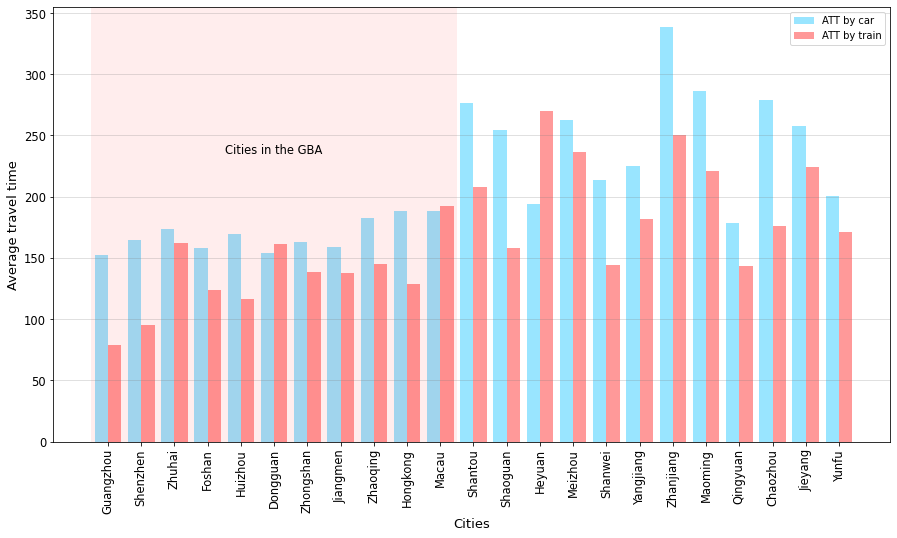

In [28]:
#PLOT TRAVEL TIME NOW
fig = plt.figure(figsize=(15,8)) 
x = np.arange(len(accessibility))
width = 0.4
t1 = 'Cities in the GBA'
# plt.set_xlim(-1,22)

plt.bar(x - width/2,accessibility['Car_Average'],width,fc='deepskyblue',alpha=0.4,label = 'ATT by car')
plt.bar(x + width/2,accessibility['Train_Average_Time_Now'],width,fc='red',alpha=0.4,label = 'ATT by train')
plt.xticks(x, labels=accessibility.index,rotation = 90,fontsize=11.5) # plt.bar(range(len(data)), data, tick_label=labels)!
plt.yticks(fontsize=11.5) 
plt.grid(color='grey',alpha=0.3, axis = 'y' )#, linestyle='--'
plt.xlabel("Cities",fontsize=13)
plt.ylabel("Average travel time",fontsize=13)
plt.legend(loc=1)
plt.axvspan(-0.5, 10.5, facecolor='red', alpha=0.07)
plt.text(5,235, t1, ha='center', rotation=0, alpha=1, wrap=True,fontsize=11.5) 
#plt.title('Average travel time by driving and train')
plt.savefig('./pics/2Average_travel_time_by_driving_and_train.jpg', dpi=150, bbox_inches='tight')
plt.show()

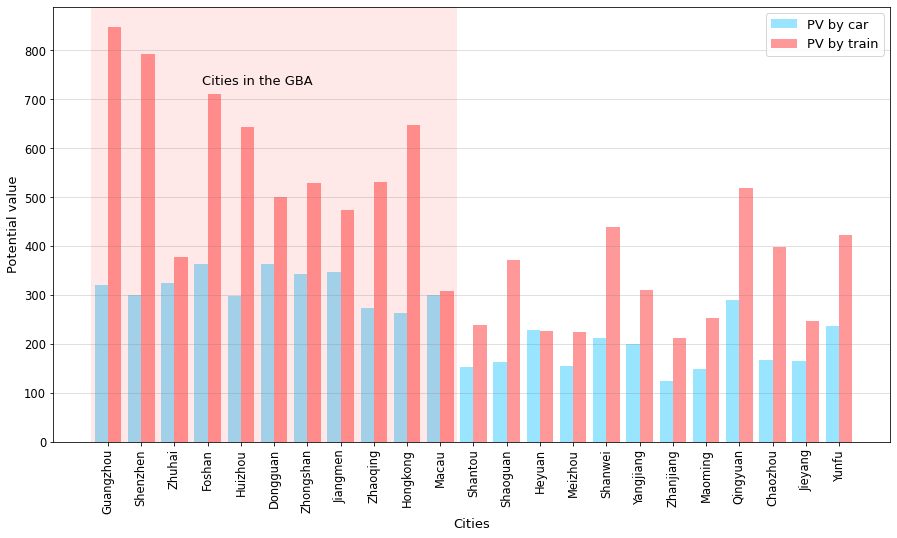

In [29]:
#BASIC ACCESSIBILITY
fig = plt.figure(figsize=(15,8)) 
x = np.arange(len(accessibility))
width = 0.4
t1 = 'Cities in the GBA'
# plt.set_xlim(-1,22)
plt.bar(x - width/2,accessibility['Car_Acc_Orig1'],width,fc='deepskyblue',alpha=0.4,label = 'PV by car')
plt.bar(x + width/2,accessibility['Train_Acc_Orig1'],width,fc='red',alpha=0.4,label = 'PV by train')
plt.grid(color='grey',alpha=0.3, axis = 'y')
plt.xticks(x, labels=accessibility.index,rotation = 90,fontsize=11.5) # plt.bar(range(len(data)), data, tick_label=labels)!
plt.yticks(fontsize=11.5) 
plt.xlabel("Cities",fontsize=13)
plt.ylabel("Potential value",fontsize=13) #Economic linkage intensity
plt.legend(loc='best',fontsize=13)

plt.axvspan(-0.5, 10.5, facecolor='red', alpha=0.09)
plt.text(4.5,730, t1, ha='center', rotation=0, alpha=1,fontsize=13) #, wrap=True
#plt.title('Economic linkage intensity by driving and train')
plt.savefig('./pics/3Potential value.jpg', dpi=150, bbox_inches='tight')
plt.show()

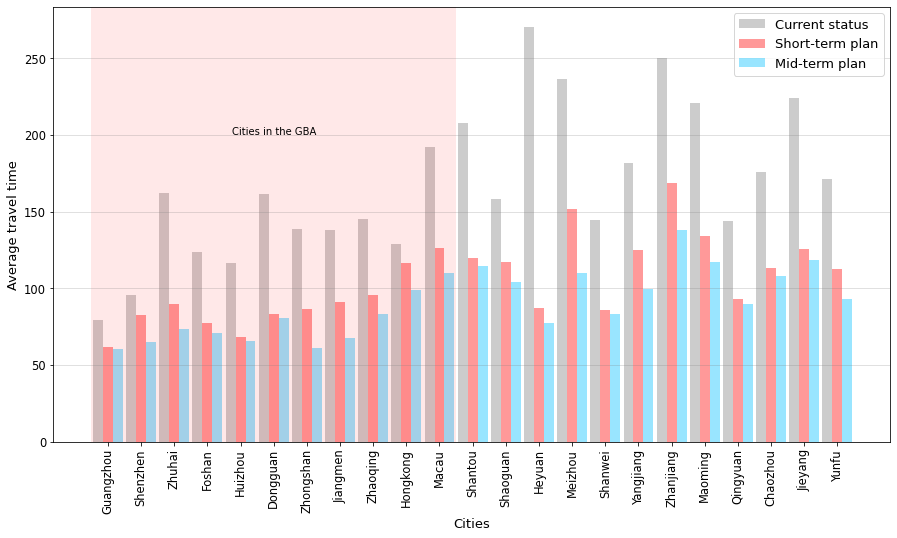

In [30]:
#TRAVEL TIME LATER
fig = plt.figure(figsize=(15,8)) 
x = np.arange(len(accessibility))
width = 0.3
plt.bar(x - width,accessibility['Train_Average_Time_Now'],width,fc='grey',alpha=0.4,label = 'Current status')
plt.bar(x ,accessibility['Train_Average_Time_ST'],width,fc='r',alpha=0.4,label = 'Short-term plan')
plt.bar(x + width,accessibility['Train_Average_Time_LT'],width,fc='deepskyblue',alpha=0.4,label = 'Mid-term plan')#'r-', ning scenario
plt.xticks(x, labels=accessibility.index,rotation = 90,fontsize=11.5) # plt.bar(range(len(data)), data, tick_label=labels)!
plt.yticks(fontsize=11.5) 
plt.grid(color='grey',alpha=0.3, axis = 'y' )
plt.xlabel("Cities",fontsize=13)
plt.ylabel("Average travel time",fontsize=13)
plt.legend(loc='best',fontsize=13)
plt.axvspan(-0.5, 10.5, facecolor='red', alpha=0.09)
plt.text(5,200, t1, ha='center', rotation=0, alpha=1) #, wrap=True

# plt.title('Average travel time by train in 3 scenarios (current,short-term planning and long-term planning)')
plt.savefig('./pics/4Average_travel_time_by_train_in_3_scenarios_(current,short-term_planning_and_mid-term_planning).jpg', dpi=150, bbox_inches='tight')
plt.show()

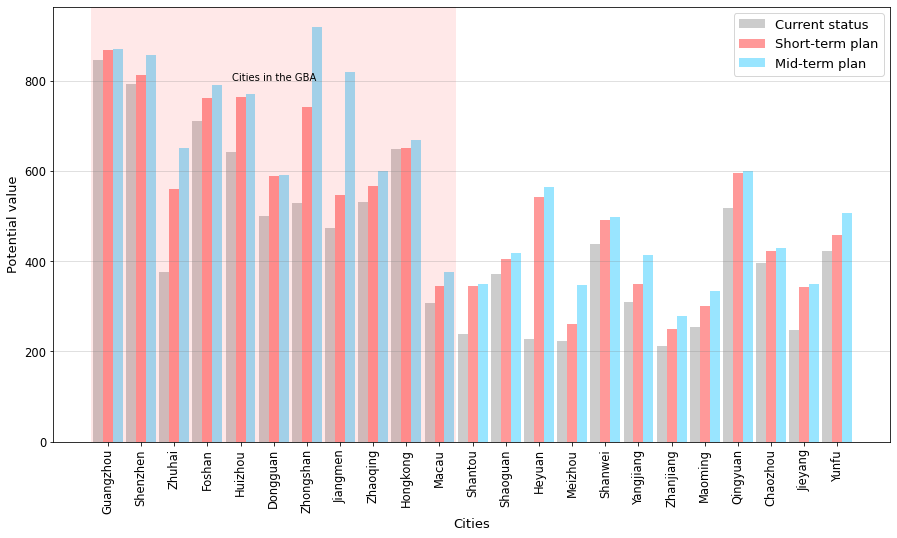

In [31]:
#TRAVEL ACCESSIBILITY LATER
fig = plt.figure(figsize=(15,8)) 
x = np.arange(len(accessibility))
width = 0.3
plt.bar(x - width,accessibility['Train_Acc_Orig1'],width,fc='grey',alpha=0.4,label = 'Current status')
plt.bar(x ,accessibility['Train_Acc_Orig_st'],width,fc='r',alpha=0.4,label = 'Short-term plan')
plt.bar(x + width,accessibility['Train_Acc_Orig_lt'],width,fc='deepskyblue',alpha=0.4,label = 'Mid-term plan')#'r-', ning scenario
plt.xticks(x, labels=accessibility.index,rotation = 90,fontsize=11.5) # plt.bar(range(len(data)), data, tick_label=labels)!
plt.yticks(fontsize=11.5) 
plt.grid(color='grey',alpha=0.3, axis = 'y' )
plt.xlabel("Cities",fontsize=13)
plt.ylabel("Potential value",fontsize=13)
plt.legend(loc='best',fontsize=13)
plt.axvspan(-0.5, 10.5, facecolor='red', alpha=0.09)
plt.text(5,800, t1, ha='center', rotation=0, alpha=1) #, wrap=True
# plt.title('ELI by train in 3 scenarios (current,short-term planning and long-term planning)')
plt.savefig('./pics/4xPotential value_by_train_in_3_scenarios_(current,short-term_planning_and_mid-term_planning).jpg', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
#add information to origins
car = car.merge(statistics_car, left_on = 'Origin', right_on = 'City')
car.drop(columns = ['City'], inplace = True)
car.rename(columns = {'Population':'Pop_Orig','Labour_Force':'Lab_Orig','GDP':'GDP_Orig',
                      'Investment_in_Fixed_Assets':'IFA_Orig','Foreign_Trade':'FT_Orig','RD_Investment':'RDI_Orig','Housing_Price':'HP_Orig','Education':'Edu_Orig',
                      'Car_Ownership':'CO_Orig','Highway_Length':'HWL_Orig'}, inplace = True)

train = train.merge(statistics_train, left_on = 'Origin', right_on = 'City')
train.drop(columns = ['City'], inplace = True)
train.rename(columns = {'Population':'Pop_Orig','Labour_Force':'Lab_Orig','GDP':'GDP_Orig',
                        'Investment_in_Fixed_Assets':'IFA_Orig','Foreign_Trade':'FT_Orig','RD_Investment':'RDI_Orig','Housing_Price':'HP_Orig','Education':'Edu_Orig',
                        'Railway_Length_Now':'RLN_Orig','Railway_Length_ST':'RLS_Orig','Railway_Length_LT':'RLL_Orig'}, inplace = True)
car = car[car.Driving_Time != 0]
train = train[train.Train_Time != 0]

In [33]:
car.sample(n=3)

,Origin,Destination,Driving_Time,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,CO_Dest,HWL_Dest,Car_Acc_Orig1,Pop_Orig,Lab_Orig,GDP_Orig,IFA_Orig,FT_Orig,RDI_Orig,HP_Orig,Edu_Orig,CO_Orig,HWL_Orig
241,Dongguan,Zhongshan,90.616667,338.00,237.21,3101.10,1085.328634,2387.15000,653709.3,11202,0.627219,3577.073964,7.902367,11.298171,846.45,711.11,9482.50,2129.304615,13834.31,2899619.3,16105,0.391045,3822.009569,6.242542
18,Guangzhou,Chaozhou,293.350000,265.98,109.26,1080.94,550.207013,215.60000,75221.3,6927,2.240770,1416.166629,19.847357,1.827844,1530.59,1125.89,23628.60,7462.123310,10003.51,6777377.5,31692,0.640276,1822.209736,5.879432
343,Zhanjiang,Macau,311.733333,67.96,38.80,4346.70,742.031942,879.83469,50000.0,85000,1.030018,3533.622719,1.000000,1.743505,736.00,391.78,3064.72,1809.057986,413.89,135570.6,7763,1.277174,919.020380,30.088315


In [34]:
train.sample(n=3)

,Origin,Destination,Train_Time,Train_Time_st,Train_Time_lt,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,RLN_Dest,RLS_Dest,RLL_Dest,Train_Acc_Orig1,Train_Acc_Orig_st,Train_Acc_Orig_lt,Pop_Orig,Lab_Orig,GDP_Orig,IFA_Orig,FT_Orig,RDI_Orig,HP_Orig,Edu_Orig,RLN_Orig,RLS_Orig,RLL_Orig
255,Zhongshan,Zhuhai,25,18.635355,18.635355,202.37,161.17,3435.89,2128.427687,2908.54,1083104.9,21134,0.647329,77.653960,96.441973,96.441973,33.354365,44.746083,44.746083,338.00,237.21,3101.10,1085.328634,2387.15,653709.3,11202,0.627219,69.741622,125.174681,163.927625
410,Qingyuan,Jieyang,270,159.864389,153.730255,610.50,198.23,2101.77,2128.906441,324.51,198989.3,6775,2.039312,148.589960,182.754987,182.754987,4.195383,7.085715,7.368449,388.58,201.13,1698.22,847.791522,416.24,136535.8,7309,0.880128,271.907702,271.907702,375.524782
31,Shenzhen,Huizhou,22,27.410061,27.410061,488.00,318.29,4177.41,2659.002117,2709.65,1093536.2,9956,1.135246,244.576284,461.592077,603.407212,64.899415,52.089893,52.089893,1343.88,1283.37,26927.09,7374.709489,29780.61,13282828.5,54790,0.252999,198.736617,220.065201,313.046736


In [35]:
print(len(car.columns),len(car.index),len(train.columns),len(train.index))

24 506 30 506


# Taking logs      
ff_train1719 ff_bus1719  car_durataion,train_duration   
#sort_index(axis=1)   .sort_values(["Age", "Fare"]     
#reindex(sorted(df.columns), axis=1)    
#df.reset_index(drop=True, inplace=True)    #set_index       
#rename    

In [36]:
#ff_bus1719.sample()

In [37]:
#prepare flow information
ff_bus = ff_bus1719.groupby(['Orig','Dest']).agg('sum').reset_index()
ff_train = ff_train1719.groupby(['Orig','Dest']).agg('sum').reset_index()

ff_bus = ff_bus[ff_bus.Flow != 0]
ff_train = ff_train[ff_train.Flow != 0]

display(ff_bus.sample(n=3),len(ff_bus),        ff_train.sample(n=3),len(ff_train))

,Orig,Dest,Flow
27,Dongguan,Shanwei,638113
221,Shanwei,Zhongshan,74652
135,Jiangmen,Zhanjiang,1542805


341

,Orig,Dest,Flow
189,Qingyuan,Shenzhen,2558024
273,Yangjiang,Zhongshan,318048
4,Chaozhou,Jieyang,2058147


362

In [38]:
#merge all information
ff_bus = ff_bus.merge(car, left_on = ['Orig','Dest'], right_on = ['Origin','Destination'])  ##ff_bus with all information
ff_train = ff_train.merge(train, left_on = ['Orig','Dest'], right_on = ['Origin','Destination'])  ##ff_train with all information
ff_bus.drop(columns = ['Origin','Destination'],inplace=True)
ff_train.drop(columns = ['Origin','Destination'],inplace=True)

display(ff_bus.sample(n=3),ff_train.sample(n=3))

,Orig,Dest,Flow,Driving_Time,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,CO_Dest,HWL_Dest,Car_Acc_Orig1,Pop_Orig,Lab_Orig,GDP_Orig,IFA_Orig,FT_Orig,RDI_Orig,HP_Orig,Edu_Orig,CO_Orig,HWL_Orig
127,Jiangmen,Huizhou,3654,142.833333,488.00,318.29,4177.41,2659.002117,2709.65,1093536.2,9956,1.135246,2681.719262,27.081967,9.996176,463.03,272.27,3146.64,2104.744275,1425.36,710632.0,7149,0.704058,1905.362504,20.549424
12,Chaozhou,Zhaoqing,550,351.466667,418.71,231.64,2248.80,1825.213940,404.38,248688.4,7263,0.556471,1440.980631,34.166846,2.760883,265.98,109.26,1080.94,550.207013,215.60,75221.3,6927,2.240770,1416.166629,19.847357
0,Chaozhou,Dongguan,162879,259.416667,846.45,711.11,9482.50,2129.304615,13834.31,2899619.3,16105,0.391045,3822.009569,6.242542,10.921045,265.98,109.26,1080.94,550.207013,215.60,75221.3,6927,2.240770,1416.166629,19.847357


,Orig,Dest,Flow,Train_Time,Train_Time_st,Train_Time_lt,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,RLN_Dest,RLS_Dest,RLL_Dest,Train_Acc_Orig1,Train_Acc_Orig_st,Train_Acc_Orig_lt,Pop_Orig,Lab_Orig,GDP_Orig,IFA_Orig,FT_Orig,RDI_Orig,HP_Orig,Edu_Orig,RLN_Orig,RLS_Orig,RLL_Orig
223,Shanwei,Zhuhai,34380,203,107.663987,97.741281,202.37,161.17,3435.89,2128.427687,2908.54,1083104.9,21134,0.647329,77.653960,96.441973,96.441973,4.107680,7.745014,8.531289,301.50,124.67,1080.30,898.285036,167.74,48227.1,7039,1.492537,112.122806,227.146609,227.146609
233,Shaoguan,Shanwei,464,188,142.122723,142.122723,301.50,124.67,1080.30,898.285036,167.74,48227.1,7039,1.492537,112.122806,227.146609,227.146609,3.035694,4.015617,4.015617,303.04,133.82,1318.41,764.416019,182.27,190999.6,5793,0.673178,435.750791,435.750791,587.634869
134,Jiangmen,Zhaoqing,419043,116,116.000000,41.226452,418.71,231.64,2248.80,1825.213940,404.38,248688.4,7263,0.556471,331.731982,342.824728,370.616853,8.365157,8.365157,23.537272,463.03,272.27,3146.64,2104.744275,1425.36,710632.0,7149,0.704058,207.212534,207.212534,220.977988


In [39]:
print(ff_bus.columns)
print(ff_train.columns)

Index(['Orig', 'Dest', 'Flow', 'Driving_Time', 'Pop_Dest', 'Lab_Dest',
       'GDP_Dest', 'IFA_Dest', 'FT_Dest', 'RDI_Dest', 'HP_Dest', 'Edu_Dest',
       'CO_Dest', 'HWL_Dest', 'Car_Acc_Orig1', 'Pop_Orig', 'Lab_Orig',
       'GDP_Orig', 'IFA_Orig', 'FT_Orig', 'RDI_Orig', 'HP_Orig', 'Edu_Orig',
       'CO_Orig', 'HWL_Orig'],
      dtype='object')
Index(['Orig', 'Dest', 'Flow', 'Train_Time', 'Train_Time_st', 'Train_Time_lt',
       'Pop_Dest', 'Lab_Dest', 'GDP_Dest', 'IFA_Dest', 'FT_Dest', 'RDI_Dest',
       'HP_Dest', 'Edu_Dest', 'RLN_Dest', 'RLS_Dest', 'RLL_Dest',
       'Train_Acc_Orig1', 'Train_Acc_Orig_st', 'Train_Acc_Orig_lt', 'Pop_Orig',
       'Lab_Orig', 'GDP_Orig', 'IFA_Orig', 'FT_Orig', 'RDI_Orig', 'HP_Orig',
       'Edu_Orig', 'RLN_Orig', 'RLS_Orig', 'RLL_Orig'],
      dtype='object')


In [40]:
#take the variables and produce logarithms of them (car)
x_vars_c = ['Pop_Dest', 'Lab_Dest','GDP_Dest', 'IFA_Dest', 'FT_Dest', 'RDI_Dest', 'HP_Dest', 'Edu_Dest',
            'CO_Dest', 'HWL_Dest', 
            'Pop_Orig', 'Lab_Orig', 'GDP_Orig','IFA_Orig', 'FT_Orig','RDI_Orig', 'HP_Orig', 'Edu_Orig',
            'CO_Orig','HWL_Orig',
            'Driving_Time']
log_x_vars_c = []
for x in x_vars_c:
    ff_bus[f"log_{x}"] = np.log(ff_bus[x])
    log_x_vars_c.append(f"log_{x}")

In [41]:
ff_bus.loc[ff_bus.isnull().any(axis = 1)] #ff_bus.isnull().any(axis = 1)

,Orig,Dest,Flow,Driving_Time,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,CO_Dest,HWL_Dest,Car_Acc_Orig1,Pop_Orig,Lab_Orig,GDP_Orig,IFA_Orig,FT_Orig,RDI_Orig,HP_Orig,Edu_Orig,CO_Orig,HWL_Orig,log_Pop_Dest,log_Lab_Dest,log_GDP_Dest,log_IFA_Dest,log_FT_Dest,log_RDI_Dest,log_HP_Dest,log_Edu_Dest,log_CO_Dest,log_HWL_Dest,log_Pop_Orig,log_Lab_Orig,log_GDP_Orig,log_IFA_Orig,log_FT_Orig,log_RDI_Orig,log_HP_Orig,log_Edu_Orig,log_CO_Orig,log_HWL_Orig,log_Driving_Time


In [42]:
#take the variables and produce logarithms of them (train)
x_vars_t = ['Pop_Dest', 'Lab_Dest','GDP_Dest', 'IFA_Dest', 'FT_Dest', 'RDI_Dest', 'HP_Dest', 'Edu_Dest',
            'RLN_Dest', 'RLS_Dest', 'RLL_Dest',
            'Pop_Orig', 'Lab_Orig', 'GDP_Orig','IFA_Orig', 'FT_Orig','RDI_Orig', 'HP_Orig', 'Edu_Orig',
            'RLN_Orig', 'RLS_Orig', 'RLL_Orig',
            'Train_Time','Train_Time_st','Train_Time_lt']
log_x_vars_t = []
for x in x_vars_t:
    ff_train[f"log_{x}"] = np.log(ff_train[x])
    log_x_vars_t.append(f"log_{x}")

In [43]:
ff_train.loc[ff_train.isnull().any(axis = 1)] #ff_train.isnull().any(axis = 1)

,Orig,Dest,Flow,Train_Time,Train_Time_st,Train_Time_lt,Pop_Dest,Lab_Dest,GDP_Dest,IFA_Dest,FT_Dest,RDI_Dest,HP_Dest,Edu_Dest,RLN_Dest,RLS_Dest,RLL_Dest,Train_Acc_Orig1,Train_Acc_Orig_st,Train_Acc_Orig_lt,Pop_Orig,Lab_Orig,GDP_Orig,IFA_Orig,FT_Orig,RDI_Orig,HP_Orig,Edu_Orig,RLN_Orig,RLS_Orig,RLL_Orig,log_Pop_Dest,log_Lab_Dest,log_GDP_Dest,log_IFA_Dest,log_FT_Dest,log_RDI_Dest,log_HP_Dest,log_Edu_Dest,log_RLN_Dest,log_RLS_Dest,log_RLL_Dest,log_Pop_Orig,log_Lab_Orig,log_GDP_Orig,log_IFA_Orig,log_FT_Orig,log_RDI_Orig,log_HP_Orig,log_Edu_Orig,log_RLN_Orig,log_RLS_Orig,log_RLL_Orig,log_Train_Time,log_Train_Time_st,log_Train_Time_lt


In [44]:
ff_bus_nohm = ff_bus[~(ff_bus.Orig.str.contains('Hongkong|Macau') | ff_bus.Dest.str.contains('Hongkong|Macau'))] 
print(len(ff_bus_nohm),len(ff_bus))
ff_train_nohm = ff_train[~(ff_train.Orig.str.contains('Hongkong|Macau') | ff_train.Dest.str.contains('Hongkong|Macau'))] 
print(len(ff_train_nohm),len(ff_train))

316 341
338 362


## First Calculation with only GDP and population   
see how good the fit is?

In [ ]:
#create the formula
formula_c1 = 'Flow ~ log_Pop_Orig + log_GDP_Orig + log_Pop_Dest + log_GDP_Dest + log_Driving_Time'
formula_t1 = 'Flow ~ log_Pop_Orig + log_GDP_Orig + log_Pop_Dest + log_GDP_Dest + log_Train_Time'
#run the regression
uncosim_c1 = smf.glm(formula = formula_c1, data=ff_bus, family=sm.families.Poisson()).fit()
uncosim_t1 = smf.glm(formula = formula_t1, data=ff_train, family=sm.families.Poisson()).fit()
display(uncosim_c1.params,'------------------------------',uncosim_t1.params)
print('\n\n\n')
uncosim_cn1 = smf.glm(formula = formula_c1, data=ff_bus_nohm, family=sm.families.Poisson()).fit()
uncosim_tn1 = smf.glm(formula = formula_t1, data=ff_train_nohm, family=sm.families.Poisson()).fit()
display(uncosim_cn1.params,'------------------------------',uncosim_tn1.params)#.summary()

In [ ]:
#Driving:
predictions_c1 = uncosim_c1.get_prediction()   #Hongkong and Macau included
predictions_summary_frame_c1 = predictions_c1.summary_frame()
ff_bus["Fitted1"] = predictions_summary_frame_c1["mean"]

predictions_cn1 = uncosim_cn1.get_prediction()   #Hongkong and Macau excluded
predictions_summary_frame_cn1 = predictions_cn1.summary_frame()
ff_bus_nohm["Fitted1"] = predictions_summary_frame_cn1["mean"]
#Train:
predictions_t1 = uncosim_t1.get_prediction()   #Hongkong and Macau included
predictions_summary_frame_t1 = predictions_t1.summary_frame()
ff_train["Fitted1"] = predictions_summary_frame_t1["mean"]

predictions_tn1 = uncosim_tn1.get_prediction()   #Hongkong and Macau excluded
predictions_summary_frame_tn1 = predictions_tn1.summary_frame()
ff_train_nohm["Fitted1"] = predictions_summary_frame_tn1["mean"]
#output
print('Driving:\n',
      'Hongkong and Macau included:\n',
      'R2:',CalcRSqaured(ff_bus["Flow"], ff_bus["Fitted1"]),
      'RMSE:',CalcRMSE(ff_bus["Flow"], ff_bus["Fitted1"]),
      '\nHongkong and Macau excluded:\n',
      'R2:',CalcRSqaured(ff_bus_nohm["Flow"], ff_bus_nohm["Fitted1"]),
      'RMSE:',CalcRMSE(ff_bus_nohm["Flow"], ff_bus_nohm["Fitted1"]),      
      
      '\n\n',
      
      'Train:\n',
      'Hongkong and Macau ixcluded:\n',
      'R2:',CalcRSqaured(ff_train["Flow"], ff_train["Fitted1"]),
      'RMSE:',CalcRMSE(ff_train["Flow"], ff_train["Fitted1"]),
      '\nHongkong and Macau excluded:\n',
      'R2:',CalcRSqaured(ff_train_nohm["Flow"], ff_train_nohm["Fitted1"]),
      'RMSE:',CalcRMSE(ff_train_nohm["Flow"], ff_train_nohm["Fitted1"])
     )

## Second Calculation with all variables   
see how good the fit is ?

In [ ]:
#create the formula   
formula_c2 = 'Flow ~ log_Lab_Dest + log_GDP_Dest + log_IFA_Dest + log_RDI_Dest + log_HP_Dest + log_Edu_Dest + log_CO_Dest + log_HWL_Dest + log_Pop_Orig + log_Lab_Orig + log_GDP_Orig + log_IFA_Orig + log_FT_Orig + log_RDI_Orig + log_HP_Orig + log_Edu_Orig + log_CO_Orig + log_HWL_Orig + log_Driving_Time'
formula_t2 = 'Flow ~ log_Lab_Dest + log_GDP_Dest + log_IFA_Dest + log_RDI_Dest + log_HP_Dest + log_Edu_Dest + log_RLN_Dest + log_RLS_Dest + log_RLL_Dest + log_Pop_Orig + log_Lab_Orig + log_GDP_Orig + log_IFA_Orig + log_FT_Orig + log_RDI_Orig + log_HP_Orig + log_Edu_Orig + log_RLN_Orig + log_RLS_Orig + log_RLL_Orig + log_Train_Time'
# formula_c2 = 'Flow ~ log_Pop_Dest + log_Lab_Dest + log_GDP_Dest + log_IFA_Dest + log_FT_Dest + log_RDI_Dest + log_HP_Dest + log_Edu_Dest + log_CO_Dest + log_HWL_Dest + log_Pop_Orig + log_Lab_Orig + log_GDP_Orig + log_IFA_Orig + log_FT_Orig + log_RDI_Orig + log_HP_Orig + log_Edu_Orig + log_CO_Orig + log_HWL_Orig + log_Driving_Time'
# formula_t2 = 'Flow ~ log_Pop_Dest + log_Lab_Dest + log_GDP_Dest + log_IFA_Dest + log_FT_Dest + log_RDI_Dest + log_HP_Dest + log_Edu_Dest + log_RLN_Dest + log_RLS_Dest + log_RLL_Dest + log_Pop_Orig + log_Lab_Orig + log_GDP_Orig + log_IFA_Orig + log_FT_Orig + log_RDI_Orig + log_HP_Orig + log_Edu_Orig + log_RLN_Orig + log_RLS_Orig + log_RLL_Orig + log_Train_Time'

#run the regression
uncosim_c2 = smf.glm(formula = formula_c2, data=ff_bus, family=sm.families.Poisson()).fit()
uncosim_t2 = smf.glm(formula = formula_t2, data=ff_train, family=sm.families.Poisson()).fit()
# display(uncosim_c2.summary(),'------------------------------',uncosim_t2.summary())
# print('\n\n\n')
uncosim_cn2 = smf.glm(formula = formula_c2, data=ff_bus_nohm, family=sm.families.Poisson()).fit()
uncosim_tn2 = smf.glm(formula = formula_t2, data=ff_train_nohm, family=sm.families.Poisson()).fit()
# display(uncosim_cn2.summary(),'------------------------------',uncosim_tn2.summary())

In [ ]:
#Driving:
predictions_c2 = uncosim_c2.get_prediction()   #Hongkong and Macau included
predictions_summary_frame_c2 = predictions_c2.summary_frame()
ff_bus["Fitted2"] = predictions_summary_frame_c2["mean"]

predictions_cn2 = uncosim_cn2.get_prediction()   #Hongkong and Macau excluded
predictions_summary_frame_cn2 = predictions_cn2.summary_frame()
ff_bus_nohm["Fitted2"] = predictions_summary_frame_c2["mean"]

#Train:
predictions_t2 = uncosim_t2.get_prediction()   #Hongkong and Macau included
predictions_summary_frame_t2 = predictions_t2.summary_frame()
ff_train["Fitted2"] = predictions_summary_frame_t2["mean"]

predictions_tn2 = uncosim_tn2.get_prediction()   #Hongkong and Macau excluded
predictions_summary_frame_tn2 = predictions_tn2.summary_frame()
ff_train_nohm["Fitted2"] = predictions_summary_frame_tn2["mean"]

#output
print('Driving:\n',
      'Hongkong and Macau included:\n',
      'R2:',CalcRSqaured(ff_bus["Flow"], ff_bus["Fitted2"]),
      'RMSE:',CalcRMSE(ff_bus["Flow"], ff_bus["Fitted2"]),
      '\nHongkong and Macau excluded:\n',
      'R2:',CalcRSqaured(ff_bus_nohm["Flow"], ff_bus_nohm["Fitted2"]),
      'RMSE:',CalcRMSE(ff_bus_nohm["Flow"], ff_bus_nohm["Fitted2"]),      
      
      '\n\n',
      
      'Train:\n',
      'Hongkong and Macau ixcluded:\n',
      'R2:',CalcRSqaured(ff_train["Flow"], ff_train["Fitted2"]),
      'RMSE:',CalcRMSE(ff_train["Flow"], ff_train["Fitted2"]),
      '\nHongkong and Macau excluded:\n',
      'R2:',CalcRSqaured(ff_train_nohm["Flow"], ff_train_nohm["Fitted2"]),
      'RMSE:',CalcRMSE(ff_train_nohm["Flow"], ff_train_nohm["Fitted2"])
     )

# Stepwise variable selection(by Pvalue)    

In [ ]:
ff_bus_x = ff_bus[['Flow',
                   'log_Pop_Dest', 'log_Lab_Dest', 'log_GDP_Dest','log_IFA_Dest', 'log_FT_Dest', 'log_RDI_Dest', 'log_HP_Dest','log_Edu_Dest',
                   'log_CO_Dest', 'log_HWL_Dest',
                   'log_Pop_Orig','log_Lab_Orig', 'log_GDP_Orig', 'log_IFA_Orig', 'log_FT_Orig','log_RDI_Orig', 'log_HP_Orig', 'log_Edu_Orig',
                   'log_CO_Orig','log_HWL_Orig',
                   'log_Driving_Time']]

ff_train_x = ff_train[['Flow',
                       'log_Pop_Dest','log_Lab_Dest', 'log_GDP_Dest', 'log_IFA_Dest', 'log_FT_Dest','log_RDI_Dest', 'log_HP_Dest', 'log_Edu_Dest',
                       'log_RLN_Dest','log_RLS_Dest', 'log_RLL_Dest', 
                       'log_Pop_Orig', 'log_Lab_Orig','log_GDP_Orig', 'log_IFA_Orig', 'log_FT_Orig', 'log_RDI_Orig','log_HP_Orig', 'log_Edu_Orig',
                       'log_RLN_Orig', 'log_RLS_Orig','log_RLL_Orig',
                       'log_Train_Time']]

ff_bus_nohm_x = ff_bus_nohm[['Flow','log_Pop_Dest', 'log_Lab_Dest', 'log_GDP_Dest','log_IFA_Dest', 'log_FT_Dest', 'log_RDI_Dest', 'log_HP_Dest','log_Edu_Dest',
                             'log_CO_Dest', 'log_HWL_Dest',
                             'log_Pop_Orig','log_Lab_Orig', 'log_GDP_Orig', 'log_IFA_Orig', 'log_FT_Orig','log_RDI_Orig', 'log_HP_Orig', 'log_Edu_Orig',
                             'log_CO_Orig','log_HWL_Orig',
                             'log_Driving_Time']]

ff_train_nohm_x = ff_train_nohm[['Flow','log_Pop_Dest','log_Lab_Dest', 'log_GDP_Dest', 'log_IFA_Dest', 'log_FT_Dest','log_RDI_Dest', 'log_HP_Dest', 'log_Edu_Dest',
                       'log_RLN_Dest','log_RLS_Dest', 'log_RLL_Dest', 
                       'log_Pop_Orig', 'log_Lab_Orig','log_GDP_Orig', 'log_IFA_Orig', 'log_FT_Orig', 'log_RDI_Orig','log_HP_Orig', 'log_Edu_Orig',
                       'log_RLN_Orig', 'log_RLS_Orig','log_RLL_Orig',
                       'log_Train_Time']]

In [ ]:
def stepwise_selection_pvalue(X,initial_list=[], 
                       threshold_in=0.01,threshold_out = 0.05, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included)-set(['Flow'])) 
        new_pval = pd.Series(index=excluded,dtype='float64')
        formula = 'Flow ~ '
        for i in included:
            formula = formula + ' + ' + i 
            
        for new_column in excluded:
            formulax = formula + ' + ' + new_column
            model = smf.glm(formula = formulax, data = X, family=sm.families.Poisson()).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:15} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        formula = 'Flow~ '
        for i in included:
            formula = formula + ' + ' + i 
        model = smf.glm(formula = formula, data=X, family=sm.families.Poisson()).fit()
        pvalues = model.pvalues.iloc[1:]# use all coefs except intercept
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:15} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
len(ff_train_x.columns)

In [ ]:
list_bus = stepwise_selection_pvalue(ff_bus_x, initial_list=[], 
                   threshold_in=0.01,threshold_out = 0.05, 
                   verbose=True)
print(list_bus,len(list_bus))
# list_bus_nohm = stepwise_selection_pvalue(ff_bus_nohm_x, initial_list=[], 
#                    threshold_in=0.01,threshold_out = 0.05, 
#                    verbose=True)
# print(list_bus_nohm,len(list_bus_nohm))
list_train = stepwise_selection_pvalue(ff_train_x,initial_list=[], 
                   threshold_in=0.01,threshold_out = 0.05, 
                   verbose=True)
print(list_train,len(list_train))
# list_train_nohm = stepwise_selection_pvalue(ff_train_nohm_x,initial_list=[], 
#                    threshold_in=0.01,threshold_out = 0.05, 
#                    verbose=True)
# print(list_train_nohm,len(list_train_nohm))

# Stepwise variable selection(by R2)   

In [ ]:
def stepwise_selection_R2(X, initial_list=[], verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        
        # forward step
        xx= X.copy(deep = True)
        excluded = list(set(xx.columns)-set(included)-set(['Flow'])) 
        new_r2val = pd.Series(index=excluded,dtype='float64')
        
        formula = 'Flow ~ '
        for i in included:
            formula = formula + ' + ' + i 
        model = smf.glm(formula = formula, data = xx, family=sm.families.Poisson()).fit()
        prediction = model.get_prediction() 
        prediction_summary_frame = prediction.summary_frame()
        xx["Fit"] = prediction_summary_frame["mean"]    
        r2_base = CalcRSqaured(xx['Flow'], xx['Fit'])
      
        for new_column in excluded:
            formulax = formula + ' + ' + new_column
            model = smf.glm(formula = formulax, data = xx, family=sm.families.Poisson()).fit()
            prediction = model.get_prediction() 
            prediction_summary_frame = prediction.summary_frame()
            xx["Fit"] = prediction_summary_frame["mean"]    
            new_r2val[new_column] = CalcRSqaured(xx['Flow'], xx['Fit'])
        best_r2val = new_r2val.max()
        
        if best_r2val > r2_base:
            best_feature = new_r2val.idxmax()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:15} with r2-value {:.6}'.format(best_feature, best_r2val))
        
        if not changed:
            print('End at {:15} with r2-value {:.6}'.format(best_feature, best_r2val))
            break
    return included

In [ ]:
list_bus_r2 = stepwise_selection_R2(ff_bus_x, 
                   initial_list=['log_GDP_Dest','log_GDP_Orig','log_Driving_Time'], 
                   verbose=True)
print(list_bus_r2,'\n\n')

# list_bus_nohm_r2 = stepwise_selection_R2(ff_bus_nohm_x,
#                    initial_list=['log_GDP_Dest','log_GDP_Orig','log_Driving_Time'], 
#                    verbose=True)
# print(list_bus_nohm_r2,'\n\n')

list_train_r2 = stepwise_selection_R2(ff_train_x,
                   initial_list=['log_GDP_Dest','log_GDP_Orig','log_Train_Time'], 
                   verbose=True)
print(list_train,'\n\n')

# list_train_nohm_r2 = stepwise_selection_R2(ff_train_nohm_x,
#                    initial_list=['log_GDP_Dest','log_GDP_Orig','log_Train_Time'], 
#                    verbose=True)
# print(list_train_nohm_r2,'\n\n')

In [ ]:
def stepwise_selection_R21(X, initial_list=['GDP'],
                           test_list=['Pop','IFA','FT','RDI','HP','Edu','CO','HWL'],
                           time = 'log_Driving_Time',
                           verbose=True):

    included = list(initial_list)
    excluded = list(test_list)
    while True:
        changed=False
        
        # forward step
        xx= X.copy(deep = True)
        excluded = list(set(excluded)-set(included)) 
        new_r2val = pd.Series(index=excluded,dtype='float64')
        
        formula = 'Flow ~ '+ time
        for i in included:
            formula = formula + ' + log_' + i +'_Dest + log_' + i +'_Orig'
        model = smf.glm(formula = formula, data = xx, family=sm.families.Poisson()).fit()
        prediction = model.get_prediction() 
        prediction_summary_frame = prediction.summary_frame()
        xx["Fit"] = prediction_summary_frame["mean"]    
        r2_base = CalcRSqaured(xx['Flow'], xx['Fit'])
      
        for n in excluded:
            formulax = formula + ' + log_' + n +'_Dest + log_' + n +'_Orig'
            model = smf.glm(formula = formulax, data = xx, family=sm.families.Poisson()).fit()
            prediction = model.get_prediction() 
            prediction_summary_frame = prediction.summary_frame()
            xx["Fit"] = prediction_summary_frame["mean"]    
            new_r2val[n] = CalcRSqaured(xx['Flow'], xx['Fit'])
        best_r2val = new_r2val.max()
        
        if best_r2val > r2_base:
            best_feature = new_r2val.idxmax()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:15} with r2-value {:.6}'.format(best_feature, best_r2val))
        
        if not changed:
            print('End at {:15} with r2-value {:.6}'.format(best_feature, best_r2val))
            break
    return included

In [ ]:
list_bus_r2 = stepwise_selection_R21(ff_bus_x,initial_list=['GDP'],
                                     test_list=['Pop','Lab','IFA','FT','RDI','HP','Edu','CO','HWL'],
                                     time = 'log_Driving_Time',verbose=True)
print(list_bus_r2,'\n\n')

# list_bus_nohm_r2 = stepwise_selection_R21(ff_bus_nohm_x,initial_list=['GDP'],
#                                          test_list=['Pop','Lab','IFA','FT','RDI','HP','Edu','CO','HWL'],
#                                          time = 'log_Driving_Time',verbose=True)
# print(list_bus_nohm_r2,'\n\n')

list_train_r2 = stepwise_selection_R21(ff_train_x,initial_list=['GDP'],
                                       test_list=['Pop','Lab','IFA','FT','RDI','HP','Edu','RLN'], #
                                       time = 'log_Train_Time',verbose=True)
print(list_train_r2,'\n\n')

# list_train_nohm_r2 = stepwise_selection_R21(ff_train_nohm_x,initial_list=['GDP'],
#                                        test_list=['Pop','Lab','IFA','FT','RDI','HP','Edu','RLN'],
#                                        time = 'log_Train_Time',verbose=True)
# print(list_train_nohm_r2,'\n\n')

# !!!!  Calculations and Advanced Accessibility    

In [45]:
#create the formula    
#car   ['Pop','GDP','IFA','RDI','HP','CO','HWL'] GDP_na
test_list=['Pop','GDP','IFA','HP', 'CO','HWL']#['Pop','GDP','CO','HWL'] #['Pop','Lab','GDP','IFA','FT','RDI','HP','Edu','CO']
formula_c2 = 'Flow ~ log_Driving_Time'
for i in test_list:
    formula_c2 = formula_c2 + ' + log_' + i +'_Dest + log_' + i +'_Orig'

#train   ['Pop','GDP','IFA','RDI','HP','RLN']
test_list=['Pop','GDP','IFA','HP', 'RLN'] #['Pop','Lab','GDP','IFA','FT','RDI','HP','Edu','RLN'] 'FT','RDI','Edu',
formula_t2 = 'Flow ~ log_Train_Time'
for i in test_list:
    formula_t2 = formula_t2 + ' + log_' + i +'_Dest + log_' + i +'_Orig'
# formula_c2 = 'Flow ~ log_Pop_Dest + log_Lab_Dest + log_GDP_Dest + log_IFA_Dest + log_FT_Dest + log_RDI_Dest + log_HP_Dest + log_Edu_Dest + log_CO_Dest + log_HWL_Dest + log_Pop_Orig + log_Lab_Orig + log_GDP_Orig + log_IFA_Orig + log_FT_Orig + log_RDI_Orig + log_HP_Orig + log_Edu_Orig + log_CO_Orig + log_HWL_Orig + log_Driving_Time'
# formula_t2 = 'Flow ~ log_Pop_Dest + log_Lab_Dest + log_GDP_Dest + log_IFA_Dest + log_FT_Dest + log_RDI_Dest + log_HP_Dest + log_Edu_Dest + log_RLN_Dest + log_RLS_Dest + log_RLL_Dest + log_Pop_Orig + log_Lab_Orig + log_GDP_Orig + log_IFA_Orig + log_FT_Orig + log_RDI_Orig + log_HP_Orig + log_Edu_Orig + log_RLN_Orig + log_RLS_Orig + log_RLL_Orig + log_Train_Time'
#run the regression    
uncosim_c2 = smf.glm(formula = formula_c2, data=ff_bus, family=sm.families.Poisson()).fit()
uncosim_t2 = smf.glm(formula = formula_t2, data=ff_train, family=sm.families.Poisson()).fit()
display(uncosim_c2.params,'------------------------------',uncosim_t2.params) #summary()
display(uncosim_c2.summary(),'------------------------------',uncosim_t2.summary(),)
print('\n\n\n')
# uncosim_cn2 = smf.glm(formula = formula_c2, data=ff_bus_nohm, family=sm.families.Poisson()).fit()
# uncosim_tn2 = smf.glm(formula = formula_t2, data=ff_train_nohm, family=sm.families.Poisson()).fit()
# display(uncosim_cn2.params,'------------------------------',uncosim_tn2.params)

Intercept          -17.511876
log_Driving_Time    -2.414293
log_Pop_Dest         2.385575
log_Pop_Orig         2.210859
log_GDP_Dest        -1.960293
log_GDP_Orig        -1.830862
log_IFA_Dest         0.420115
log_IFA_Orig         0.446245
log_HP_Dest          1.062299
log_HP_Orig          0.912275
log_CO_Dest          1.438704
log_CO_Orig          1.406848
log_HWL_Dest        -0.032335
log_HWL_Orig        -0.075891
dtype: float64

'------------------------------'

Intercept         23.321573
log_Train_Time    -1.232086
log_Pop_Dest      -0.025748
log_Pop_Orig       0.044871
log_GDP_Dest       1.166420
log_GDP_Orig       1.337837
log_IFA_Dest      -0.181302
log_IFA_Orig      -0.290533
log_HP_Dest       -0.833190
log_HP_Orig       -1.021366
log_RLN_Dest      -0.276148
log_RLN_Orig      -0.370224
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Flow   No. Observations:                  341
Model:                            GLM   Df Residuals:                      327
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3699e+08
Date:                Mon, 06 Sep 2021   Deviance:                   4.7398e+08
Time:                        11:55:53   Pearson chi2:                 5.28e+08
No. Iterations:                    35                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -17.5119      0.004  -3912.718      0.000     -17.521     -17.503
log_Driving_Time    -2.4143   7.46e-05  -3.24e+04      0.000      -2.414      -2.414
log_Pop_Dest         2.3856      0.000   1.04e+04      0.000       2.385       2.386
log_Pop_Orig         2.2109      0.000   9682.464      0.000       2.210       2.211
log_GDP_Dest        -1.9603      0.000  -6584.607      0.000      -1.961      -1.960
log_GDP_Orig        -1.8309      0.000  -6194.325      0.000      -1.831      -1.830
log_IFA_Dest         0.4201      0.000   3006.952      0.000       0.420       0.420
log_IFA_Orig         0.4462      0.000   3221.962      0.000       0.446       0.447
log_HP_Dest          1.0623      0.000   4770.752      0.000       1.062       1.063
log_HP_Orig          0.9123      0.000   4131.646      0.000       0.912       0.913
log_CO_Dest          1.4387      0.000   7783.783      0.000       1.438       1.439
log_CO_Orig          1.4068      0.000   7663.508      0.000       1.406       1.407
log_HWL_Dest        -0.0323   6.05e-05   -534.363      0.000      -0.032      -0.032
log_HWL_Orig        -0.0759   6.01e-05  -1262.074      0.000      -0.076      -0.076
====================================================================================
"""

'------------------------------'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Flow   No. Observations:                  362
Model:                            GLM   Df Residuals:                      350
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5723e+08
Date:                Mon, 06 Sep 2021   Deviance:                   5.1445e+08
Time:                        11:55:53   Pearson chi2:                 6.09e+08
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         23.3216      0.001   1.74e+04      0.000      23.319      23.324
log_Train_Time    -1.2321   4.98e-05  -2.47e+04      0.000      -1.232      -1.232
log_Pop_Dest      -0.0257      0.000   -159.539      0.000      -0.026      -0.025
log_Pop_Orig       0.0449      0.000    278.266      0.000       0.045       0.045
log_GDP_Dest       1.1664      0.000   7260.014      0.000       1.166       1.167
log_GDP_Orig       1.3378      0.000   8279.308      0.000       1.338       1.338
log_IFA_Dest      -0.1813      0.000  -1440.809      0.000      -0.182      -0.181
log_IFA_Orig      -0.2905      0.000  -2245.568      0.000      -0.291      -0.290
log_HP_Dest       -0.8332      0.000  -7215.596      0.000      -0.833      -0.833
log_HP_Orig       -1.0214      0.000  -8983.343      0.000      -1.022      -1.021
log_RLN_Dest      -0.2761   8.73e-05  -3161.866      0.000      -0.276      -0.276
log_RLN_Orig      -0.3702   8.74e-05  -4235.317      0.000      -0.370      -0.370
==================================================================================
"""

In [46]:
#Driving:
predictions_c2 = uncosim_c2.get_prediction()              #Hongkong and Macau included
predictions_summary_frame_c2 = predictions_c2.summary_frame()
ff_bus["Fitted2"] = predictions_summary_frame_c2["mean"]

predictions_cn2 = uncosim_cn2.get_prediction()          #Hongkong and Macau excluded
predictions_summary_frame_cn2 = predictions_cn2.summary_frame()
ff_bus_nohm["Fitted2"] = predictions_summary_frame_c2["mean"]

#Train:
predictions_t2 = uncosim_t2.get_prediction()               #Hongkong and Macau included
predictions_summary_frame_t2 = predictions_t2.summary_frame()
ff_train["Fitted2"] = predictions_summary_frame_t2["mean"]

predictions_tn2 = uncosim_tn2.get_prediction()           #Hongkong and Macau excluded
predictions_summary_frame_tn2 = predictions_tn2.summary_frame()
ff_train_nohm["Fitted2"] = predictions_summary_frame_tn2["mean"]

#output
print('Driving:\n','Hongkong and Macau included:\n',
      'R2:',CalcRSqaured(ff_bus["Flow"], ff_bus["Fitted2"]),'RMSE:',CalcRMSE(ff_bus["Flow"], ff_bus["Fitted2"]),
      '\nHongkong and Macau excluded:\n',
      'R2:',CalcRSqaured(ff_bus_nohm["Flow"], ff_bus_nohm["Fitted2"]),'RMSE:',CalcRMSE(ff_bus_nohm["Flow"], ff_bus_nohm["Fitted2"]),      
      
      '\n\n',
      
      'Train:\n','Hongkong and Macau included:\n',
      'R2:',CalcRSqaured(ff_train["Flow"], ff_train["Fitted2"]),'RMSE:',CalcRMSE(ff_train["Flow"], ff_train["Fitted2"]),
      '\nHongkong and Macau excluded:\n',
      'R2:',CalcRSqaured(ff_train_nohm["Flow"], ff_train_nohm["Fitted2"]),'RMSE:',CalcRMSE(ff_train_nohm["Flow"], ff_train_nohm["Fitted2"])
     )

Driving:
 Hongkong and Macau included:
 R2: 0.8483025605290359 RMSE: 3687387.231 
Hongkong and Macau excluded:
 R2: 0.847010782369217 RMSE: 3821781.687 

 Train:
 Hongkong and Macau included:
 R2: 0.8132057671078139 RMSE: 3118222.356 
Hongkong and Macau excluded:
 R2: 0.8139161864896984 RMSE: 3178925.855


<ipython-input-46-55a8b149d8f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_bus_nohm["Fitted2"] = predictions_summary_frame_c2["mean"]
<ipython-input-46-55a8b149d8f7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_train_nohm["Fitted2"] = predictions_summary_frame_tn2["mean"]


In [47]:
#car
p_D_Intercept = uncosim_c2.params[0]
p_D_Time    = uncosim_c2.params[1]
p_D_Pop_Dest  = uncosim_c2.params[2]
p_D_Pop_Orig  = uncosim_c2.params[3]
p_D_GDP_Dest  = uncosim_t2.params[4]
p_D_GDP_Orig  = uncosim_t2.params[5]

p_D_IFA_Dest  = uncosim_c2.params[6] 
p_D_IFA_Orig  = uncosim_c2.params[7]
# p_D_RDI_Dest  = uncosim_c2.params[6]
# p_D_RDI_Orig  = uncosim_c2.params[7]  

p_D_HP_Dest   = uncosim_c2.params[8]
p_D_HP_Orig   = uncosim_c2.params[9]

# p_D_Edu_Dest   = uncosim_c2.params[10]
# p_D_Edu_Orig   = uncosim_c2.params[11]

p_CO_Dest   = uncosim_c2.params[10]
p_CO_Orig   = uncosim_c2.params[11]
p_HWL_Dest  = uncosim_c2.params[12]
p_HWL_Orig  = uncosim_c2.params[13]

#train
p_T_Intercept = uncosim_t2.params[0]
p_T_Time    = uncosim_t2.params[1]
p_T_Pop_Dest  = uncosim_t2.params[2]
p_T_Pop_Orig  = uncosim_t2.params[3]
p_T_GDP_Dest  = uncosim_t2.params[4]
p_T_GDP_Orig  = uncosim_t2.params[5]

p_T_IFA_Dest  = uncosim_t2.params[6]
p_T_IFA_Orig  = uncosim_t2.params[7]
# p_T_RDI_Dest  = uncosim_t2.params[6]
# p_T_RDI_Orig  = uncosim_t2.params[7]

p_T_HP_Dest   = uncosim_t2.params[8]
p_T_HP_Orig   = uncosim_t2.params[9]

# p_T_Edu_Dest   = uncosim_c2.params[10]
# p_T_Edu_Orig   = uncosim_c2.params[11]

p_RLN_Dest  = uncosim_t2.params[10]
p_RLN_Orig  = uncosim_t2.params[11]

# Plots of flow results   

In [48]:
#status quo
# ff_bus['Fitted2'] = np.exp(p_D_Intercept + p_D_Time*ff_bus["log_Driving_Time"] + #
# #                                  p_D_Pop_Dest*ff_bus["log_Pop_Dest"] + p_D_Pop_Orig*ff_bus["log_Pop_Orig"] + 
#                                  p_D_GDP_Dest*ff_bus["log_GDP_Dest"]+ p_D_GDP_Orig*ff_bus["log_GDP_Orig"]+
#                                  p_D_IFA_Dest*ff_bus["log_IFA_Dest"] + p_D_IFA_Orig*ff_bus["log_IFA_Orig"] +
#                                  p_D_RDI_Dest*ff_bus["log_RDI_Dest"]+ p_D_RDI_Orig*ff_bus["log_RDI_Orig"]+
#                                  p_D_HP_Dest*ff_bus["log_HP_Dest"] +  p_D_HP_Orig*ff_bus["log_HP_Orig"] + 
#                                  p_D_Edu_Dest*ff_bus["log_Edu_Dest"] +   p_D_Edu_Orig*ff_bus["log_Edu_Orig"] + 
#                                  p_CO_Dest*ff_bus["log_CO_Dest"] + p_CO_Orig*ff_bus["log_CO_Orig"] +
#                                  p_HWL_Dest*ff_bus["log_HWL_Dest"] + p_HWL_Orig*ff_bus["log_HWL_Orig"])

# ff_train['Fitted_2'] = np.exp(p_T_Intercept + p_T_Time*ff_train["log_Train_Time"] + #
# #                                  p_T_Pop_Dest*ff_train["log_Pop_Dest"] + p_T_Pop_Orig*ff_train["log_Pop_Orig"] + 
#                                  p_T_GDP_Dest*ff_train["log_GDP_Dest"]+ p_T_GDP_Orig*ff_train["log_GDP_Orig"]+
#                                  p_T_IFA_Dest*ff_train["log_IFA_Dest"] + p_T_IFA_Orig*ff_train["log_IFA_Orig"] +
#                                  p_T_RDI_Dest*ff_train["log_RDI_Dest"]+ p_T_RDI_Orig*ff_train["log_RDI_Orig"]+
#                                  p_T_HP_Dest*ff_train["log_HP_Dest"] +  p_T_HP_Orig*ff_train["log_HP_Orig"] + 
#                                  p_T_Edu_Dest*ff_train["log_Edu_Dest"] +   p_T_Edu_Orig*ff_train["log_Edu_Orig"] + 
#                                  p_RLN_Dest*ff_train["log_RLN_Dest"] +  p_RLN_Orig*ff_train["log_RLN_Orig"])
#short-term
ff_train['Fitted_st'] = np.exp(p_T_Intercept + p_T_Time*ff_train["log_Train_Time_st"] + #
                                 p_T_Pop_Dest*ff_train["log_Pop_Dest"] + p_T_Pop_Orig*ff_train["log_Pop_Orig"] + 
                                 p_T_GDP_Dest*ff_train["log_GDP_Dest"]+ p_T_GDP_Orig*ff_train["log_GDP_Orig"]+
                                 p_T_IFA_Dest*ff_train["log_IFA_Dest"] + p_T_IFA_Orig*ff_train["log_IFA_Orig"] +
#                                  p_T_RDI_Dest*ff_train["log_RDI_Dest"]+ p_T_RDI_Orig*ff_train["log_RDI_Orig"]+
                                 p_T_HP_Dest*ff_train["log_HP_Dest"] +  p_T_HP_Orig*ff_train["log_HP_Orig"] + 
#                                  p_T_Edu_Dest*ff_train["log_Edu_Dest"] +   p_T_Edu_Orig*ff_train["log_Edu_Orig"] + 
                                 p_RLN_Dest*ff_train["log_RLS_Dest"] +  p_RLN_Orig*ff_train["log_RLS_Orig"])
#middle-term
ff_train['Fitted_lt'] = np.exp(p_T_Intercept + p_T_Time*ff_train["log_Train_Time_lt"] + #
                                 p_T_Pop_Dest*ff_train["log_Pop_Dest"] + p_T_Pop_Orig*ff_train["log_Pop_Orig"] + 
                                 p_T_GDP_Dest*ff_train["log_GDP_Dest"]+ p_T_GDP_Orig*ff_train["log_GDP_Orig"]+
                                 p_T_IFA_Dest*ff_train["log_IFA_Dest"] +  p_T_IFA_Orig*ff_train["log_IFA_Orig"] + 
#                                  p_T_RDI_Dest*ff_train["log_RDI_Dest"]+ p_T_RDI_Orig*ff_train["log_RDI_Orig"]+
                                 p_T_HP_Dest*ff_train["log_HP_Dest"] +  p_T_HP_Orig*ff_train["log_HP_Orig"] + 
#                                  p_T_Edu_Dest*ff_train["log_Edu_Dest"] +  p_T_Edu_Orig*ff_train["log_Edu_Orig"] + 
                                 p_RLN_Dest*ff_train["log_RLL_Dest"] + p_RLN_Orig*ff_train["log_RLL_Orig"])

In [88]:
#train
display(p_D_Intercept,p_D_Time,"\n",
        p_D_Pop_Dest,p_D_Pop_Orig,"\n",
        p_D_GDP_Dest,p_D_GDP_Orig,"\n",
        p_D_IFA_Dest,p_D_IFA_Orig,"\n",
        p_D_HP_Dest,p_D_HP_Orig,"\n",
        p_CO_Dest,p_CO_Orig,"\n",
        p_HWL_Dest,p_HWL_Orig,"\n"
        '_______')

#train
display(p_T_Intercept, p_T_Time,"\n",
        p_T_Pop_Dest,p_T_Pop_Orig,"\n",
        p_T_GDP_Dest,p_T_GDP_Orig,"\n",
        p_T_IFA_Dest,p_T_IFA_Orig,"\n",
        p_T_HP_Dest,p_T_HP_Orig,"\n",
        p_RLN_Dest,p_RLN_Orig)

-17.511876488228637

-2.4142929919820446

'\n'

2.3855746806566014

2.210858890241698

'\n'

1.166419685620737

1.3378367817449766

'\n'

0.42011527318134423

0.4462451337238851

'\n'

1.0622991372295427

0.9122753163795608

'\n'

1.438703775929251

1.4068477092130312

'\n'

-0.03233478036538931

-0.07589065103118231

'\n_______'

23.32157334569159

-1.2320858385230105

'\n'

-0.025747702688668106

0.04487072778523915

'\n'

1.166419685620737

1.3378367817449766

'\n'

-0.18130218786790397

-0.2905327811375007

'\n'

-0.8331903415466719

-1.0213664154553095

'\n'

-0.2761477965832395

-0.370224408525335

In [49]:
ff_train_pivot_st = pd.pivot_table(ff_train, values ="Fitted_st", index="Orig", columns = "Dest",aggfunc=np.sum, margins=False)
ff_train_pivot_lt = pd.pivot_table(ff_train, values ="Fitted_lt", index="Orig", columns = "Dest",aggfunc=np.sum, margins=False)

In [50]:
ff_train_pivot_lt

Dest,Chaozhou,Dongguan,Foshan,Guangzhou,Heyuan,Hongkong,Huizhou,Jiangmen,Jieyang,Macau,Maoming,Meizhou,Qingyuan,Shantou,Shanwei,Shaoguan,Shenzhen,Yangjiang,Yunfu,Zhanjiang,Zhaoqing,Zhongshan,Zhuhai
Orig,,,,,,,,,,,,,,,,,,,,,,,
Chaozhou,NaN,8.762249e+05,8.717743e+05,9.748717e+05,NaN,NaN,5.659270e+05,NaN,4.824687e+06,NaN,NaN,8.871289e+05,NaN,3.267403e+06,6.228617e+05,NaN,1.366621e+06,NaN,1.066828e+05,NaN,2.504852e+05,4.523500e+05,2.640575e+05
Dongguan,9.522688e+05,NaN,7.372888e+06,2.020749e+07,1.589374e+06,3.862536e+06,7.467758e+06,5.828041e+06,1.366307e+06,NaN,2.096486e+06,9.809870e+05,3.757243e+06,1.461096e+06,1.323005e+06,1.421692e+06,1.229062e+07,1.168707e+06,4.940338e+05,1.457373e+06,1.649119e+06,7.367074e+06,3.270222e+06
Foshan,8.627985e+05,6.608372e+06,NaN,4.465141e+07,1.285077e+06,NaN,5.677113e+06,1.291165e+07,1.238093e+06,NaN,2.591506e+06,8.367113e+05,1.710294e+06,1.405954e+06,1.197460e+06,9.967155e+05,9.648652e+06,1.427886e+06,2.595249e+06,1.701469e+06,4.956784e+06,5.103665e+06,3.817980e+06
Guangzhou,9.186476e+05,2.412300e+07,3.962293e+07,NaN,1.475124e+06,NaN,7.072621e+06,1.245923e+07,1.328576e+06,NaN,2.325995e+06,8.591668e+05,8.024510e+06,1.494919e+06,1.335230e+06,2.595300e+06,2.050225e+07,1.455466e+06,1.166519e+06,1.556413e+06,6.352516e+06,1.093798e+07,3.476314e+06
Heyuan,1.854177e+05,1.238128e+06,1.099277e+06,1.325289e+06,NaN,4.880655e+05,1.936467e+06,4.764277e+05,3.353263e+05,NaN,1.783469e+05,3.211924e+05,NaN,2.731453e+05,2.053218e+05,1.909006e+05,1.513103e+06,NaN,NaN,NaN,2.683285e+05,4.710918e+05,2.489881e+05
Hongkong,NaN,3.659906e+06,NaN,6.911661e+06,4.875320e+05,NaN,1.880294e+06,2.036624e+06,NaN,NaN,NaN,NaN,NaN,6.952727e+05,6.672729e+05,NaN,1.844078e+07,NaN,NaN,NaN,NaN,2.062936e+06,1.051504e+06
Huizhou,5.102795e+05,6.010093e+06,5.172137e+06,6.767474e+06,2.062408e+06,2.004773e+06,NaN,1.971467e+06,7.107141e+05,NaN,6.631618e+05,6.055710e+05,1.051890e+06,8.253708e+05,1.090039e+06,4.515198e+05,9.161106e+06,4.131860e+05,4.211493e+05,NaN,1.090025e+06,2.079888e+06,9.979598e+05
Jiangmen,NaN,5.507051e+06,1.339729e+07,1.207343e+07,NaN,2.473108e+06,2.245341e+06,NaN,NaN,1.364804e+06,1.424269e+06,NaN,1.330080e+06,NaN,NaN,7.572465e+05,8.979510e+06,1.652677e+06,1.542753e+06,9.567495e+05,3.105013e+06,1.751350e+07,6.854397e+06
Jieyang,4.493824e+06,1.261801e+06,1.255551e+06,1.415048e+06,3.975308e+05,NaN,7.911040e+05,NaN,NaN,NaN,NaN,2.173246e+06,NaN,5.932700e+06,4.862786e+05,NaN,1.109177e+06,NaN,NaN,NaN,3.655953e+05,6.490093e+05,3.833074e+05


In [51]:
ff_train_pivot_st

Dest,Chaozhou,Dongguan,Foshan,Guangzhou,Heyuan,Hongkong,Huizhou,Jiangmen,Jieyang,Macau,Maoming,Meizhou,Qingyuan,Shantou,Shanwei,Shaoguan,Shenzhen,Yangjiang,Yunfu,Zhanjiang,Zhaoqing,Zhongshan,Zhuhai
Orig,,,,,,,,,,,,,,,,,,,,,,,
Chaozhou,NaN,9.566140e+05,1.028542e+06,1.089873e+06,NaN,NaN,6.540690e+05,NaN,5.178475e+06,NaN,NaN,1.009146e+06,NaN,3.787339e+06,6.685354e+05,NaN,1.616767e+06,NaN,1.249936e+05,NaN,2.747029e+05,4.773367e+05,2.615566e+05
Dongguan,1.027042e+06,NaN,8.291404e+06,2.153344e+07,1.784415e+06,3.951645e+06,8.226706e+06,6.069342e+06,1.397828e+06,NaN,2.144852e+06,6.410568e+05,4.202380e+06,1.614295e+06,1.353527e+06,1.579698e+06,1.385945e+07,1.195669e+06,5.517249e+05,1.490995e+06,1.723875e+06,8.119835e+06,3.345667e+06
Foshan,1.032558e+06,7.630703e+06,NaN,5.279740e+07,1.600941e+06,NaN,6.939684e+06,6.906748e+06,1.405514e+06,NaN,2.941941e+06,6.721945e+05,2.122624e+06,1.723661e+06,1.359386e+06,1.228899e+06,1.207299e+07,1.620972e+06,3.216039e+06,1.931549e+06,5.749501e+06,6.241811e+06,2.387804e+06
Guangzhou,1.022813e+06,2.591455e+07,4.599978e+07,NaN,1.709689e+06,NaN,8.043311e+06,1.339457e+07,1.403170e+06,NaN,2.456591e+06,6.545685e+05,9.265381e+06,1.705064e+06,1.410199e+06,2.976972e+06,2.386669e+07,1.537185e+06,1.344858e+06,1.643799e+06,6.855171e+06,1.244537e+07,3.671496e+06
Heyuan,1.650148e+05,1.426492e+06,1.368698e+06,1.563585e+06,NaN,5.528326e+05,2.361870e+06,4.957417e+05,2.228081e+05,NaN,2.186710e+05,1.046884e+05,NaN,2.749114e+05,2.325684e+05,1.516191e+05,1.889081e+06,NaN,NaN,NaN,3.105494e+05,5.593210e+05,2.758533e+05
Hongkong,NaN,3.722703e+06,NaN,7.199098e+06,5.350169e+05,NaN,2.024679e+06,1.102039e+06,NaN,NaN,NaN,NaN,NaN,7.508513e+05,6.672729e+05,NaN,2.032572e+07,NaN,NaN,NaN,NaN,1.874904e+06,9.187038e+05
Huizhou,5.940293e+05,6.750656e+06,6.278147e+06,7.783925e+06,2.499282e+06,2.213817e+06,NaN,1.933466e+06,7.848223e+05,NaN,7.323116e+05,3.522287e+05,1.269894e+06,9.842928e+05,1.203700e+06,5.415223e+05,1.115041e+07,4.215208e+05,5.076601e+05,NaN,1.229876e+06,2.380271e+06,1.070521e+06
Jiangmen,NaN,5.736525e+06,6.981359e+06,1.287858e+07,NaN,1.346347e+06,2.160285e+06,NaN,NaN,1.092263e+06,1.458591e+06,NaN,1.489155e+06,NaN,NaN,8.422517e+05,3.505434e+06,1.692503e+06,3.658502e+05,9.798052e+05,9.082373e+05,2.262668e+06,3.636449e+06
Jieyang,4.737393e+06,1.283451e+06,1.380128e+06,1.473896e+06,2.559074e+05,NaN,8.518517e+05,NaN,NaN,NaN,NaN,2.303263e+06,NaN,6.406948e+06,4.862786e+05,NaN,1.222552e+06,NaN,NaN,NaN,3.735502e+05,6.422928e+05,3.446451e+05


In [52]:
ioc1 = ['Guangzhou','Shenzhen','Zhuhai','Foshan','Huizhou','Dongguan','Zhongshan','Jiangmen','Zhaoqing','Hongkong','Macau']
## names1 = ['Cz', 'Dg', 'Fs', 'Gz', 'Hy', 'Hk', 'Hz', 'Jm', 'Jy', 'Mc', 'Mm', 'Mz', 'Qy', 'St', 'Sw', 'Sg', 'Sz', 'Yj', 'Yf', 'Zj', 'Zq', 'Zs', 'Zh']
ioc2 = ['Guangzhou','Shenzhen','Zhuhai','Foshan','Huizhou','Dongguan','Zhongshan','Jiangmen','Zhaoqing',#9
         'Hongkong','Macau',#+2
         'Shantou','Shaoguan','Heyuan','Meizhou','Shanwei','Yangjiang','Zhanjiang','Maoming','Qingyuan','Chaozhou','Jieyang','Yunfu']

ff_bus_pivot = ff_bus_pivot.loc[ioc2,ioc2]
ff_train_pivot = ff_train_pivot.loc[ioc2,ioc2]
ff_train_pivot_st = ff_train_pivot_st.loc[ioc2,ioc2]
ff_train_pivot_lt = ff_train_pivot_lt.loc[ioc2,ioc2]

In [53]:
ff_bus_pivot.to_excel('ff_bus_pivot.xlsx')
ff_train_pivot.to_excel('ff_train_pivot.xlsx')
ff_train_pivot_st.to_excel('ff_train_pivot_st.xlsx')
ff_train_pivot_lt.to_excel('ff_train_pivot_lt.xlsx')

In [54]:
ff_buso = ff_bus[["Orig","Flow","Fitted2"]].groupby('Orig').agg('sum') 
ff_busd = ff_bus[["Dest","Flow","Fitted2"]].groupby('Dest').agg('sum') 
ff_busod =  ff_buso.merge(ff_busd,left_index= True, right_index= True)
ff_busod['Fitted2bus'] = ff_busod['Fitted2_x'] + ff_busod['Fitted2_y']
ff_busod['Flowbus'] = ff_busod['Flow_x'] + ff_busod['Flow_y']
ff_busod = ff_busod[["Flowbus","Fitted2bus"]]

ff_traino = ff_train[["Orig","Flow","Fitted2",'Fitted_st','Fitted_lt']].groupby('Orig').agg('sum') 
ff_traind = ff_train[["Dest","Flow","Fitted2",'Fitted_st','Fitted_lt']].groupby('Dest').agg('sum') 
ff_trainod = ff_traino.merge(ff_traind,left_index= True, right_index= True)
ff_trainod['Fitted2'] = ff_trainod['Fitted2_x'] + ff_trainod['Fitted2_y']
ff_trainod['Flow'] = ff_trainod['Flow_x'] + ff_trainod['Flow_y']
ff_trainod['Fitted_st'] = ff_trainod['Fitted_st_x'] + ff_trainod['Fitted_st_y']
ff_trainod['Fitted_lt'] = ff_trainod['Fitted_lt_x'] + ff_trainod['Fitted_lt_y']
ff_trainod = ff_trainod[["Flow","Fitted2",'Fitted_st','Fitted_lt']]

ff_od = ff_trainod.merge( ff_busod,left_index= True, right_index= True)

ioc2 = ['Guangzhou','Shenzhen','Zhuhai','Foshan','Huizhou','Dongguan','Zhongshan','Jiangmen','Zhaoqing',#9
         'Hongkong','Macau',#+2
         'Shantou','Shaoguan','Heyuan','Meizhou','Shanwei','Yangjiang','Zhanjiang','Maoming','Qingyuan','Chaozhou','Jieyang','Yunfu']
ff_od = ff_od.loc[ioc2,:]
#ff_od

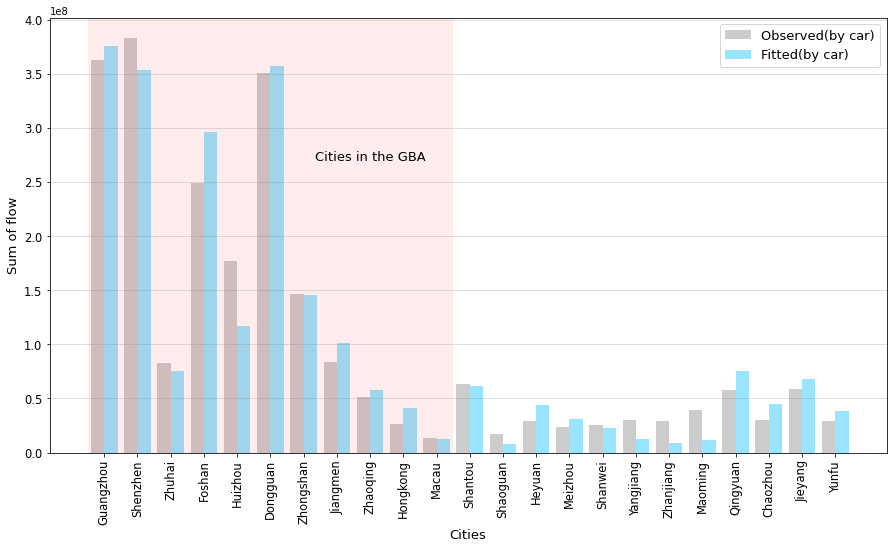

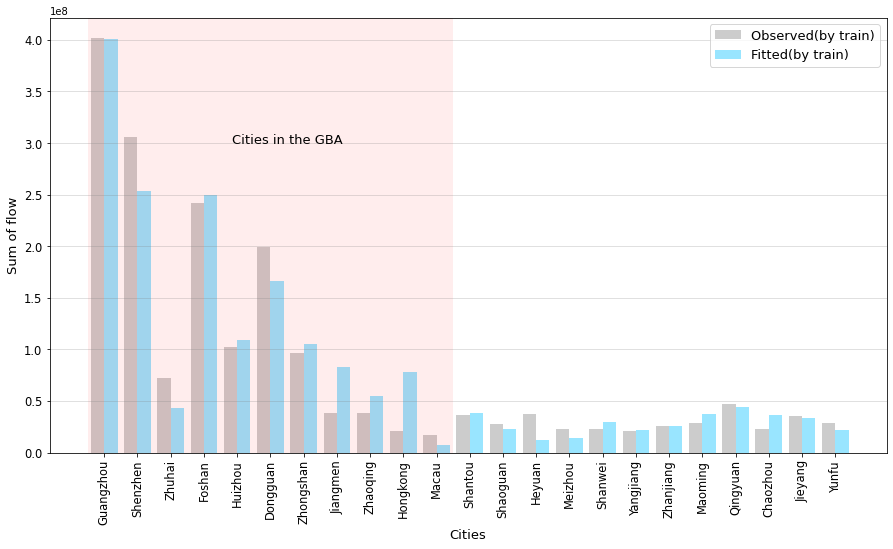

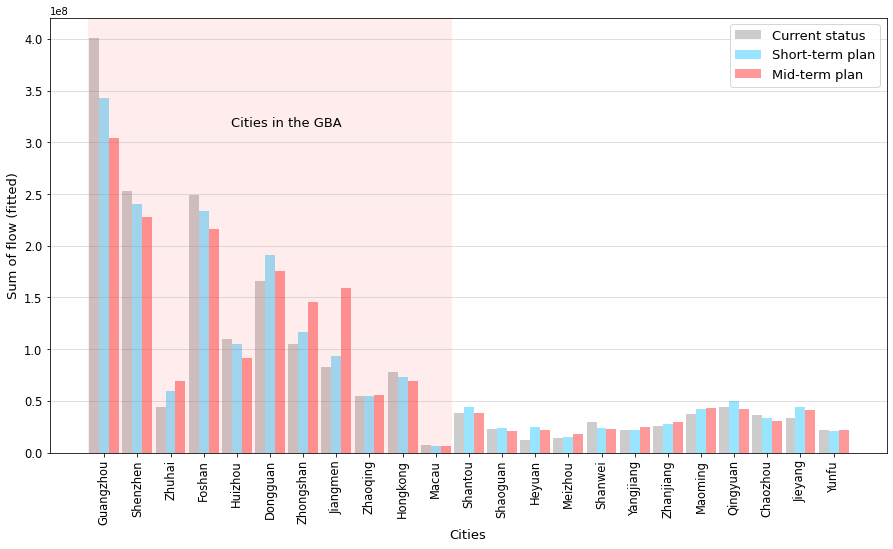

In [55]:
#PLOT TRAVEL FLOW bus！
fig = plt.figure(figsize=(15,8)) 
x = np.arange(len(ff_trainod))
width = 0.4
t1 = 'Cities in the GBA'
# plt.set_xlim(-1,22)
plt.bar(x - width/2,ff_od['Flowbus'],width,fc='grey',alpha=0.4,label =  'Observed(by car)')
plt.bar(x + width/2,ff_od['Fitted2bus'],width,fc='deepskyblue',alpha=0.4,label ='Fitted(by car)')
plt.xticks(x, labels=accessibility.index,rotation = 90,fontsize=11.5)
plt.yticks(fontsize = 11.5)
plt.grid(color='grey',alpha=0.3, axis = 'y' )
plt.xlabel("Cities",fontsize=13)
plt.ylabel("Sum of flow",fontsize=13)
plt.legend(loc='best',fontsize=13)
plt.axvspan(-0.5, 10.5, facecolor='red', alpha=0.07)
plt.text(8,270000000, t1, ha='center', rotation=0, alpha=1, wrap=True,fontsize=13) 
# plt.title('Flows by car')
plt.savefig('./pics/5Flows_by_car.jpg', dpi=150, bbox_inches='tight')
plt.show()


#PLOT TRAVEL FLOW train！
fig = plt.figure(figsize=(15,8)) 
x = np.arange(len(ff_trainod))
width = 0.4
t1 = 'Cities in the GBA'
# plt.set_xlim(-1,22)
plt.bar(x - width/2, ff_od['Flow'],width,fc='grey',alpha=0.4,label = 'Observed(by train)')
plt.bar(x + width/2, ff_od['Fitted2'],width,fc='deepskyblue',alpha=0.4,label = 'Fitted(by train)')
plt.xticks(x, labels=accessibility.index,rotation = 90,fontsize=11.5) 
plt.yticks(fontsize = 11.5)
plt.grid(color='grey',alpha=0.3, axis = 'y' )
plt.xlabel("Cities",fontsize=13)
plt.ylabel("Sum of flow",fontsize=13)
plt.legend(loc='best',fontsize=13)
plt.axvspan(-0.5, 10.5, facecolor='red', alpha=0.07)
plt.text(5.5,300000000, t1, ha='center', rotation=0, alpha=1, wrap=True,fontsize=13) 
# plt.title('Flows by train')
plt.savefig('./pics/6Flows_by_train.jpg', dpi=150, bbox_inches='tight')
plt.show()

#PLOT TRAVEL FLOW fitted！
fig = plt.figure(figsize=(15,8)) 
x = np.arange(len(ff_trainod))
width = 0.3
t1 = 'Cities in the GBA'
# plt.set_xlim(-1,22)
plt.bar(x - width,ff_od['Fitted2'],width,fc='grey',alpha=0.4,label = 'Current status')
plt.bar(x,ff_od['Fitted_st'],width,fc='deepskyblue',alpha=0.4,label = 'Short-term plan')# ning scenario
# plt.plot(x,(ff_od['Fitted_lt']-ff_od['Fitted_st']),color = 'c',alpha=0.4)#,label = 'Short-term planning scenario')
plt.bar(x + width,ff_od['Fitted_lt'],width,fc='red',alpha=0.4,label = 'Mid-term plan')# ning scenario
plt.xticks(x, labels=accessibility.index,rotation = 90,fontsize=11.5) 
plt.yticks(fontsize = 11.5)
plt.grid(color='grey',alpha=0.3, axis = 'y' )
plt.xlabel("Cities",fontsize=13)
plt.ylabel("Sum of flow (fitted)",fontsize=13)
plt.legend(loc='best',fontsize=13)
plt.axvspan(-0.5, 10.5, facecolor='red', alpha=0.07)
plt.text(5.5,315000000, t1, ha='center', rotation=0, alpha=1, wrap=True,fontsize=13) 
# plt.title('Flows by train')
plt.savefig('./pics/7Flows_by_train_fitted.jpg', dpi=150, bbox_inches='tight')
plt.show()

In [56]:
display(accessibility.head(3),ff_od.head(3),statistics.head(3),
       len(accessibility),len(ff_od),len(statistics))

,Car_Average,Train_Average_Time_Now,Train_Average_Time_ST,Train_Average_Time_LT,Car_Acc_Orig1,Train_Acc_Orig1,Train_Acc_Orig_st,Train_Acc_Orig_lt
City,,,,,,,,
Guangzhou,151.988768,79.217391,61.838004,60.173588,319.970218,846.795563,869.011748,870.599251
Shenzhen,164.741667,95.413043,82.363865,64.754401,299.981079,792.348891,813.421561,857.428897
Zhuhai,173.581159,162.282609,89.804968,73.711872,323.923490,376.857934,558.989551,650.336539


,Flow,Fitted2,Fitted_st,Fitted_lt,Flowbus,Fitted2bus
Orig,,,,,,
Guangzhou,401362908,4.005096e+08,3.425612e+08,3.041652e+08,363068973,3.757068e+08
Shenzhen,306109596,2.531295e+08,2.401683e+08,2.282241e+08,382659101,3.530162e+08
Zhuhai,72628729,4.365018e+07,5.962357e+07,6.935229e+07,83128353,7.568047e+07


,City,Car_From_Average,Car_To_Average_Time,Car_Average,Train_From_Average_Now,Train_To_Average_Now,Train_Average_Time_Now,Train_From_Average_ST,Train_To_Average_ST,Train_Average_Time_ST,Train_From_Average_LT,Train_To_Average_LT,Train_Average_Time_LT,Population,Labour_Force,GDP_Avg,GDP,Investment_in_Fixed_Assets,Foreign_Trade,RD_Investment,Housing_Price,Education,Car_Ownership,Highway_Length,Railway_Length_Now,Railway_Length_ST,Railway_Length_LT,Train_Average_Accessibility,Car_Average_Accessibility
0,Guangzhou,152.326087,151.651449,151.988768,78.173913,80.260870,79.217391,61.751047,61.924960,61.838004,60.086631,60.260544,60.173588,1530.59,1125.89,15.437576,23628.60,7462.123310,10003.51,6777377.5,31692,0.640276,1822.209736,5.879432,369.409827,537.759438,623.258648,75.915052,39.567347
1,Shenzhen,163.737681,165.745652,164.741667,95.086957,95.739130,95.413043,81.907343,82.820387,82.363865,64.341358,65.167445,64.754401,1343.88,1283.37,20.036826,26927.09,7374.709489,29780.61,13282828.5,54790,0.252999,2552.480132,0.547668,198.736617,220.065201,313.046736,63.047404,36.515016
2,Zhuhai,173.826812,173.335507,173.581159,160.260870,164.304348,162.282609,90.087577,89.522359,89.804968,74.407524,73.016220,73.711872,202.37,161.17,16.978258,3435.89,2128.427687,2908.54,1083104.9,21134,0.647329,3415.466719,7.229332,77.653960,96.441973,96.441973,5.138315,4.803857


23

23

23

# merge and standerdization

In [57]:
finaldata = accessibility.merge(ff_od,left_index = True,right_index = True)
listx = ['City','Population','Labour_Force','GDP_Avg','GDP','Investment_in_Fixed_Assets','Foreign_Trade','RD_Investment',
         'Housing_Price','Education','Car_Ownership','Highway_Length','Railway_Length_Now',
         'Railway_Length_ST','Railway_Length_LT']
finaldata = statistics[listx].merge(finaldata,right_index = True,left_on = 'City')

#d_time (should decrease)
finaldata['d_time_ct'] = finaldata ['Train_Average_Time_Now'] - finaldata['Car_Average'] # godown
finaldata['d_time_ns'] = finaldata['Train_Average_Time_ST'] - finaldata ['Train_Average_Time_Now'] 
finaldata['d_time_nl'] = finaldata['Train_Average_Time_LT'] - finaldata ['Train_Average_Time_Now']

#d_acc (should increase)
finaldata['d_acc_ct'] = finaldata ['Train_Acc_Orig1'] - finaldata['Car_Acc_Orig1'] #increase
finaldata['d_acc_ns'] = finaldata['Train_Acc_Orig_st'] - finaldata ['Train_Acc_Orig1']
finaldata['d_acc_nl'] = finaldata['Train_Acc_Orig_lt'] - finaldata ['Train_Acc_Orig1']

#d_flow (should increase)
finaldata['d_Flow_ct'] = finaldata ['Flow'] - finaldata['Flowbus'] #increase
finaldata['d_Flow_ns'] = finaldata['Fitted_st'] - finaldata ['Fitted2']
finaldata['d_Flow_nl'] = finaldata['Fitted_lt'] - finaldata ['Fitted2']
#finaldata['d_Flow_sl'] = finaldata['Fitted_lt'] - finaldata ['Fitted_st']

In [58]:
listx = ['d_time_ct','d_time_ns','d_time_nl','d_acc_ct','d_acc_ns','d_acc_nl','d_Flow_ct','d_Flow_ns','d_Flow_nl']#,'d_Flow_sl'
listx1 = []
for i in listx:
    finaldata[f"normed_{i}"] = (finaldata[i]-finaldata[i].min())/(finaldata[i].max() - finaldata[i].min())
    listx1.append(f"normed_{i}")
    listy = []
    maxindex = -1
    for index,row in finaldata.iterrows():
        if row[i] <= 0:
            listy.append(row[i])
    
    for index,row in finaldata.iterrows():
        if len(listy) == 0:
            break
        if row[i] == max(listy):
            maxindex = index
            break
    if maxindex != -1:
        finaldata[f"normed_{i}"] = finaldata[f"normed_{i}"] - finaldata.loc[maxindex,f"normed_{i}"]-0.02    
        
subset = finaldata[listx1]
subset.head(3)

,normed_d_time_ct,normed_d_time_ns,normed_d_time_nl,normed_d_acc_ct,normed_d_acc_ns,normed_d_acc_nl,normed_d_Flow_ct,normed_d_Flow_ns,normed_d_Flow_nl
0,-0.362987,-0.049635,-0.020000,0.980000,0.062128,0.011623,0.184603,-0.713813,-0.576392
1,-0.343778,-0.024321,-0.086735,0.914769,0.058469,0.123137,-0.422144,-0.171370,-0.160925
2,-0.020000,-0.371739,-0.419478,0.082887,0.573862,0.686154,-0.073186,0.177515,0.133392


In [59]:
finaldata.columns.tolist()

['City',
 'Population',
 'Labour_Force',
 'GDP_Avg',
 'GDP',
 'Investment_in_Fixed_Assets',
 'Foreign_Trade',
 'RD_Investment',
 'Housing_Price',
 'Education',
 'Car_Ownership',
 'Highway_Length',
 'Railway_Length_Now',
 'Railway_Length_ST',
 'Railway_Length_LT',
 'Car_Average',
 'Train_Average_Time_Now',
 'Train_Average_Time_ST',
 'Train_Average_Time_LT',
 'Car_Acc_Orig1',
 'Train_Acc_Orig1',
 'Train_Acc_Orig_st',
 'Train_Acc_Orig_lt',
 'Flow',
 'Fitted2',
 'Fitted_st',
 'Fitted_lt',
 'Flowbus',
 'Fitted2bus',
 'd_time_ct',
 'd_time_ns',
 'd_time_nl',
 'd_acc_ct',
 'd_acc_ns',
 'd_acc_nl',
 'd_Flow_ct',
 'd_Flow_ns',
 'd_Flow_nl',
 'normed_d_time_ct',
 'normed_d_time_ns',
 'normed_d_time_nl',
 'normed_d_acc_ct',
 'normed_d_acc_ns',
 'normed_d_acc_nl',
 'normed_d_Flow_ct',
 'normed_d_Flow_ns',
 'normed_d_Flow_nl']

In [60]:
#relative delta time
finaldata['rd_time_ct'] = finaldata['d_time_ct']/finaldata['Car_Average']
finaldata['rd_time_ns'] = finaldata['d_time_ns']/finaldata['Train_Average_Time_Now']
finaldata['rd_time_nl'] = finaldata['d_time_nl']/finaldata['Train_Average_Time_Now']
#relative delta acc
finaldata['rd_acc_ct'] = finaldata['d_acc_ct']/finaldata['Car_Acc_Orig1']
finaldata['rd_acc_ns'] = finaldata['d_acc_ns']/finaldata['Train_Acc_Orig1']
finaldata['rd_acc_nl'] = finaldata['d_acc_nl']/finaldata['Train_Acc_Orig1']
#relative delta flow
finaldata['rd_Flow_ct'] = finaldata['d_Flow_ct']/finaldata['Flowbus']
finaldata['rd_Flow_ns'] = finaldata['d_Flow_ns']/finaldata['Fitted2']
finaldata['rd_Flow_nl'] = finaldata['d_Flow_nl']/finaldata['Fitted2']

In [61]:
finaldata.columns.tolist()

['City',
 'Population',
 'Labour_Force',
 'GDP_Avg',
 'GDP',
 'Investment_in_Fixed_Assets',
 'Foreign_Trade',
 'RD_Investment',
 'Housing_Price',
 'Education',
 'Car_Ownership',
 'Highway_Length',
 'Railway_Length_Now',
 'Railway_Length_ST',
 'Railway_Length_LT',
 'Car_Average',
 'Train_Average_Time_Now',
 'Train_Average_Time_ST',
 'Train_Average_Time_LT',
 'Car_Acc_Orig1',
 'Train_Acc_Orig1',
 'Train_Acc_Orig_st',
 'Train_Acc_Orig_lt',
 'Flow',
 'Fitted2',
 'Fitted_st',
 'Fitted_lt',
 'Flowbus',
 'Fitted2bus',
 'd_time_ct',
 'd_time_ns',
 'd_time_nl',
 'd_acc_ct',
 'd_acc_ns',
 'd_acc_nl',
 'd_Flow_ct',
 'd_Flow_ns',
 'd_Flow_nl',
 'normed_d_time_ct',
 'normed_d_time_ns',
 'normed_d_time_nl',
 'normed_d_acc_ct',
 'normed_d_acc_ns',
 'normed_d_acc_nl',
 'normed_d_Flow_ct',
 'normed_d_Flow_ns',
 'normed_d_Flow_nl',
 'rd_time_ct',
 'rd_time_ns',
 'rd_time_nl',
 'rd_acc_ct',
 'rd_acc_ns',
 'rd_acc_nl',
 'rd_Flow_ct',
 'rd_Flow_ns',
 'rd_Flow_nl']

In [61]:
finaldata.to_excel('finaldata.xlsx')

# Classification   

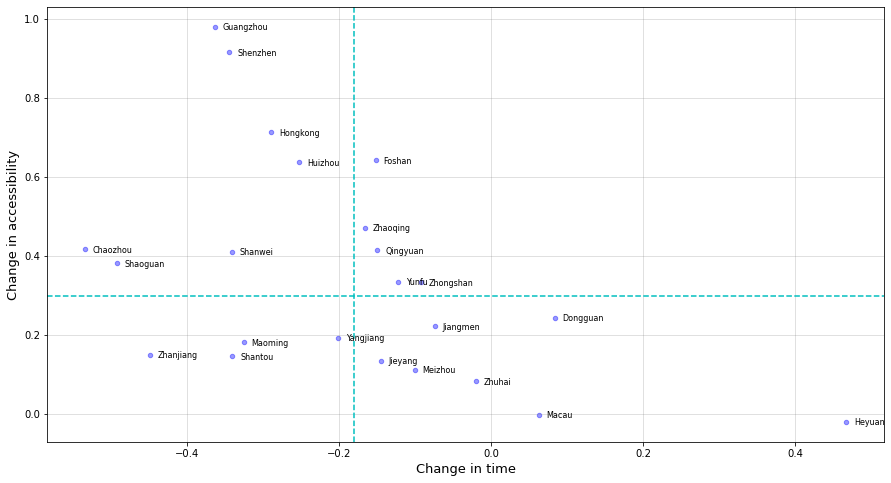

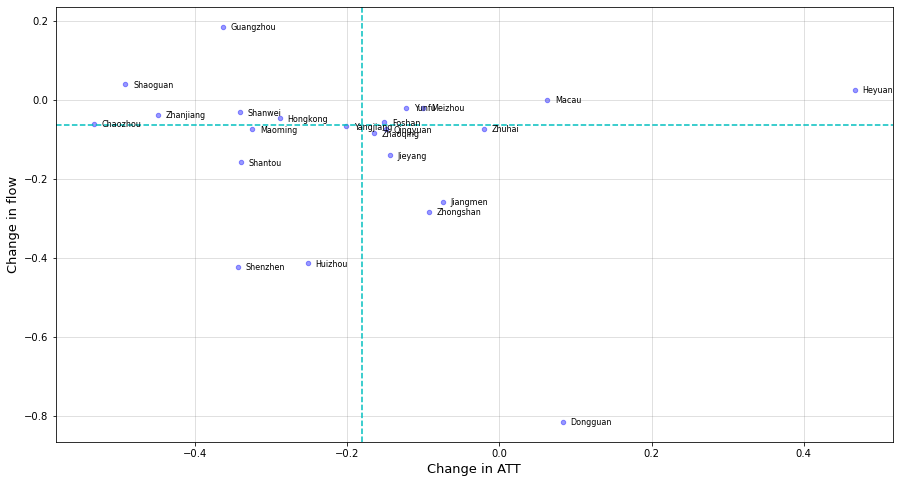

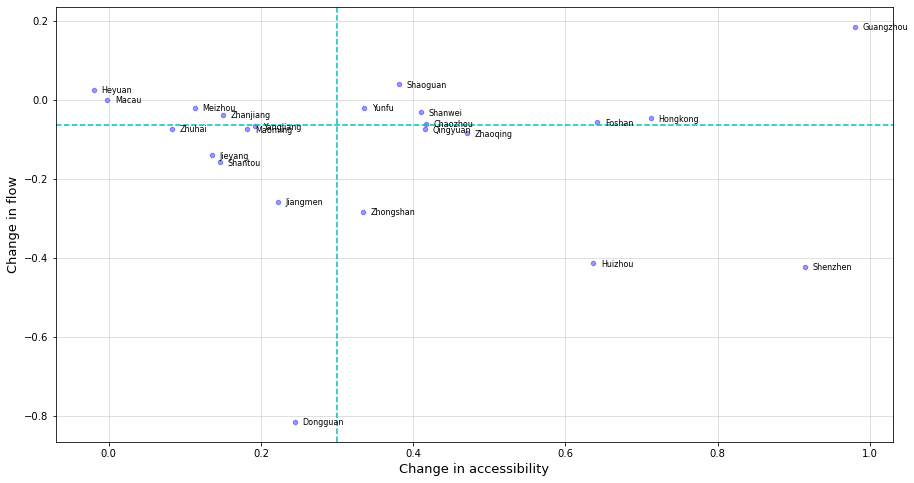

In [75]:
#Plot acc change vs time change
fig = plt.figure(figsize=(15,8)) 
x = finaldata['normed_d_time_ct']
y = finaldata['normed_d_acc_ct']
plt.scatter(x,y, alpha=0.4,marker='o',color='b',s=20)
for i in range(len(x)):
    plt.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
plt.grid(color='grey',alpha=0.3, axis = 'both' )
plt.axvline(x=-0.18, color='c', linestyle='--')#
plt.axhline(y=0.3, color='c', linestyle='--')#
plt.xlabel("Change in time",fontsize=13)
plt.ylabel("Change in accessibility",fontsize=13)
#plt.title('Accessibility change VS time change between car and train (normalized)')
#plt.savefig('./pics/xxAccessibility change VS time change between car and train (normalized).jpg')
plt.show()


#Plot flow change vs time change
fig = plt.figure(figsize=(15,8)) 
x = finaldata['normed_d_time_ct']
y = finaldata['normed_d_Flow_ct']
plt.scatter(x,y, alpha=0.4,marker='o',color='b',s=20)
for i in range(len(x)):
    plt.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
plt.grid(color='grey',alpha=0.3, axis = 'both' )
plt.axvline(x=-0.18, color='c', linestyle='--')#
plt.axhline(y=-0.065, color='c', linestyle='--')#
plt.xlabel("Change in ATT",fontsize=13)
plt.ylabel("Change in flow",fontsize=13)
# plt.title('Flow change VS time change between car and train (normalized)')
#plt.savefig('./pics/xxFlow change VS time change between car and train (normalized).jpg', dpi=150, bbox_inches='tight')
plt.show()

#Plot flow change vs acc change
fig = plt.figure(figsize=(15,8)) 
x = finaldata['normed_d_acc_ct']
y =  finaldata['normed_d_Flow_ct']
plt.scatter(x,y, alpha=0.4,marker='o',color='b',s=20)
for i in range(len(x)):
    plt.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
plt.grid(color='grey',alpha=0.3, axis = 'both' )
plt.axvline(x=0.3, color='c', linestyle='--')#
plt.axhline(y=-0.065, color='c', linestyle='--')#
plt.xlabel("Change in accessibility",fontsize=13)
plt.ylabel("Change in flow",fontsize=13)
# plt.title('Flow change VS accessibility change between car and train (normalized)')
#plt.savefig('./pics/xxFlow change VS accessibility change between car and train (normalized).jpg', dpi=150, bbox_inches='tight')
plt.show()

#Plot flow change vs time change and acc change
# fig = plt.figure(figsize = (15,8))
# ax = fig.add_subplot(111,projection='3d')
# x = finaldata['normed_d_time_ct']
# y = finaldata['normed_d_acc_ct']
# z = finaldata['normed_d_Flow_ct']
# ax.scatter(x,y,z, alpha=0.4,marker='o',color='r')#,size=20
# ax.set_xlabel("Change in time",fontsize=13)
# ax.set_ylabel("Change in accessibility",fontsize=13)
# ax.set_zlabel("Change in flow",fontsize=13)
# plt.title('Flow change VS time change between car and train (normalized)')
# plt.savefig('./pics/xxFlow change VS time change between car and train (normalized).jpg', dpi=150, bbox_inches='tight')
# plt.show()

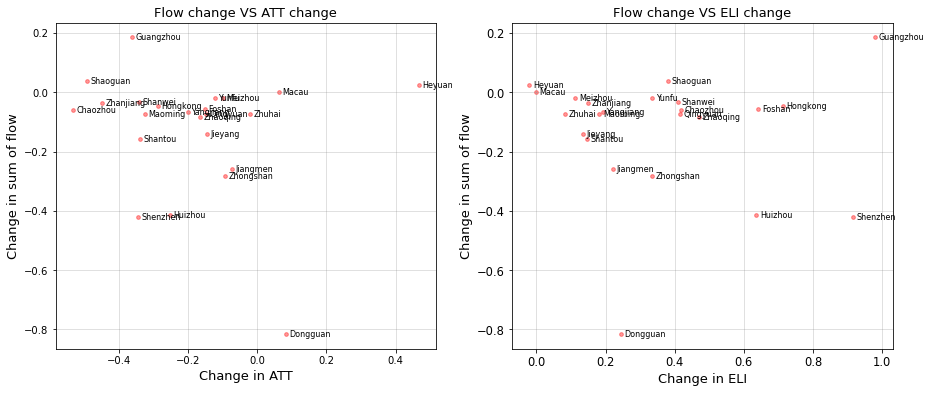

In [60]:
fig = plt.figure(figsize=(15,6))
ax1,ax2 = fig.add_subplot(121),fig.add_subplot(122)
#Plot flow change vs time change
x = finaldata['normed_d_time_ct']
y = finaldata['normed_d_Flow_ct']
ax1.scatter(x,y, alpha=0.4,marker='o',color='r',s=14)
for i in range(len(x)):
    ax1.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
ax1.grid(color='grey',alpha=0.3, axis = 'both' )
# ax1.axvline(x=-0.18, color='c', linestyle='--')#
# ax1.axhline(y=-0.065, color='c', linestyle='--')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax1.set_xlabel("Change in ATT",fontsize=13)
ax1.set_ylabel("Change in sum of flow",fontsize=13)
ax1.set_title('Flow change VS ATT change',fontsize=13)

#Plot flow change vs acc change
x = finaldata['normed_d_acc_ct']
y =  finaldata['normed_d_Flow_ct']
ax2.scatter(x,y, alpha=0.4,marker='o',color='r',s=14)
for i in range(len(x)):
    ax2.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
ax2.grid(color='grey',alpha=0.3, axis = 'both' )
# ax2.axvline(x=0.3, color='c', linestyle='--')
# ax2.axhline(y=-0.065, color='c', linestyle='--')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax2.set_xlabel("Change in ELI",fontsize=13)
ax2.set_ylabel("Change in sum of flow",fontsize=13)
ax2.set_title('Flow change VS ELI change',fontsize=13)
plt.savefig('./pics/8Flow change VS accessibility change between car and train (normalized).jpg', dpi=150, bbox_inches='tight')
plt.show()

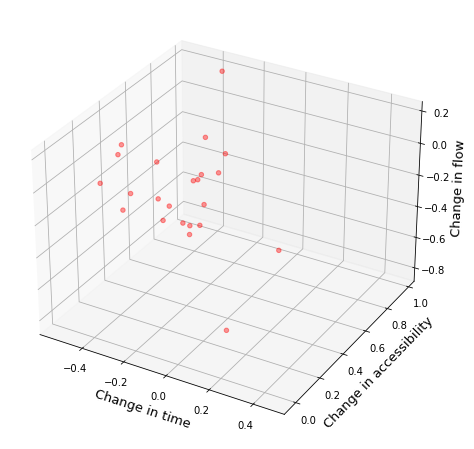

In [61]:
#Plot flow change vs time change and acc change
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111,projection='3d')
x = finaldata['normed_d_time_ct']
y = finaldata['normed_d_acc_ct']
z = finaldata['normed_d_Flow_ct']
ax.scatter(x,y,z, alpha=0.4,marker='o',color='r')
ax.set_xlabel("Change in time",fontsize=13)
ax.set_ylabel("Change in accessibility",fontsize=13)
ax.set_zlabel("Change in flow",fontsize=13)
# ax.title('Flow change VS time change between car and train (normalized)')
plt.savefig('./pics/9Flow change VS time and acc change between car and train (normalized).jpg', dpi=150, bbox_inches='tight')
plt.show()

In [62]:
finaldata['clusters_manualx'] = 'x'

for i,row in finaldata.iterrows():
    if row['normed_d_time_ct'] < -0.18 and row['normed_d_acc_ct']> 0.4:
        finaldata.loc[i,'clusters_manualx'] = 'Successful'
#         if row['normed_d_acc_ct'] > 0.43:
#             finaldata.loc[i,'clusters_manualx'] = 'Super successful' 
    elif row['normed_d_time_ct'] < -0.18 and row['normed_d_acc_ct']< 0.4:
        finaldata.loc[i,'clusters_manualx'] = 'Unsuccessful'
#         if row['normed_d_acc_ct'] < 0.187:
#             finaldata.loc[i,'clusters_manualx'] = 'Super unsuccessful' 
    elif row['normed_d_acc_ct'] > 0.24:
        finaldata.loc[i,'clusters_manualx'] = 'potential'
#         if row['normed_d_acc_ct'] > 0.43:
#             finaldata.loc[i,'clusters_manualx'] = 'Super potential' 
    else:
        finaldata.loc[i,'clusters_manualx']= 'unclear'
#         if row['normed_d_acc_ct'] < 0.22:
#             finaldata.loc[i,'clusters_manualx'] = 'Very unclear' 

#finaldata[['City','clusters_manualx']] 
list(set(finaldata['clusters_manualx']))        

['unclear', 'Unsuccessful', 'Successful', 'potential']

In [63]:
finaldata.columns

Index(['City', 'Population', 'Labour_Force', 'GDP_Avg', 'GDP',
       'Investment_in_Fixed_Assets', 'Foreign_Trade', 'RD_Investment',
       'Housing_Price', 'Education', 'Car_Ownership', 'Highway_Length',
       'Railway_Length_Now', 'Railway_Length_ST', 'Railway_Length_LT',
       'Car_Average', 'Train_Average_Time_Now', 'Train_Average_Time_ST',
       'Train_Average_Time_LT', 'Car_Acc_Orig1', 'Train_Acc_Orig1',
       'Train_Acc_Orig_st', 'Train_Acc_Orig_lt', 'Flow', 'Fitted2',
       'Fitted_st', 'Fitted_lt', 'Flowbus', 'Fitted2bus', 'd_time_ct',
       'd_time_ns', 'd_time_nl', 'd_acc_ct', 'd_acc_ns', 'd_acc_nl',
       'd_Flow_ct', 'd_Flow_ns', 'd_Flow_nl', 'normed_d_time_ct',
       'normed_d_time_ns', 'normed_d_time_nl', 'normed_d_acc_ct',
       'normed_d_acc_ns', 'normed_d_acc_nl', 'normed_d_Flow_ct',
       'normed_d_Flow_ns', 'normed_d_Flow_nl', 'rd_time_ct', 'rd_time_ns',
       'rd_time_nl', 'rd_acc_ct', 'rd_acc_ns', 'rd_acc_nl', 'rd_Flow_ct',
       'rd_Flow_ns', 'rd_Flo

In [64]:
#finaldata[['City','rd_Flow_ct','clusters_manualx']]

In [65]:
finaldata['clusters_manualx'].value_counts()

unclear         6
Successful      6
potential       6
Unsuccessful    5
Name: clusters_manualx, dtype: int64

In [66]:
# finaldata['clusters_manual'] = 'x'

# for i,row in finaldata.iterrows():
#     if row['normed_d_time_ct'] < -0.18 and row['normed_d_Flow_ct']> -0.065:
#         finaldata.loc[i,'clusters_manual'] = 'Successful'
# #         if row['normed_d_acc_ct'] > 0.43:
# #             finaldata.loc[i,'clusters_manual'] = 'Super successful' 
#     elif row['normed_d_time_ct'] < -0.18 and row['normed_d_Flow_ct']< -0.065:
#         finaldata.loc[i,'clusters_manual'] = 'Unsuccessful'
# #         if row['normed_d_acc_ct'] < 0.187:
# #             finaldata.loc[i,'clusters_manual'] = 'Super unsuccessful' 
#     elif row['normed_d_Flow_ct'] > -0.065:
#         finaldata.loc[i,'clusters_manual'] = 'potential'
# #         if row['normed_d_acc_ct'] > 0.43:
# #             finaldata.loc[i,'clusters_manual'] = 'Super potential' 
#     else:
#         finaldata.loc[i,'clusters_manual']= 'unclear'
# #         if row['normed_d_acc_ct'] < 0.22:
# #             finaldata.loc[i,'clusters_manual'] = 'Very unclear' 

# #finaldata[['City','clusters_manual']] 
# list(set(finaldata['clusters_manual']))  
# finaldata['clusters_manual'].value_counts()

# Same Classification for planning scenes     

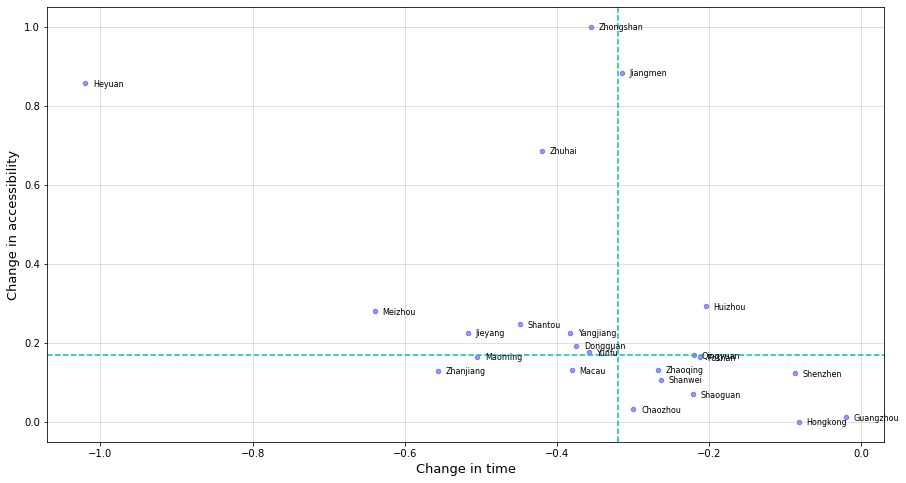

In [67]:
#Plot acc change vs time change
fig = plt.figure(figsize=(15,8)) 
x = finaldata['normed_d_time_nl']
y = finaldata['normed_d_acc_nl']
plt.scatter(x,y, alpha=0.4,marker='o',color='b',s=20)
for i in range(len(x)):
    plt.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
plt.grid(color='grey',alpha=0.3, axis = 'both' )
plt.axvline(x=-0.32, color='c', linestyle='--')#
plt.axhline(y=0.17, color='c', linestyle='--')#
plt.xlabel("Change in time",fontsize=13)
plt.ylabel("Change in accessibility",fontsize=13)
#plt.title('Accessibility change VS time change between car and train (normalized)')
#plt.savefig('./pics/xxAccessibility change VS time change between car and train (normalized).jpg')
plt.show()


In [68]:
finaldata['clusters_manual_ns'] = 'x'
for i,row in finaldata.iterrows():
    if row['normed_d_time_ns'] < -0.285 and row['normed_d_acc_ns']>0.15:
        finaldata.loc[i,'clusters_manual_ns'] = 'Successful'
#         if row['normed_d_acc_nl'] > 0.8:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Super successful' 
    elif row['normed_d_time_ns'] <  -0.285 and row['normed_d_acc_ns']< 0.15:
        finaldata.loc[i,'clusters_manual_ns'] = 'Unsuccessful'
#         if row['normed_d_acc_nl'] < 0.15:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Super unsuccessful' 
    elif row['normed_d_acc_ns'] > 0.15:
        finaldata.loc[i,'clusters_manual_ns'] = 'potential'
#         if row['normed_d_acc_nl'] > 0.8:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Super potential' 
    else:
        finaldata.loc[i,'clusters_manual_ns']= 'unclear'
#         if row['normed_d_acc_nl'] < 0.03:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Very unclear' 
#display(finaldata[['City','clusters_manual_nl']],list(set(finaldata['clusters_manual_nl'])) )       

In [69]:
finaldata[ 'clusters_manual_ns'].value_counts()

unclear         6
Unsuccessful    6
Successful      6
potential       5
Name: clusters_manual_ns, dtype: int64

In [70]:
finaldata['clusters_manual_nl'] = 'x'
for i,row in finaldata.iterrows():
    if row['normed_d_time_nl'] < -0.3255 and row['normed_d_acc_nl']> 0.22550:
        finaldata.loc[i,'clusters_manual_nl'] = 'Successful'
#         if row['normed_d_acc_nl'] > 0.8:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Super successful' 
    elif row['normed_d_time_nl'] < -0.3255 and row['normed_d_acc_nl']< 0.22550:
        finaldata.loc[i,'clusters_manual_nl'] = 'Unsuccessful'
#         if row['normed_d_acc_nl'] < 0.15:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Super unsuccessful' 
    elif row['normed_d_acc_nl'] > 0.115:
        finaldata.loc[i,'clusters_manual_nl'] = 'potential'
#         if row['normed_d_acc_nl'] > 0.8:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Super potential' 
    else:
        finaldata.loc[i,'clusters_manual_nl']= 'unclear'
#         if row['normed_d_acc_nl'] < 0.03:
#             finaldata.loc[i,'clusters_manual_nl'] = 'Very unclear' 
#display(finaldata[['City','clusters_manual_nl']],list(set(finaldata['clusters_manual_nl'])) )       

In [71]:
finaldata[ 'clusters_manual_nl'].value_counts()

potential       6
Unsuccessful    6
Successful      6
unclear         5
Name: clusters_manual_nl, dtype: int64

In [72]:
finaldata[['City','rd_Flow_nl','clusters_manual_nl']]

,City,rd_Flow_nl,clusters_manual_nl
0,Guangzhou,-0.240555,unclear
1,Shenzhen,-0.098390,potential
2,Zhuhai,0.588820,Successful
3,Shantou,0.009679,Successful
4,Foshan,-0.132350,potential
5,Shaoguan,-0.094203,unclear
6,Heyuan,0.898745,Successful
7,Meizhou,0.249775,Successful
8,Huizhou,-0.166045,potential
9,Shanwei,-0.240309,unclear


# Clustering     

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
subset = finaldata[['City','normed_d_time_ct','normed_d_acc_ct','normed_d_Flow_ct']]
subset = subset.set_index('City')
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(subset)

    list_SSE.append(km.inertia_)
# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
#Clustering
km = KMeans(n_clusters = 5, n_init = 23, random_state=0)
km.fit(subset)
finaldata['clusters'] = km.labels_.tolist()

In [ ]:
#Plot flow change vs time change and acc change
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121,projection='3d')
x = finaldata['normed_d_time_ct']
y = finaldata['normed_d_acc_ct']
z = finaldata['normed_d_Flow_ct']
ax1.scatter(x,y,z, alpha=0.4,marker='o',color='r')#,size=20
ax1.set_xlabel("Change in time")
ax1.set_ylabel("Change in accessibility")
ax1.set_zlabel("Change in flow")


ax2 = fig.add_subplot(122,projection='3d')
x = 'normed_d_time_ct'
y = 'normed_d_acc_ct'
z = 'normed_d_Flow_ct'
ax2.scatter(finaldata.loc[finaldata.clusters==0][x],finaldata.loc[finaldata.clusters==0][y],
            finaldata.loc[finaldata.clusters==0][z],label='1',marker='o',color='b')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==1][x],finaldata.loc[finaldata.clusters==1][y],
            finaldata.loc[finaldata.clusters==1][z],label='2',marker='o',color='r')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==2][x],finaldata.loc[finaldata.clusters==2][y],
            finaldata.loc[finaldata.clusters==2][z],label='3',marker='o',color='y')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==3][x],finaldata.loc[finaldata.clusters==3][y],
            finaldata.loc[finaldata.clusters==3][z],label='4',marker='o',color='g')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==4][x], finaldata.loc[finaldata.clusters==4][y],
            finaldata.loc[finaldata.clusters==4][z],label='5',marker='o',color='c')#,s=5)
ax2.set_xlabel("Change in time")
ax2.set_ylabel("Change in accessibility")
ax2.set_zlabel("Change in flow")

fig.suptitle('Flow change VS time change between car and train')
plt.show()

In [ ]:
#Plot flow change vs time change and acc change
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
x = 'normed_d_time_ct'
y = 'normed_d_Flow_ct'
ax1.scatter(finaldata.loc[finaldata.clusters==0][x],finaldata.loc[finaldata.clusters==0][y],label='1',marker='o',color='b',s=5)
ax1.scatter(finaldata.loc[finaldata.clusters==1][x],finaldata.loc[finaldata.clusters==1][y],label='2',marker='o',color='r',s=5)
ax1.scatter(finaldata.loc[finaldata.clusters==2][x],finaldata.loc[finaldata.clusters==2][y],label='3',marker='o',color='y',s=5)
ax1.scatter(finaldata.loc[finaldata.clusters==3][x],finaldata.loc[finaldata.clusters==3][y],label='4',marker='o',color='g',s=5)
ax1.scatter(finaldata.loc[finaldata.clusters==4][x],finaldata.loc[finaldata.clusters==4][y],label='5',marker='o',color='c',s=5)
ax1.axvline(x=-0.18, color='grey', linestyle='--')
ax1.axhline(y=-0.065, color='grey', linestyle='--')
# for i in range(len(finaldata)):
#     ax1.annotate(finaldata.loc[i,'City'], xy = (finaldata[x][i], finaldata[y][i]), 
#                  xytext = (finaldata[x][i]+0.01, finaldata[y][i]-0.008),fontsize=8,alpha = 0.5)
ax1.grid(color='grey',alpha=0.3)# axis = 'y' )
ax1.set_xlabel("Change in time")
ax1.set_ylabel("Change in flow")


ax2 = fig.add_subplot(122)
x = 'normed_d_acc_ct'
z = 'normed_d_Flow_ct'
ax2.scatter(finaldata.loc[finaldata.clusters==0][x], finaldata.loc[finaldata.clusters==0][y],label='1',marker='o',color='b',s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==1][x], finaldata.loc[finaldata.clusters==1][y],label='2',marker='o',color='r',s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==2][x], finaldata.loc[finaldata.clusters==2][y],label='3',marker='o',color='y',s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==3][x], finaldata.loc[finaldata.clusters==3][y],label='4',marker='o',color='g',s=5)
ax2.scatter(finaldata.loc[finaldata.clusters==4][x], finaldata.loc[finaldata.clusters==4][y],label='5',marker='o',color='c',s=5)
ax2.axvline(x=0.3, color='grey', linestyle='--')
ax2.axhline(y=-0.065, color='grey', linestyle='--')
# for i in range(len(finaldata)):
#     ax2.annotate(finaldata.loc[i,'City'], xy = (finaldata[x][i], finaldata[y][i]),
#                  xytext = (finaldata[x][i]+0.01, finaldata[y][i]-0.008),fontsize=8,alpha = 0.5)
ax2.grid(color='grey',alpha=0.3)#, axis = 'y' 
ax2.set_xlabel("Change in accessibility")
ax2.set_ylabel("Change in flow")

#fig.suptitle('Flow change VS time,accessibility change between car and train')
plt.show()

# Same Clusering for planning scenes   

In [ ]:
subset1 = finaldata[['City','normed_d_time_nl','normed_d_acc_nl','normed_d_Flow_nl']]
subset1 = subset1.set_index('City')
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km1 = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km1.fit(subset1)

    list_SSE.append(km1.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


In [ ]:
km1 = KMeans(n_clusters = 6, n_init = 23, random_state=0)
km1.fit(subset)
finaldata['clusters1'] = km1.labels_.tolist()
#subset['clusters']=subset['clusters'].map(lambda x : x+1)

In [ ]:
#Plot acc change vs time change
fig = plt.figure(figsize=(12,7)) 
x = finaldata['normed_d_time_nl']
y =  finaldata['normed_d_acc_nl']
plt.scatter(x,y, alpha=0.4,marker='o',color='b',s=20)
for i in range(len(x)):
    plt.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
plt.grid(color='grey',alpha=0.3, axis = 'both' )
# plt.axvline(x=-0.18, color='c', linestyle='--')#
# plt.axhline(y=0.3, color='c', linestyle='--')#
plt.xlabel("Change in time")
plt.ylabel("Change in accessibility")
plt.title('Accessibility change VS time change by HSR between current status and mid-term planning scenario (normalized)')
plt.show()

#Plot flow change vs time change
fig = plt.figure(figsize=(12,7)) 
x = finaldata['normed_d_time_nl']
y =  finaldata['normed_d_Flow_nl']
plt.scatter(x,y, alpha=0.4,marker='o',color='b',s=20)
for i in range(len(x)):
    plt.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
plt.grid(color='grey',alpha=0.3, axis = 'both' )
# plt.axvline(x=-0.18, color='c', linestyle='--')#
# plt.axhline(y=-0.065, color='c', linestyle='--')#
plt.xlabel("Change in time")
plt.ylabel("Change in flow")
plt.title('Flow change VS time change by HSR between current status and mid-term planning scenario (normalized)')
plt.show()

#Plot flow change vs acc change
fig = plt.figure(figsize=(12,7)) 
x = finaldata['normed_d_acc_nl']
y =  finaldata['normed_d_Flow_nl']
plt.scatter(x,y, alpha=0.4,marker='o',color='b',s=20)
for i in range(len(x)):
    plt.annotate(finaldata.loc[i,'City'], xy = (x[i], y[i]), xytext = (x[i]+0.01, y[i]-0.008),fontsize=8)
plt.grid(color='grey',alpha=0.3, axis = 'both' )
# plt.axvline(x=0.3, color='c', linestyle='--')#
# plt.axhline(y=-0.065, color='c', linestyle='--')#
plt.xlabel("Change in accessibility")
plt.ylabel("Change in flow")
plt.title('Flow change VS accessibility change by HSR between current status and mid-term planning scenario (normalized)')
plt.show()

#Plot flow change vs time change and acc change
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111,projection='3d')
x = finaldata['normed_d_time_nl']
y = finaldata['normed_d_acc_nl']
z = finaldata['normed_d_Flow_nl']
ax.scatter(x,y,z, alpha=0.4,marker='o',color='r')#,size=20
ax.set_xlabel("Change in time")
ax.set_ylabel("Change in accessibility")
ax.set_zlabel("Change in flow")
plt.title('Flow change VS time change by HSR between current status and mid-term planning scenario (normalized)')
plt.show()

In [ ]:
#Plot flow change vs time change and acc change
fig = plt.figure(figsize = (17,8))
ax1 = fig.add_subplot(121,projection='3d')
x = finaldata['normed_d_time_nl']
y = finaldata['normed_d_acc_nl']
z = finaldata['normed_d_Flow_nl']
ax1.scatter(x,y,z, alpha=0.4,marker='o',color='r')#,size=20
ax1.set_xlabel("Change in time")
ax1.set_ylabel("Change in accessibility")
ax1.set_zlabel("Change in flow")


ax2 = fig.add_subplot(122,projection='3d')
x = 'normed_d_time_nl'
y = 'normed_d_acc_nl'
z = 'normed_d_Flow_nl'
ax2.scatter(finaldata.loc[finaldata.clusters1==0][x],finaldata.loc[finaldata.clusters1==0][y],
            finaldata.loc[finaldata.clusters1==0][z],label='1',marker='o',color='b')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters1==1][x],finaldata.loc[finaldata.clusters1==1][y],
            finaldata.loc[finaldata.clusters1==1][z],label='2',marker='o',color='r')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters1==2][x],finaldata.loc[finaldata.clusters1==2][y],
            finaldata.loc[finaldata.clusters1==2][z],label='3',marker='o',color='y')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters1==3][x],finaldata.loc[finaldata.clusters1==3][y],
            finaldata.loc[finaldata.clusters1==3][z],label='4',marker='o',color='g')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters1==4][x], finaldata.loc[finaldata.clusters1==4][y],
            finaldata.loc[finaldata.clusters1==4][z],label='5',marker='o',color='c')#,s=5)
ax2.scatter(finaldata.loc[finaldata.clusters1==5][x], finaldata.loc[finaldata.clusters1==5][y],
            finaldata.loc[finaldata.clusters1==5][z],label='6',marker='o',color='y')#,s=5)
# ax2.scatter(finaldata.loc[finaldata.clusters1==6][x], finaldata.loc[finaldata.clusters1==6][y],
#             finaldata.loc[finaldata.clusters1==6][z],label='7',marker='o',color='m')#,s=5)
ax2.set_xlabel("Change in time")
ax2.set_ylabel("Change in accessibility")
ax2.set_zlabel("Change in flow")
ax2.legend(loc="best")
fig.suptitle('Flow change VS time and accessibility change by HSR between current status and mid-term planning scenario (normalized)')
plt.show()

In [ ]:
#Plot flow change vs time change and acc change
fig = plt.figure(figsize = (17,7))
ax1 = fig.add_subplot(121)
x = 'normed_d_time_nl'
y = 'normed_d_Flow_nl'
ax1.scatter(finaldata.loc[finaldata.clusters1==0][x],finaldata.loc[finaldata.clusters1==0][y],
            label='1',marker='o',color='b',s=20)
ax1.scatter(finaldata.loc[finaldata.clusters1==1][x],finaldata.loc[finaldata.clusters1==1][y],
            label='2',marker='o',color='r',s=20)
ax1.scatter(finaldata.loc[finaldata.clusters1==2][x],finaldata.loc[finaldata.clusters1==2][y],
            label='3',marker='o',color='y',s=20)
ax1.scatter(finaldata.loc[finaldata.clusters1==3][x],finaldata.loc[finaldata.clusters1==3][y],
            label='4',marker='o',color='g',s=20)
ax1.scatter(finaldata.loc[finaldata.clusters1==4][x],finaldata.loc[finaldata.clusters1==4][y],
            label='5',marker='o',color='c',s=20)
ax1.scatter(finaldata.loc[finaldata.clusters1==5][x],finaldata.loc[finaldata.clusters1==5][y],
            label='6',marker='o',color='m',s=20)
ax1.axvline(x=-0.355, color='grey', linestyle='--')
ax1.axhline(y=0.088, color='grey', linestyle='--')
# for i in range(len(finaldata)):
#     ax1.annotate(finaldata.loc[i,'City'], xy = (finaldata[x][i], finaldata[y][i]), 
#                  xytext = (finaldata[x][i]+0.01, finaldata[y][i]-0.008),fontsize=8,alpha = 0.5)
ax1.grid(color='grey',alpha=0.3)# axis = 'y' )
ax1.legend(loc="best")
ax1.set_xlabel("Change in time")
ax1.set_ylabel("Change in flow")


ax2 = fig.add_subplot(122)
x = 'normed_d_acc_nl'
z = 'normed_d_Flow_nl'
ax2.scatter(finaldata.loc[finaldata.clusters1==0][x], finaldata.loc[finaldata.clusters1==0][y],
            label='1',marker='o',color='b',s=20)
ax2.scatter(finaldata.loc[finaldata.clusters1==1][x], finaldata.loc[finaldata.clusters1==1][y],
            label='2',marker='o',color='r',s=20)
ax2.scatter(finaldata.loc[finaldata.clusters1==2][x], finaldata.loc[finaldata.clusters1==2][y],
            label='3',marker='o',color='y',s=20)
ax2.scatter(finaldata.loc[finaldata.clusters1==3][x], finaldata.loc[finaldata.clusters1==3][y],
            label='4',marker='o',color='g',s=20)
ax2.scatter(finaldata.loc[finaldata.clusters1==4][x], finaldata.loc[finaldata.clusters1==4][y],
            label='5',marker='o',color='c',s=20)
ax2.scatter(finaldata.loc[finaldata.clusters1==5][x], finaldata.loc[finaldata.clusters1==5][y],
            label='6',marker='o',color='m',s=20)
ax2.axvline(x=0.175, color='grey', linestyle='--')
ax2.axvline(x=0.24, color='grey', linestyle='--')
ax2.axhline(y=0.088, color='grey', linestyle='--')
# for i in range(len(finaldata)):
#     ax2.annotate(finaldata.loc[i,'City'], xy = (finaldata[x][i], finaldata[y][i]),
#                  xytext = (finaldata[x][i]+0.01, finaldata[y][i]-0.008),fontsize=8,alpha = 0.5)
ax2.grid(color='grey',alpha=0.3)#, axis = 'y' 
ax2.legend(loc="best")
ax2.set_xlabel("Change in accessibility")
ax2.set_ylabel("Change in flow")

fig.suptitle('Flow change VS time,accessibility change between car and train')
plt.show()

# Delta time、acc VS GDP_AVERAGE in current status   XXX     

In [73]:
import seaborn as sns

In [74]:
finaldata.columns

Index(['City', 'Population', 'Labour_Force', 'GDP_Avg', 'GDP',
       'Investment_in_Fixed_Assets', 'Foreign_Trade', 'RD_Investment',
       'Housing_Price', 'Education', 'Car_Ownership', 'Highway_Length',
       'Railway_Length_Now', 'Railway_Length_ST', 'Railway_Length_LT',
       'Car_Average', 'Train_Average_Time_Now', 'Train_Average_Time_ST',
       'Train_Average_Time_LT', 'Car_Acc_Orig1', 'Train_Acc_Orig1',
       'Train_Acc_Orig_st', 'Train_Acc_Orig_lt', 'Flow', 'Fitted2',
       'Fitted_st', 'Fitted_lt', 'Flowbus', 'Fitted2bus', 'd_time_ct',
       'd_time_ns', 'd_time_nl', 'd_acc_ct', 'd_acc_ns', 'd_acc_nl',
       'd_Flow_ct', 'd_Flow_ns', 'd_Flow_nl', 'normed_d_time_ct',
       'normed_d_time_ns', 'normed_d_time_nl', 'normed_d_acc_ct',
       'normed_d_acc_ns', 'normed_d_acc_nl', 'normed_d_Flow_ct',
       'normed_d_Flow_ns', 'normed_d_Flow_nl', 'rd_time_ct', 'rd_time_ns',
       'rd_time_nl', 'rd_acc_ct', 'rd_acc_ns', 'rd_acc_nl', 'rd_Flow_ct',
       'rd_Flow_ns', 'rd_Flo

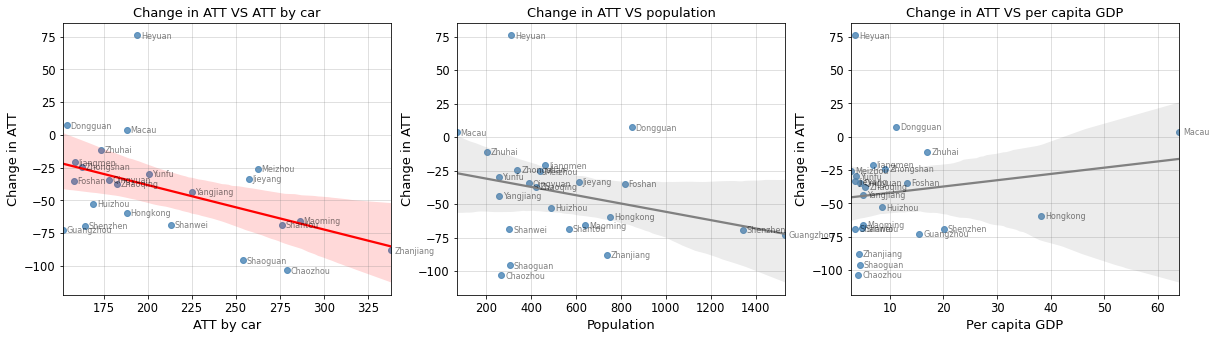

In [112]:
#Plot delta time VS GDP/GDP_AVERAGE 
fig = plt.figure(figsize = (20,5))

ax1 = fig.add_subplot(131)
sns.regplot( x='Car_Average',y='d_time_ct', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax1.set_ylabel('Change in ATT', fontsize = 13)
ax1.set_xlabel('ATT by car', fontsize = 13)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax1.grid(color='grey',alpha=0.3)
ax1.set_title('Change in ATT VS ATT by car', fontsize = 13)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = ( finaldata['Car_Average'][i],finaldata['d_time_ct'][i]),# 'Population'
                 xytext = (finaldata['Car_Average'][i]+2, finaldata['d_time_ct'][i]-2.3),fontsize=8,alpha = 0.5)

ax2 = fig.add_subplot(132)
sns.regplot( x='Population',y='d_time_ct', data=finaldata, ax=ax2, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax2.set_ylabel('Change in ATT', fontsize = 13)
ax2.set_xlabel('Population', fontsize = 13)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax2.grid(color='grey',alpha=0.3)
ax2.set_title('Change in ATT VS population', fontsize = 13)
for i in range(len(finaldata)):
    ax2.annotate(finaldata.loc[i,'City'], xy = ( finaldata['Population'][i],finaldata['d_time_ct'][i]),
                 xytext = (finaldata['Population'][i]+17, finaldata['d_time_ct'][i]-2.3),fontsize=8,alpha = 0.5)

ax3 = fig.add_subplot(133)
sns.regplot(x='GDP_Avg',y='d_time_ct', data=finaldata, ax=ax3, #GDP_Avg
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax3.set_ylabel('Change in ATT', fontsize = 13)
ax3.set_xlabel('Per capita GDP', fontsize = 13)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax3.grid(color='grey',alpha=0.3)
ax3.set_title('Change in ATT VS per capita GDP', fontsize = 13)
for i in range(len(finaldata)):
    ax3.annotate(finaldata.loc[i,'City'], xy = ( finaldata['GDP_Avg'][i],finaldata['d_time_ct'][i]),
                 xytext = ( finaldata['GDP_Avg'][i]+0.8,finaldata['d_time_ct'][i]-2.3),fontsize=8,alpha = 0.5)

plt.savefig('./pics/X1x Change in ATT between car and train VS population average GDP.jpg', dpi=150, bbox_inches='tight')
plt.show()

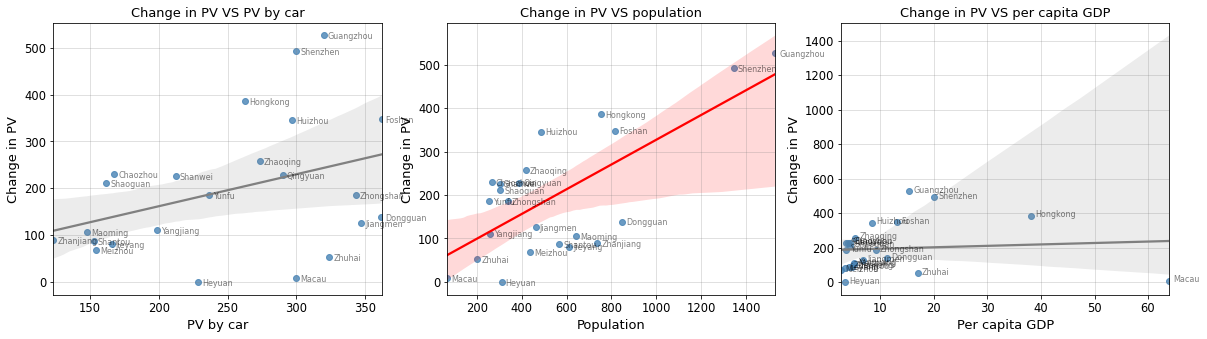

In [113]:
#Plot delta acc VS GDP/GDP_AVERAGE 
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(131)
sns.regplot(x='Car_Acc_Orig1', y='d_acc_ct', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax1.set_xlabel('PV by car', fontsize = 13)
ax1.set_ylabel('Change in PV', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax1.set_title('Change in PV VS PV by car', fontsize = 13)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = (finaldata['Car_Acc_Orig1'][i],finaldata['d_acc_ct'][i]),
                 xytext = (finaldata['Car_Acc_Orig1'][i]+3,finaldata['d_acc_ct'][i]-8), fontsize=8,alpha = 0.5)

ax2 = fig.add_subplot(132)
sns.regplot(x='Population', y='d_acc_ct', data=finaldata, ax=ax2, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax2.set_xlabel('Population', fontsize = 13)
ax2.set_ylabel('Change in PV', fontsize = 13)
ax2.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax2.set_title('Change in PV VS population', fontsize = 13)
for i in range(len(finaldata)):
    ax2.annotate(finaldata.loc[i,'City'], xy = (finaldata['Population'][i],finaldata['d_acc_ct'][i]),
                 xytext = (finaldata['Population'][i]+18,finaldata['d_acc_ct'][i]-8), fontsize=8,alpha = 0.5)

ax3 = fig.add_subplot(133)
sns.regplot(x='GDP_Avg', y='d_acc_ct', data=finaldata, ax=ax3, #GDP_Avg
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax3.set_xlabel('Per capita GDP', fontsize = 13)
ax3.set_ylabel('Change in PV', fontsize = 13)
ax3.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax3.set_title('Change in PV VS per capita GDP', fontsize = 13)
for i in range(len(finaldata)):
    ax3.annotate(finaldata.loc[i,'City'], xy = ( finaldata['GDP_Avg'][i],finaldata['d_acc_ct'][i]),
                 xytext = (finaldata['GDP_Avg'][i]+0.8,finaldata['d_acc_ct'][i]-8),fontsize=8,alpha = 0.5)
plt.savefig('./pics/X2x Change in accessibility between car and train VS population average GDP.jpg', dpi=150, bbox_inches='tight')
plt.show()

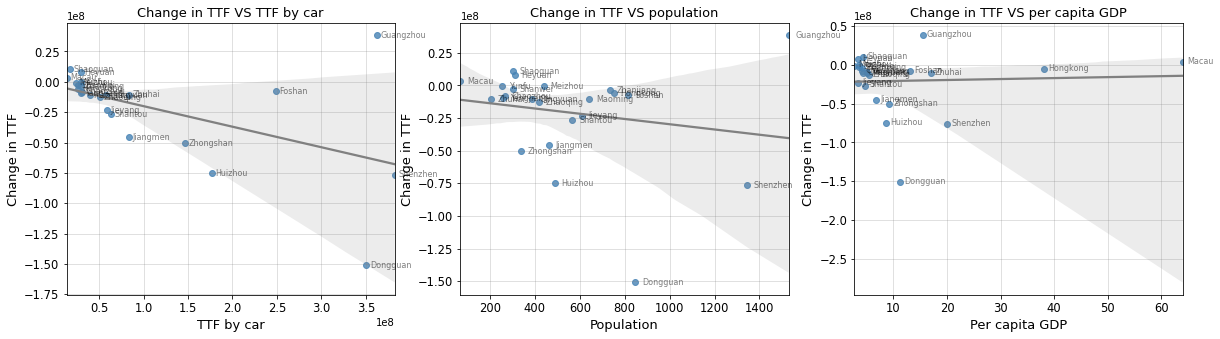

In [114]:
#Plot delta flow VS GDP/GDP_AVERAGE 

fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(131)
sns.regplot(x='Flowbus', y='d_Flow_ct', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax1.set_xlabel('TTF by car', fontsize = 13)
ax1.set_ylabel('Change in TTF', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = ( finaldata['Flowbus'][i],finaldata['d_Flow_ct'][i]),
                 xytext = ( finaldata['Flowbus'][i]+4000000,finaldata['d_Flow_ct'][i]-2000000),fontsize=8,alpha = 0.5)
ax1.set_title('Change in TTF VS TTF by car', fontsize = 13)

ax2 = fig.add_subplot(132)
sns.regplot(x='Population', y='d_Flow_ct', data=finaldata, ax=ax2, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax2.set_xlabel('Population', fontsize = 13)
ax2.set_ylabel('Change in TTF', fontsize = 13)
ax2.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax2.annotate(finaldata.loc[i,'City'], xy = ( finaldata['Population'][i],finaldata['d_Flow_ct'][i]),
                 xytext = ( finaldata['Population'][i]+30,finaldata['d_Flow_ct'][i]-2000000),fontsize=8,alpha = 0.5)
ax2.set_title('Change in TTF VS population', fontsize = 13)

ax3 = fig.add_subplot(133)
sns.regplot(x='GDP_Avg', y='d_Flow_ct', data=finaldata, ax=ax3, #GDP_Avg
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax3.set_xlabel('Per capita GDP', fontsize = 13)
ax3.set_ylabel('Change in TTF', fontsize = 13)
ax3.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax3.annotate(finaldata.loc[i,'City'], xy = ( finaldata['GDP_Avg'][i],finaldata['d_Flow_ct'][i]),
                 xytext = (finaldata['GDP_Avg'][i]+0.8, finaldata['d_Flow_ct'][i]-2000000),fontsize=8,alpha = 0.5)
ax3.set_title('Change in TTF VS per capita GDP', fontsize = 13)
#fig.suptitle('Flow change between car and train VS population, average GDP')
plt.savefig('./pics/X3x Change in flow between car and train VS population average GDP.jpg', dpi=150, bbox_inches='tight')
plt.show()


In [117]:
# cc_corr = finaldata.corr(method='pearson')
cc_corr.to_excel('cccorr.xls') 

<ipython-input-117-7a59e8b38b43>:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  cc_corr.to_excel('cccorr.xls')


# Delta time、acc VS GDP/GDP_AVERAGE in planning scecnario xxxx 

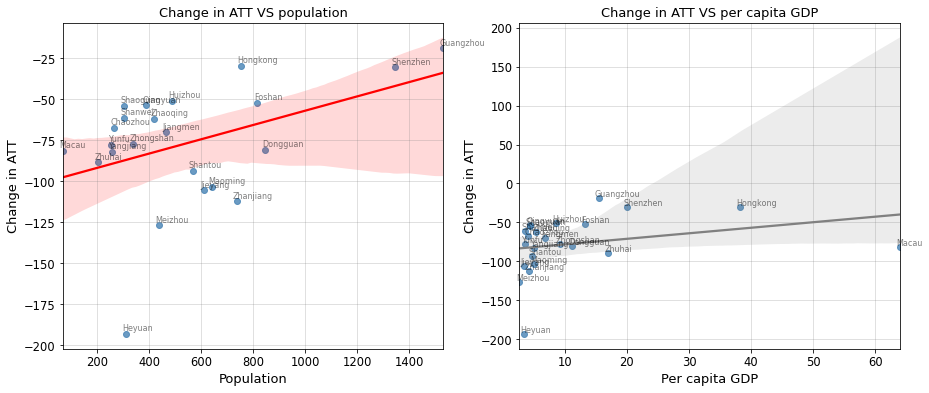

In [280]:
#Plot delta time VS GDP/GDP_AVERAGE in midterm planning
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
sns.regplot(x='Population', y='d_time_nl', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax1.set_xlabel('Population', fontsize = 13)
ax1.set_ylabel('Change in ATT', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = ( finaldata['Population'][i],finaldata['d_time_nl'][i]),
                 xytext = (finaldata['Population'][i]-14,finaldata['d_time_nl'][i]+2),fontsize=8,alpha = 0.5)
ax1.set_title('Change in ATT VS population', fontsize = 13)

ax3 = fig.add_subplot(122)
sns.regplot(x='GDP_Avg', y='d_time_nl', data=finaldata, ax=ax3, #GDP_Avg
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax3.set_xlabel('Per capita GDP', fontsize =13)
ax3.set_ylabel('Change in ATT', fontsize = 13)
ax3.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax3.annotate(finaldata.loc[i,'City'], xy = (finaldata['GDP_Avg'][i],finaldata['d_time_nl'][i]),
                 xytext = (finaldata['GDP_Avg'][i]-0.6, finaldata['d_time_nl'][i]+2),fontsize=8,alpha = 0.5)
ax3.set_title('Change in ATT VS per capita GDP', fontsize = 13)
plt.savefig('./pics/Y1 Change in ATT in planning scenario VS population average GDP.jpg', dpi=150, bbox_inches='tight')
plt.show()

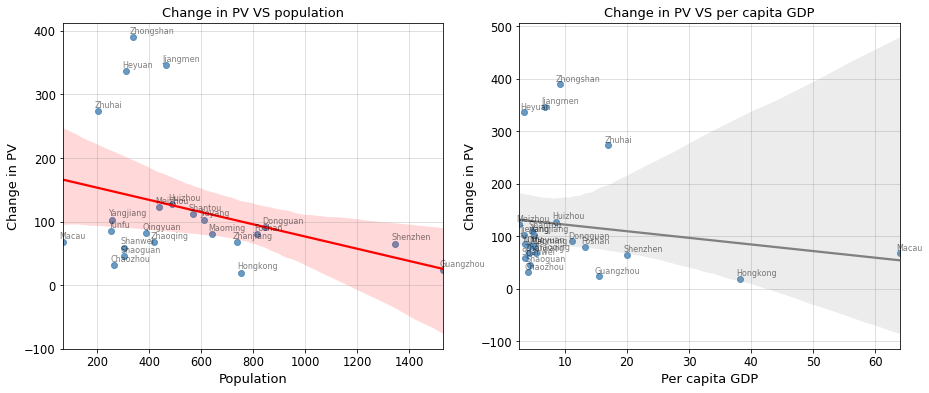

In [281]:
#Plot delta acc VS GDP/GDP_AVERAGE  in midterm planning
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
sns.regplot(x='Population', y='d_acc_nl', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax1.set_xlabel('Population', fontsize = 13)
ax1.set_ylabel('Change in PV', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax1.set_title('Change in PV VS population', fontsize = 13)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = ( finaldata['Population'][i],finaldata['d_acc_nl'][i]),
                 xytext = ( finaldata['Population'][i]-14,finaldata['d_acc_nl'][i]+6),fontsize=8,alpha = 0.5)

ax3 = fig.add_subplot(122)
sns.regplot(x='GDP_Avg', y='d_acc_nl', data=finaldata, ax=ax3, #GDP_Avg
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax3.set_xlabel('Per capita GDP', fontsize = 13)
ax3.set_ylabel('Change in PV', fontsize = 13)
ax3.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax3.set_title('Change in PV VS per capita GDP', fontsize = 13)
for i in range(len(finaldata)):
    ax3.annotate(finaldata.loc[i,'City'], xy = ( finaldata['GDP_Avg'][i],finaldata['d_acc_nl'][i]),
                 xytext = (finaldata['GDP_Avg'][i]-0.6, finaldata['d_acc_nl'][i]+6),fontsize=8,alpha = 0.5)

plt.savefig('./pics/Y2 Change in accessibility in planning scenario VS population average GDP.jpg', dpi=150, bbox_inches='tight')
plt.show()

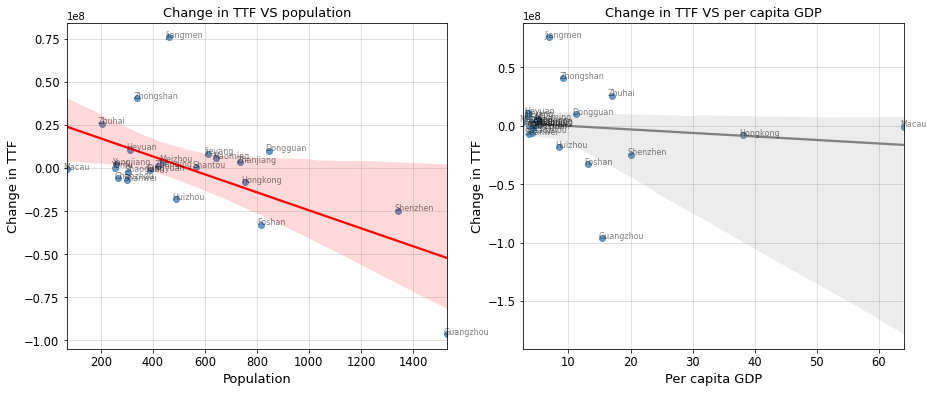

In [282]:
#Plot delta flow VS GDP/GDP_AVERAGE in midterm planning
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
sns.regplot(x='Population', y='d_Flow_nl', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax1.set_xlabel('Population', fontsize = 13)
ax1.set_ylabel('Change in TTF', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax1.set_title('Change in TTF VS population', fontsize = 13)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = ( finaldata['Population'][i],finaldata['d_Flow_nl'][i]),
                 xytext = ( finaldata['Population'][i]-14,finaldata['d_Flow_nl'][i]+0.3),fontsize=8,alpha = 0.5)
ax3 = fig.add_subplot(122)
sns.regplot(x='GDP_Avg', y='d_Flow_nl', data=finaldata, ax=ax3, #GDP_Avg
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax3.set_xlabel('Per capita GDP', fontsize = 13)
ax3.set_ylabel('Change in TTF', fontsize = 13)
ax3.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax3.set_title('Change in TTF VS per capita GDP', fontsize = 13)
for i in range(len(finaldata)):
    ax3.annotate(finaldata.loc[i,'City'], xy = ( finaldata['GDP_Avg'][i],finaldata['d_Flow_nl'][i]),
                 xytext = ( finaldata['GDP_Avg'][i]-0.6,finaldata['d_Flow_nl'][i]+0.3),fontsize=8,alpha = 0.5)
plt.savefig('./pics/Y3 Change in flow in planning scenario VS population average GDP.jpg', dpi=150, bbox_inches='tight')
plt.show()

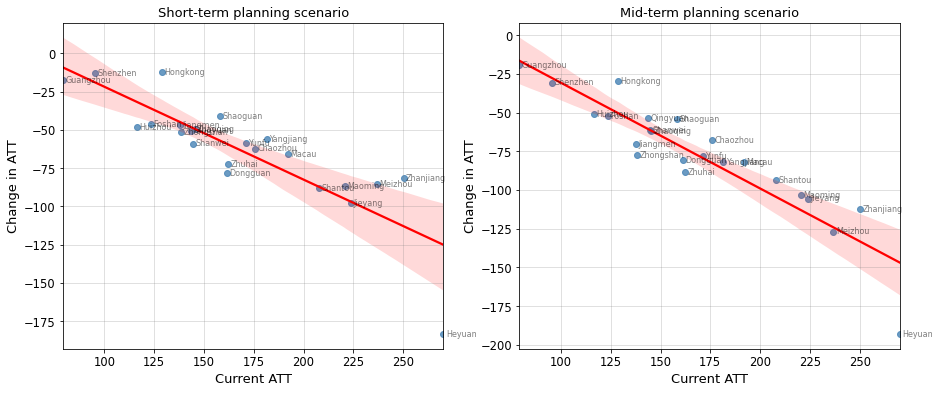

In [283]:
#Time
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
sns.regplot(x='Train_Average_Time_Now', y='d_time_ns', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax1.set_xlabel('Current ATT', fontsize = 13)
ax1.set_ylabel('Change in ATT', fontsize = 13)
ax1.set_title('Short-term planning scenario', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = (finaldata['Train_Average_Time_Now'][i], finaldata['d_time_ns'][i]),
                 xytext = (finaldata['Train_Average_Time_Now'][i]+1.2, finaldata['d_time_ns'][i]-1.5),fontsize=8,alpha = 0.5)
ax2 = fig.add_subplot(122)
sns.regplot(x='Train_Average_Time_Now', y='d_time_nl', data=finaldata, ax=ax2, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax2.set_xlabel('Current ATT', fontsize = 13)
ax2.set_ylabel('Change in ATT', fontsize = 13)
ax2.set_title('Mid-term planning scenario', fontsize = 13)
ax2.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax2.annotate(finaldata.loc[i,'City'], xy = (finaldata['Train_Average_Time_Now'][i], finaldata['d_time_nl'][i]),
                 xytext = (finaldata['Train_Average_Time_Now'][i]+1.2, finaldata['d_time_nl'][i]-1.5),fontsize=8,alpha = 0.5)
plt.savefig('./pics/Z1 Change in ATT in planning scenarios VS CURRENT.jpg', dpi=150, bbox_inches='tight')
plt.show()

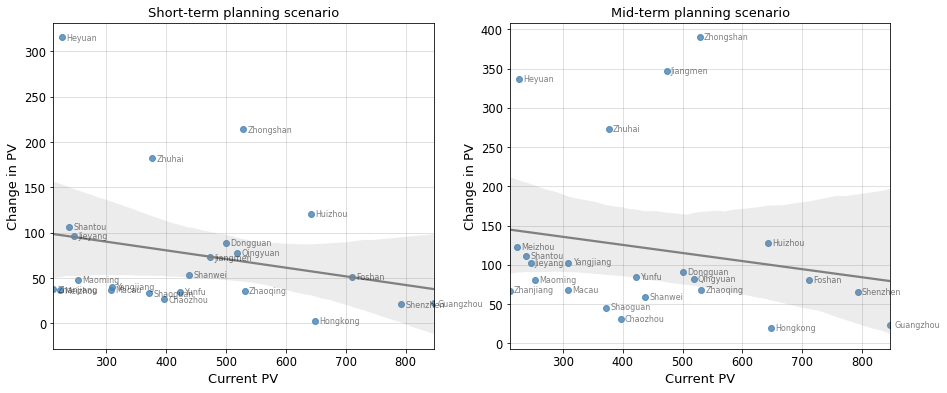

In [284]:
#ACC
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
sns.regplot(x='Train_Acc_Orig1', y='d_acc_ns', data=finaldata, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax1.set_xlabel('Current PV', fontsize = 13)
ax1.set_ylabel('Change in PV', fontsize = 13)
ax1.set_title('Short-term planning scenario')
ax1.grid(color='grey',alpha=0.3)
ax1.set_title('Short-term planning scenario', fontsize = 13)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax1.annotate(finaldata.loc[i,'City'], xy = (finaldata['Train_Acc_Orig1'][i], finaldata['d_acc_ns'][i]),
                 xytext = (finaldata['Train_Acc_Orig1'][i]+7, finaldata['d_acc_ns'][i]-3),fontsize=8,alpha = 0.5)
ax2 = fig.add_subplot(122)
sns.regplot(x='Train_Acc_Orig1', y='d_acc_nl', data=finaldata, ax=ax2, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax2.set_xlabel('Current PV', fontsize = 13)
ax2.set_ylabel('Change in PV', fontsize = 13)
ax2.grid(color='grey',alpha=0.3)
ax2.set_title('Mid-term planning scenario', fontsize = 13)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(finaldata)):
    ax2.annotate(finaldata.loc[i,'City'], xy = (finaldata['Train_Acc_Orig1'][i], finaldata['d_acc_nl'][i]),
                 xytext = (finaldata['Train_Acc_Orig1'][i]+7, finaldata['d_acc_nl'][i]-3),fontsize=8,alpha = 0.5)
plt.savefig('./pics/Z2 Change in flow in planning scenarios VS CURRENT.jpg', dpi=150, bbox_inches='tight')
plt.show()

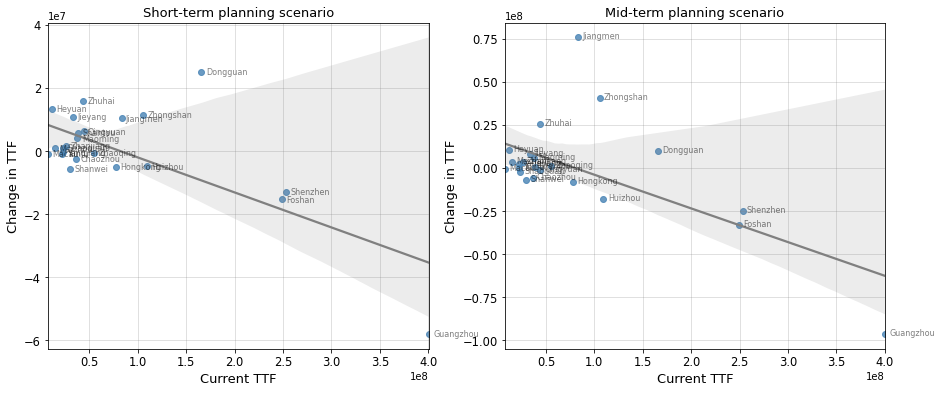

In [285]:
#FLOW - first trial
dataxx = finaldata
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
sns.regplot(x='Fitted2', y='d_Flow_ns', data=dataxx, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax1.set_xlabel('Current TTF', fontsize = 13)#, fontsize = 7)
ax1.set_ylabel('Change in TTF', fontsize = 13)#, fontsize = 7)
ax1.set_title('Short-term planning scenario', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(dataxx)):
    ax1.annotate(dataxx.loc[i,'City'], xy = (dataxx['Fitted2'][i],dataxx['d_Flow_ns'][i]),
                 xytext = (dataxx['Fitted2'][i]+4500000, dataxx['d_Flow_ns'][i]-850000),fontsize=8,alpha = 0.5)
ax2 = fig.add_subplot(122)
sns.regplot(x='Fitted2', y='d_Flow_nl', data=dataxx, ax=ax2, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax2.set_xlabel('Current TTF', fontsize = 13)#, fontsize = 7)
ax2.set_ylabel('Change in TTF', fontsize = 13)#, fontsize = 7)
ax2.set_title('Mid-term planning scenario', fontsize = 13)
ax2.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(dataxx)):
    ax2.annotate(finaldata.loc[i,'City'], xy = (dataxx['Fitted2'][i], dataxx['d_Flow_nl'][i]),
                 xytext = (dataxx['Fitted2'][i]+4500000, dataxx['d_Flow_nl'][i]-850000),fontsize=8,alpha = 0.5)
plt.savefig('./pics/Z3 Change in flow in planning scenarios VS CURRENT.jpg', dpi=150, bbox_inches='tight')
plt.show()

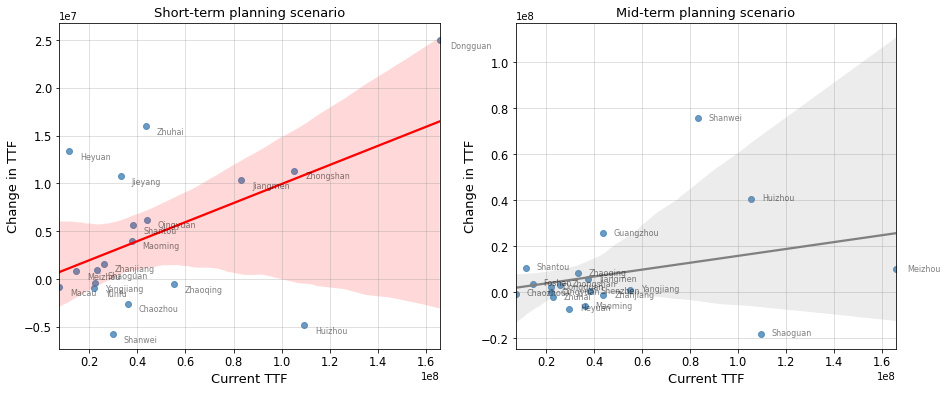

In [256]:
#FLOW- NO OUTLIERS
dataxx = finaldata[~finaldata.City.str.contains('Guangzhou|Shenzhen|Foshan|Hongkong')].copy(deep = True)
dataxx.reset_index(drop = True,inplace = True) 
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(121)
sns.regplot(x='Fitted2', y='d_Flow_ns', data=dataxx, ax=ax1, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax1.set_xlabel('Current TTF', fontsize = 13)
ax1.set_ylabel('Change in TTF', fontsize = 13)
ax1.set_title('Short-term planning scenario', fontsize = 13)
ax1.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(dataxx)):
    ax1.annotate(dataxx.loc[i,'City'], xy = (dataxx['Fitted2'][i],dataxx['d_Flow_ns'][i]),
                 xytext = (dataxx['Fitted2'][i]+4500000, dataxx['d_Flow_ns'][i]-850000),fontsize=8,alpha = 0.5)
ax2 = fig.add_subplot(122)
sns.regplot(x='Fitted2', y='d_Flow_nl', data=dataxx, ax=ax2, 
            scatter_kws={"color": "steelblue"}, line_kws={"color": "grey"})
ax2.set_xlabel('Current TTF', fontsize = 13)
ax2.set_ylabel('Change in TTF', fontsize = 13)
ax2.set_title('Mid-term planning scenario', fontsize = 13)
ax2.grid(color='grey',alpha=0.3)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
for i in range(len(dataxx)):
    ax2.annotate(finaldata.loc[i,'City'], xy = (dataxx['Fitted2'][i], dataxx['d_Flow_nl'][i]),
                 xytext = (dataxx['Fitted2'][i]+4500000, dataxx['d_Flow_nl'][i]-850000),fontsize=8,alpha = 0.5)
plt.savefig('./pics/Z4 Change in flow in planning scenarios VS CURRENT.jpg', dpi=150, bbox_inches='tight')
plt.show()

In [83]:
finaldata.to_excel('finaldata.xlsx')

# CV = (sd / mn)*100%   

In [62]:
display(ff_train[ff_train.Flow!=0]['Train_Time'].max(),ff_train[ff_train.Flow!=0]['Train_Time'].min())
display(ff_bus[ff_bus.Flow!=0]['Driving_Time'].max(),ff_bus[ff_bus.Flow!=0]['Driving_Time'].min())

594

16

566.2833333333333

24.93333333333333

In [63]:
#ff_train[['Orig','Dest','Flow','Train_Time']].head()
#ff_bus[['Orig','Dest','Flow','Driving_Time']].head()
x = 36
flowbusdata = pd.DataFrame(np.zeros((x,1),dtype=np.int),columns=['value'])
flowtraindata = pd.DataFrame(np.zeros((x,1),dtype=np.int),columns=['value'])

maxbus = ff_bus['Driving_Time'].max()
minbus = ff_bus['Driving_Time'].min()
interbus = (ff_bus['Driving_Time'].max() - ff_bus['Driving_Time'].min())/x

maxtrain = ff_train['Train_Time'].max()
mintrain = ff_train['Train_Time'].min()
intertrain = (ff_train['Train_Time'].max() - ff_train['Train_Time'].min())/x
# display(maxbus,minbus,interbus,maxtrain,mintrain,intertrain)
# display(flowbusdata,flowtraindata)
for i in range(x):
    for r,row in ff_bus.iterrows():
        if  row['Driving_Time'] >= minbus+i*interbus and row['Driving_Time'] < (minbus + (i+1)*interbus):
            flowbusdata.loc[i,'value'] = row['Flow'] + flowbusdata.loc[i,'value']
        if i ==9 and row['Driving_Time'] == maxbus:
            flowbusdata.loc[9,'value'] = row['Flow'] + flowbusdata.loc[9,'value'] 
            
    for r1,row1 in ff_train.iterrows():
        if  row1['Train_Time'] >=mintrain+i*intertrain and row1['Train_Time'] < (mintrain + (i+1)*intertrain):
            flowtraindata.loc[i,'value'] = row1['Flow'] + flowtraindata.loc[i,'value']
        if i ==9 and row1['Train_Time'] == maxtrain:
            flowtraindata.loc[9,'value'] = row1['Flow'] + flowtraindata.loc[9,'value']            

# display(ff_bus['Flow'].sum(),ff_train['Flow'].sum(),flowbusdata.value.sum(),flowtraindata.value.sum())
# display(flowbusdata,flowtraindata)

In [64]:
#ff_train[['Orig','Dest','Flow','Train_Time']].head()
#ff_bus[['Orig','Dest','Flow','Driving_Time']].head()
x = 36
flowbusdata = pd.DataFrame(np.zeros((x,2),dtype=np.int),columns=['labelx','value'])
flowtraindata = pd.DataFrame(np.zeros((x,2),dtype=np.int),columns=['labelx','value'])

maxbus = ff_bus['Driving_Time'].max()
minbus = ff_bus['Driving_Time'].min()
interbus = (ff_bus['Driving_Time'].max() - ff_bus['Driving_Time'].min())/x

maxx = ff_train['Train_Time'].max()
minx = ff_train['Train_Time'].min()
inter = (ff_train['Train_Time'].max() - ff_train['Train_Time'].min())/x
# display(maxbus,minbus,interbus,maxtrain,mintrain,intertrain)
# display(flowbusdata,flowtraindata)
for i in range(x):
    flowbusdata.loc[i,'labelx']=f'{minx}-{minx + (i+1)*inter}min'
    flowtraindata.loc[i,'labelx']=f'{minx}-{minx + (i+1)*inter}min'
    for r,row in ff_bus.iterrows():
        if  row['Driving_Time'] >= minx+i*inter and row['Driving_Time'] < (minx + (i+1)*inter):
            flowbusdata.loc[i,'value'] = row['Flow'] + flowbusdata.loc[i,'value']
 
            
    for r1,row1 in ff_train.iterrows():
        if  row1['Train_Time'] >=minx+i*inter and row1['Train_Time'] < (minx + (i+1)*inter):
            flowtraindata.loc[i,'value'] = row1['Flow'] + flowtraindata.loc[i,'value']
        if i ==9 and row1['Train_Time'] == maxx:
            flowtraindata.loc[9,'value'] = row1['Flow'] + flowtraindata.loc[9,'value']            

# display(ff_bus['Flow'].sum(),ff_train['Flow'].sum(),flowbusdata.value.sum(),flowtraindata.value.sum())
# display(flowbusdata,flowtraindata)

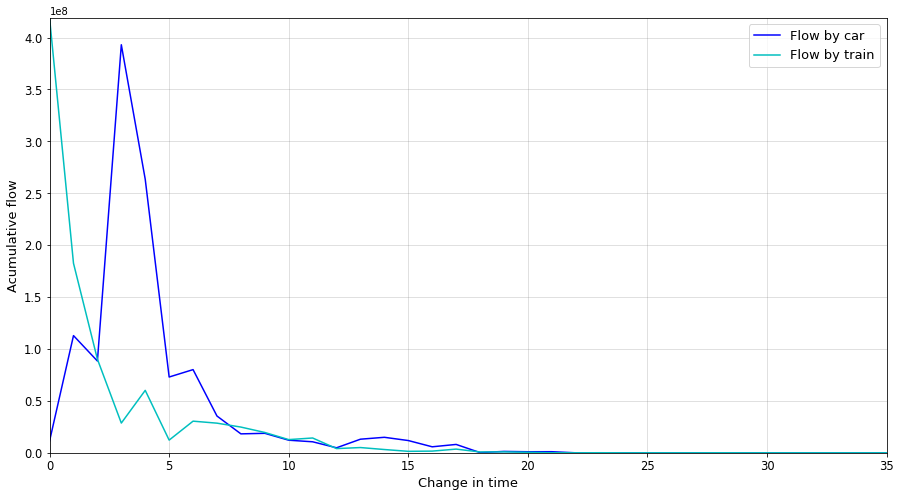

In [65]:
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(111)

# x1 = flowbusdata.labelx
# x2 = flowtraindata.labelx
y1 = flowbusdata.value
y2 = flowtraindata.value
ax1.plot(y1,label='Flow by car',color='b')
ax1.plot(y2,label='Flow by train',color='c')#,s=20)
ax1.grid(color='grey',alpha=0.3)# axis = 'y' )
ax1.legend(loc="best",fontsize = 13)
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
ax1.set_xlabel("Change in time",fontsize = 13)
ax1.set_ylabel("Acumulative flow",fontsize = 13)
plt.margins(0,0)
plt.savefig('./pics/18 flow distance comparisons.jpg', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
listx = ['Car_Average', 'Train_Average_Time_Now', 'Train_Average_Time_ST','Train_Average_Time_LT',#flow
        'Car_Acc_Orig1', 'Train_Acc_Orig1', 'Train_Acc_Orig_st', 'Train_Acc_Orig_lt',#acc
        'Flowbus','Flow','Fitted2','Fitted_st', 'Fitted_lt', 'Fitted2bus']#flow
#'d_time_ct','d_time_ns', 'd_time_nl', 'd_acc_ct', 'd_acc_ns', 'd_acc_nl','d_Flow_ct', 'd_Flow_ns', 'd_Flow_nl',
listx1 = []
listx2 = []
listx3 = []

listx11 = []
listx21 = []
listx31 = []

cod = finaldata.City.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau')

for i in range(len(listx)):
    x = finaldata[listx[i]].std()/finaldata[listx[i]].mean()
    y = finaldata[cod][listx[i]].std()/finaldata[cod][listx[i]].mean()
    z = finaldata[~cod][listx[i]].std()/finaldata[~cod][listx[i]].mean()
    x1 = finaldata[listx[i]].mean()
    y1 = finaldata[cod][listx[i]].mean()
    z1 = finaldata[~cod][listx[i]].mean()
    listx1.append(x)
    listx2.append(y)
    listx3.append(z)
    listx11.append(x1)
    listx21.append(y1)
    listx31.append(z1)
cvdata = pd.DataFrame(list(zip(listx,listx1,listx2,listx3,listx11,listx21,listx31)),
                      columns=['item','cv_value_all','cv_value_GBA','cv_value_nGBA','mean_all','mean_GBA','mean_nGBA'])

for i in ['cv_value_all','cv_value_GBA','cv_value_nGBA']:
    cvdata[i] = cvdata[i].map(lambda x: format(x,'.3%')) 

cvdata.to_excel('cvdata.xlsx')
cvdata

,item,cv_value_all,cv_value_GBA,cv_value_nGBA,mean_all,mean_GBA,mean_nGBA
0,Car_Average,25.079%,7.809%,18.684%,2.095071e+02,1.684436e+02,2.471486e+02
1,Train_Average_Time_Now,29.256%,23.502%,21.243%,1.680321e+02,1.345988e+02,1.986793e+02
2,Train_Average_Time_ST,25.439%,21.288%,20.729%,1.048858e+02,8.898809e+01,1.194586e+02
3,Train_Average_Time_LT,23.912%,21.161%,16.313%,9.080341e+01,7.603821e+01,1.043382e+02
4,Car_Acc_Orig1,31.401%,10.711%,25.484%,2.491168e+02,3.173644e+02,1.865566e+02
5,Train_Acc_Orig1,42.278%,28.927%,32.312%,4.442103e+02,5.780420e+02,3.215312e+02
6,Train_Acc_Orig_st,35.357%,23.188%,27.578%,5.205497e+02,6.552376e+02,3.970859e+02
7,Train_Acc_Orig_lt,35.094%,22.218%,23.516%,5.651323e+02,7.192373e+02,4.238695e+02
8,Flowbus,115.582%,79.935%,42.314%,1.025932e+08,1.751049e+08,3.612417e+07
9,Flow,126.563%,92.936%,26.889%,8.211124e+07,1.393715e+08,2.962264e+07


In [67]:
finaldata.to_excel('finaldata2.xlsx')

In [68]:
display(ff_bus.columns,ff_train.columns,finaldata.columns)

Index(['Orig', 'Dest', 'Flow', 'Driving_Time', 'Pop_Dest', 'Lab_Dest',
       'GDP_Dest', 'IFA_Dest', 'FT_Dest', 'RDI_Dest', 'HP_Dest', 'Edu_Dest',
       'CO_Dest', 'HWL_Dest', 'Car_Acc_Orig1', 'Pop_Orig', 'Lab_Orig',
       'GDP_Orig', 'IFA_Orig', 'FT_Orig', 'RDI_Orig', 'HP_Orig', 'Edu_Orig',
       'CO_Orig', 'HWL_Orig', 'log_Pop_Dest', 'log_Lab_Dest', 'log_GDP_Dest',
       'log_IFA_Dest', 'log_FT_Dest', 'log_RDI_Dest', 'log_HP_Dest',
       'log_Edu_Dest', 'log_CO_Dest', 'log_HWL_Dest', 'log_Pop_Orig',
       'log_Lab_Orig', 'log_GDP_Orig', 'log_IFA_Orig', 'log_FT_Orig',
       'log_RDI_Orig', 'log_HP_Orig', 'log_Edu_Orig', 'log_CO_Orig',
       'log_HWL_Orig', 'log_Driving_Time', 'Fitted2'],
      dtype='object')

Index(['Orig', 'Dest', 'Flow', 'Train_Time', 'Train_Time_st', 'Train_Time_lt',
       'Pop_Dest', 'Lab_Dest', 'GDP_Dest', 'IFA_Dest', 'FT_Dest', 'RDI_Dest',
       'HP_Dest', 'Edu_Dest', 'RLN_Dest', 'RLS_Dest', 'RLL_Dest',
       'Train_Acc_Orig1', 'Train_Acc_Orig_st', 'Train_Acc_Orig_lt', 'Pop_Orig',
       'Lab_Orig', 'GDP_Orig', 'IFA_Orig', 'FT_Orig', 'RDI_Orig', 'HP_Orig',
       'Edu_Orig', 'RLN_Orig', 'RLS_Orig', 'RLL_Orig', 'log_Pop_Dest',
       'log_Lab_Dest', 'log_GDP_Dest', 'log_IFA_Dest', 'log_FT_Dest',
       'log_RDI_Dest', 'log_HP_Dest', 'log_Edu_Dest', 'log_RLN_Dest',
       'log_RLS_Dest', 'log_RLL_Dest', 'log_Pop_Orig', 'log_Lab_Orig',
       'log_GDP_Orig', 'log_IFA_Orig', 'log_FT_Orig', 'log_RDI_Orig',
       'log_HP_Orig', 'log_Edu_Orig', 'log_RLN_Orig', 'log_RLS_Orig',
       'log_RLL_Orig', 'log_Train_Time', 'log_Train_Time_st',
       'log_Train_Time_lt', 'Fitted2', 'Fitted_st', 'Fitted_lt'],
      dtype='object')

Index(['City', 'Population', 'Labour_Force', 'GDP_Avg', 'GDP',
       'Investment_in_Fixed_Assets', 'Foreign_Trade', 'RD_Investment',
       'Housing_Price', 'Education', 'Car_Ownership', 'Highway_Length',
       'Railway_Length_Now', 'Railway_Length_ST', 'Railway_Length_LT',
       'Car_Average', 'Train_Average_Time_Now', 'Train_Average_Time_ST',
       'Train_Average_Time_LT', 'Car_Acc_Orig1', 'Train_Acc_Orig1',
       'Train_Acc_Orig_st', 'Train_Acc_Orig_lt', 'Flow', 'Fitted2',
       'Fitted_st', 'Fitted_lt', 'Flowbus', 'Fitted2bus', 'd_time_ct',
       'd_time_ns', 'd_time_nl', 'd_acc_ct', 'd_acc_ns', 'd_acc_nl',
       'd_Flow_ct', 'd_Flow_ns', 'd_Flow_nl', 'normed_d_time_ct',
       'normed_d_time_ns', 'normed_d_time_nl', 'normed_d_acc_ct',
       'normed_d_acc_ns', 'normed_d_acc_nl', 'normed_d_Flow_ct',
       'normed_d_Flow_ns', 'normed_d_Flow_nl', 'rd_time_ct', 'rd_time_ns',
       'rd_time_nl', 'rd_acc_ct', 'rd_acc_ns', 'rd_acc_nl', 'rd_Flow_ct',
       'rd_Flow_ns', 'rd_Flo

# OD flow map     

In [ ]:
ff_bus_xx = ff_bus.copy(deep = True) #合并的
ff_train_xx = ff_train.copy(deep = True) #合并的
ff_bus_xn = ff_bus.copy(deep = True) #不合并的
ff_train_xn = ff_train.copy(deep = True) #不合并的
print('original size',ff_bus_xx.shape,ff_bus_xx['Flow'].sum(),ff_train_xx.shape,ff_train_xx['Flow'].sum())

#合并的
for index1, row1 in ff_bus_xx.iterrows():
    for index2, row2 in ff_bus_xx.iterrows():
        if (index1<index2) and (row1[0] == row2[1]) and (row1[1] == row2[0]):
            ff_bus_xx.loc[index1,'Flow'] =  row1[2] + row2[2]
            ff_bus_xx.loc[index2,'Flow'] = 0
        
for index1, row1 in ff_train_xx.iterrows():
    for index2, row2 in ff_train_xx.iterrows():
        if (index1 < index2) and (row1[0] == row2[1]) and (row1[1] == row2[0]):
            ff_train_xx.loc[index1,'Flow'] =  row1[2] + row2[2]
            ff_train_xx.loc[index2,'Flow'] = 0

print('size after merging',ff_bus_xx.shape,ff_bus_xx['Flow'].sum(),ff_train_xx.shape,ff_train_xx['Flow'].sum())

#合并后取0
ff_bus_xx = ff_bus_xx[ff_bus_xx['Flow'] > 0]
ff_train_xx = ff_train_xx[ff_train_xx['Flow'] > 0]
print(ff_bus_xx.shape,ff_bus_xx['Flow'].sum(),ff_train_xx.shape,ff_train_xx['Flow'].sum())

#1改缩写 2提取GBA；3转list  合并的给chord 未合并的给sankeychart
#1改缩写 
# dictx = {'Guangzhou':'Gz','Shenzhen':'Sz','Zhuhai':'Zh','Shantou':'St','Foshan':'Fs','Shaoguan':'Sg','Heyuan':'Hy','Meizhou':'Mz',
#         'Huizhou':'Hz','Shanwei':'Sw','Dongguan':'Dg','Zhongshan':'Zs','Jiangmen':'Jm','Yangjiang':'Yj','Zhanjiang':'Zj','Maoming':'Mm',
#         'Zhaoqing':'Zq','Qingyuan':'Qy','Chaozhou':'Cz','Jieyang':'Jy', 'Yunfu':'Yf','Macau':'Mc','Hongkong':'Hk'}
#x.replace({'Orig':dictx,'Dest':dictx} ,inplace = False ,regex = True)

#2提取GBA  ff_bus_xx  ff_train_xx  ff_bus_xn  ff_train_xn  
ff_bus_xx_GBA = ff_bus_xx[(ff_bus_xx.Orig.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau')) 
                           & (ff_bus_xx.Dest.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau'))] 
ff_bus_xn_GBA = ff_bus_xn[(ff_bus_xn.Orig.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau')) 
                           & (ff_bus_xn.Dest.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau'))]

ff_train_xx_GBA = ff_train_xx[(ff_train_xx.Orig.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau')) 
                           & (ff_train_xx.Dest.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau'))] 
ff_train_xn_GBA = ff_train_xn[(ff_train_xn.Orig.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau')) 
                           & (ff_train_xn.Dest.str.contains('Guangzhou|Shenzhen|Zhuhai|Foshan|Huizhou|Dongguan|Zhongshan|Jiangmen|Zhaoqing|Hongkong|Macau'))] 
#f_bus_xx.to_csv('ff_bus_xx1.csv')
# ff_train_xx.to_csv('ff_train_xx1.csv')
#ff_bus_xx[['Orig','Dest','Flow']].values.tolist() 

In [ ]:
## Sankey map      
dictx = {'Guangzhou':'Guangzhou ','Shenzhen':'Shenzhen ','Zhuhai':'Zhuhai ','Shantou':'Shantou ','Foshan':'Foshan ','Shaoguan':'Shaoguan ','Heyuan':'Heyuan ','Meizhou':'Meizhou ',
        'Huizhou':'Huizhou ','Shanwei':'Shanwei ','Dongguan':'Dongguan ','Zhongshan':'Zhongshan ','Jiangmen':'Jiangmen ','Yangjiang':'Yangjiang ','Zhanjiang':'Zhanjiang ','Maoming':'Maoming ',
        'Zhaoqing':'Zhaoqing ','Qingyuan':'Qingyuan ','Chaozhou':'Chaozhou ','Jieyang':'Jieyang ', 'Yunfu':'Yunfu ','Macau':'Macau ','Hongkong':'Hongkong '}
datas = [ff_bus_xx,ff_bus_xn_GBA,ff_train_xn,ff_train_xn_GBA]
names = ['Intercity_Flow_by_Car_in_23_Cities','Intercity_Flow_by_Car_in_GBA','Intercity_Flow_by_Train_in_23_Cities','Intercity_Flow_by_Train_in_GBA']
for data,name in zip(datas,names):
    data.replace({'Dest':dictx},inplace = True ,regex = True)
    # 生成nodes
    nodes = [] #nodes.append({'name':'总支出'})
    for i in set(pd.concat([data.Orig, data.Dest])):   #data[0].unique():
        dict= {}
        dict['name'] = i
        nodes.append(dict)
    # 生成links
    links = []
    for i,row in data.iterrows():
    #for x, y, z in zip(data.来源地, data.输入地, data.数量):
    #    d2 = {} #    d2['source'] = x #    d2['target'] = y #    d2['value'] = z
        dict={}
        dict['source'] = row[0]
        dict['target'] = row[1]
        dict['value'] = row[2]
        links.append(dict)
    # 生成可视化结果
    pic = (
           Sankey( init_opts=opts.InitOpts(width="1000px", height="800px") )#图的长宽
           .add('Flow/person',#图例名称
                 nodes,#节点数据
                 links,#边和流量数据
                 linestyle_opt=opts.LineStyleOpts(opacity=0.3, curve=0.5, color="source",type_="dotted"),#设置透明度、弯曲度、颜色
                 label_opts=opts.LabelOpts(position="right",), #标签显示位置
               )
               .set_global_opts(title_opts=opts.TitleOpts(title= (name) )) #"_from_2017.01_to_2019.04"
          )
    pic.render((name+'.html'))    # 输出html可视化结果

In [ ]:
ff_bus_xx[['Orig','Dest','Flow']].values.tolist()
#['Guangzhou','Shenzhen','Zhuhai','Foshan','Huizhou','Dongguan','Zhongshan','Jiangmen','Zhaoqing',#9
#          'Hongkong','Macau',#+2
#          'Shantou','Shaoguan','Heyuan','Meizhou','Shanwei','Yangjiang','Zhanjiang','Maoming','Qingyuan','Chaozhou','Jieyang','Yunfu']

In [ ]:
#3转list合并的 chord 不合并的 sankeychart
ff_bus_xx[['Orig','Dest','Flow']].values.tolist()     #合并的 chord .to_csv('ff_bus_xx.csv')
ff_train_xx[['Orig','Dest','Flow']].values.tolist() #.to_csv('ff_train_xx.csv') #
ff_bus_xx_GBA[['Orig','Dest','Flow']].values.tolist() #.to_csv('ff_bus_xx_GBA.csv')#
ff_train_xx_GBA[['Orig','Dest','Flow']]   #.values.tolist() #.to_csv('ff_train_xx_GBA.csv'，index = False)

In [ ]:
ff_bus_xn[['Orig','Dest','Flow']].to_csv('ff_bus_xn.csv') #.values.tolist()     #不合并的 sankeychart
ff_train_xn[['Orig','Dest','Flow']].to_csv('ff_train_xn.csv')   #.values.tolist()
ff_bus_xn_GBA[['Orig','Dest','Flow']].to_csv('ff_bus_xn_GBA.csv')     #.values.tolist()
ff_train_xn_GBA[['Orig','Dest','Flow']].to_csv('ff_train_xn_GBA.csv')  #.values.tolist()

# Chord map      

In [ ]:
#ff_bus_pivot ff_train_pivot
ff_bus_pivot1 = ff_bus_pivot.fillna(0) #,inplace = True   
ff_train_pivot1 = ff_train_pivot.fillna(0)
ioc1 = ['Guangzhou','Shenzhen','Zhuhai','Foshan','Huizhou','Dongguan','Zhongshan','Jiangmen','Zhaoqing','Hongkong','Macau']
## names1 = ['Cz', 'Dg', 'Fs', 'Gz', 'Hy', 'Hk', 'Hz', 'Jm', 'Jy', 'Mc', 'Mm', 'Mz', 'Qy', 'St', 'Sw', 'Sg', 'Sz', 'Yj', 'Yf', 'Zj', 'Zq', 'Zs', 'Zh']
ioc2 = ['Guangzhou','Shenzhen','Zhuhai','Foshan','Huizhou','Dongguan','Zhongshan','Jiangmen','Zhaoqing',#9
         'Hongkong','Macau',#+2
         'Shantou','Shaoguan','Heyuan','Meizhou','Shanwei','Yangjiang','Zhanjiang','Maoming','Qingyuan','Chaozhou','Jieyang','Yunfu']
ff_bus_pivot1_GBA = ff_bus_pivot1.loc[ioc1,ioc1]
ff_train_pivot1_GBA = ff_train_pivot1.loc[ioc1,ioc1]
ff_bus_pivot1 = ff_bus_pivot1.loc[ioc2,ioc2]
ff_train_pivot1 = ff_train_pivot1.loc[ioc2,ioc2]
print(len(ff_bus_pivot1),len(ff_train_pivot1),len(ff_bus_pivot1_GBA),len(ff_train_pivot1_GBA))

In [ ]:
# frames = [ff_bus_pivot1,ff_bus_pivot1_GBA,ff_train_pivot1,ff_train_pivot1_GBA]
# names = ['ff_bus_pivot1','ff_bus_pivot1_GBA','ff_train_pivot1','ff_train_pivot1_GBA']

names = ff_train_pivot1.index.tolist()
matrix = ff_train_pivot1.values.tolist() 

In [ ]:
# names

In [ ]:
Chord(matrix, names, colors="d3.schemeAccent",title = 'chord',arc_numbers=True, wrap_labels=False,
      font_size="17px", font_size_large="22px",width=1400
      ).show()# .to_html((name+'out.html'))#.show() #.to_png('out.png')  wrap_labels=True  curved_labels=True, symmetric=False width=1700

In [ ]:
# BACKUP
# frames = [ff_bus_pivot1,ff_bus_pivot1_GBA,ff_train_pivot1,ff_train_pivot1_GBA]
# names = ['ff_bus_pivot1','ff_bus_pivot1_GBA','ff_train_pivot1','ff_train_pivot1_GBA']
# for data,name in zip(frames,names):
#     names = data.index.tolist()
#     matrix = data.values.tolist() 
#     Chord(matrix, names, colors="d3.schemeSet5",title = 'chord',arc_numbers=True, wrap_labels=False,
#           font_size="17px", font_size_large="22px",width=1400
#           ).show()# .to_html((name+'out.html'))#.show() #.to_png('out.png')
#     #  wrap_labels=True  curved_labels=True, symmetric=False width=1700

# PLOT of fit  

In [69]:
accessibility2 = accessibility2.merge(train_accessibility3,left_index= True, right_index= True)

NameError: name 'accessibility2' is not defined

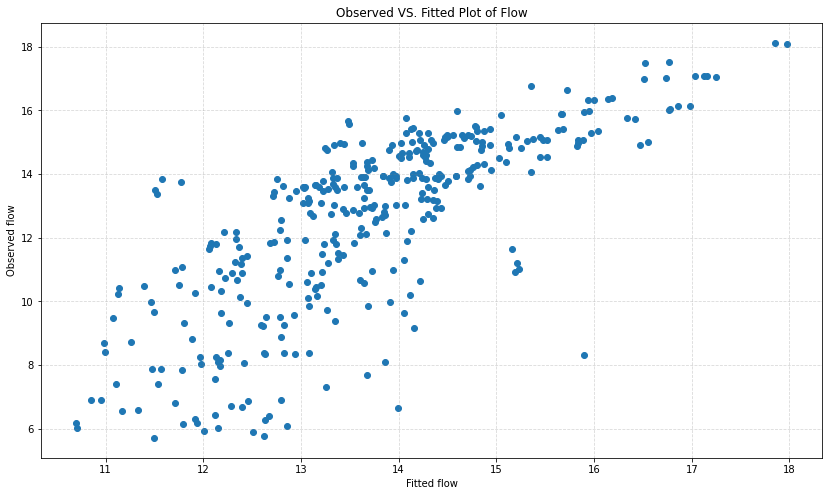

In [70]:
# Observed VS. Fitted scatter (logged)
fig = plt.figure(figsize=(14,8)) 

plt.scatter(np.log(ff_train["Fitted2"]),np.log(ff_train["Flow"]))

plt.xlabel('Fitted flow')
plt.ylabel('Observed flow')
plt.grid(color='grey', linestyle='--',alpha=0.3)

plt.title('Observed VS. Fitted Plot of Flow')
plt.show()

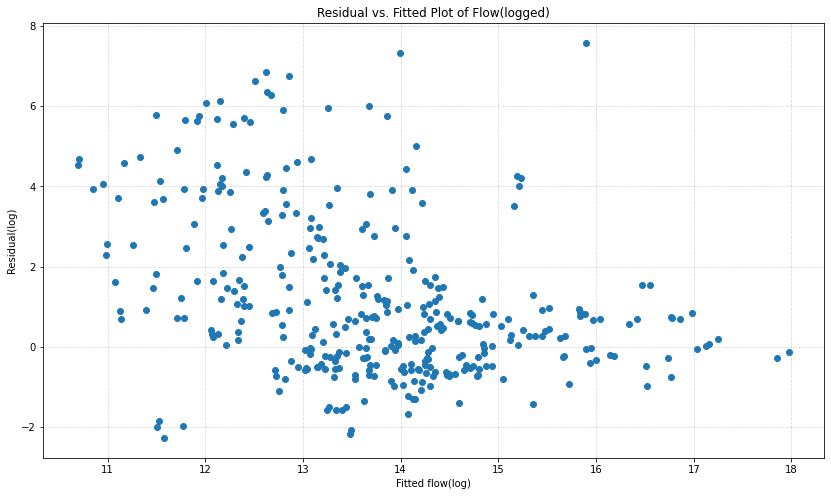

In [71]:
# Residual versus fitted scatter (logged)
fig = plt.figure(figsize=(14,8)) 

plt.scatter(np.log(ff_train["Fitted2"]),
            (np.log(ff_train["Fitted2"])-np.log(ff_train["Flow"]))
            )

plt.xlabel('Fitted flow(log)')
plt.ylabel('Residual(log)')
plt.grid(color='grey', linestyle='--',alpha=0.3)
# plt.legend(loc=1)
plt.title('Residual vs. Fitted Plot of Flow(logged)')
plt.show()

No handles with labels found to put in legend.


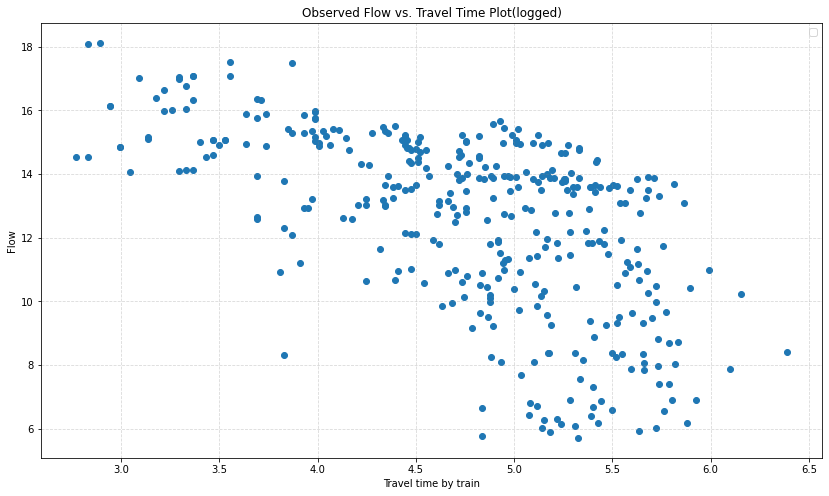

In [73]:
# Observed Flow vs. Travel Time scatter
fig = plt.figure(figsize=(14,8)) 

plt.scatter(ff_train['log_Train_Time'],np.log(ff_train["Flow"]))

plt.xlabel('Travel time by train')
plt.ylabel('Flow')
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc=1)
plt.title('Observed Flow vs. Travel Time Plot(logged)')
plt.show()

In [74]:
ff_train.columns

Index(['Orig', 'Dest', 'Flow', 'Train_Time', 'Train_Time_st', 'Train_Time_lt',
       'Pop_Dest', 'Lab_Dest', 'GDP_Dest', 'IFA_Dest', 'FT_Dest', 'RDI_Dest',
       'HP_Dest', 'Edu_Dest', 'RLN_Dest', 'RLS_Dest', 'RLL_Dest',
       'Train_Acc_Orig1', 'Train_Acc_Orig_st', 'Train_Acc_Orig_lt', 'Pop_Orig',
       'Lab_Orig', 'GDP_Orig', 'IFA_Orig', 'FT_Orig', 'RDI_Orig', 'HP_Orig',
       'Edu_Orig', 'RLN_Orig', 'RLS_Orig', 'RLL_Orig', 'log_Pop_Dest',
       'log_Lab_Dest', 'log_GDP_Dest', 'log_IFA_Dest', 'log_FT_Dest',
       'log_RDI_Dest', 'log_HP_Dest', 'log_Edu_Dest', 'log_RLN_Dest',
       'log_RLS_Dest', 'log_RLL_Dest', 'log_Pop_Orig', 'log_Lab_Orig',
       'log_GDP_Orig', 'log_IFA_Orig', 'log_FT_Orig', 'log_RDI_Orig',
       'log_HP_Orig', 'log_Edu_Orig', 'log_RLN_Orig', 'log_RLS_Orig',
       'log_RLL_Orig', 'log_Train_Time', 'log_Train_Time_st',
       'log_Train_Time_lt', 'Fitted2', 'Fitted_st', 'Fitted_lt'],
      dtype='object')

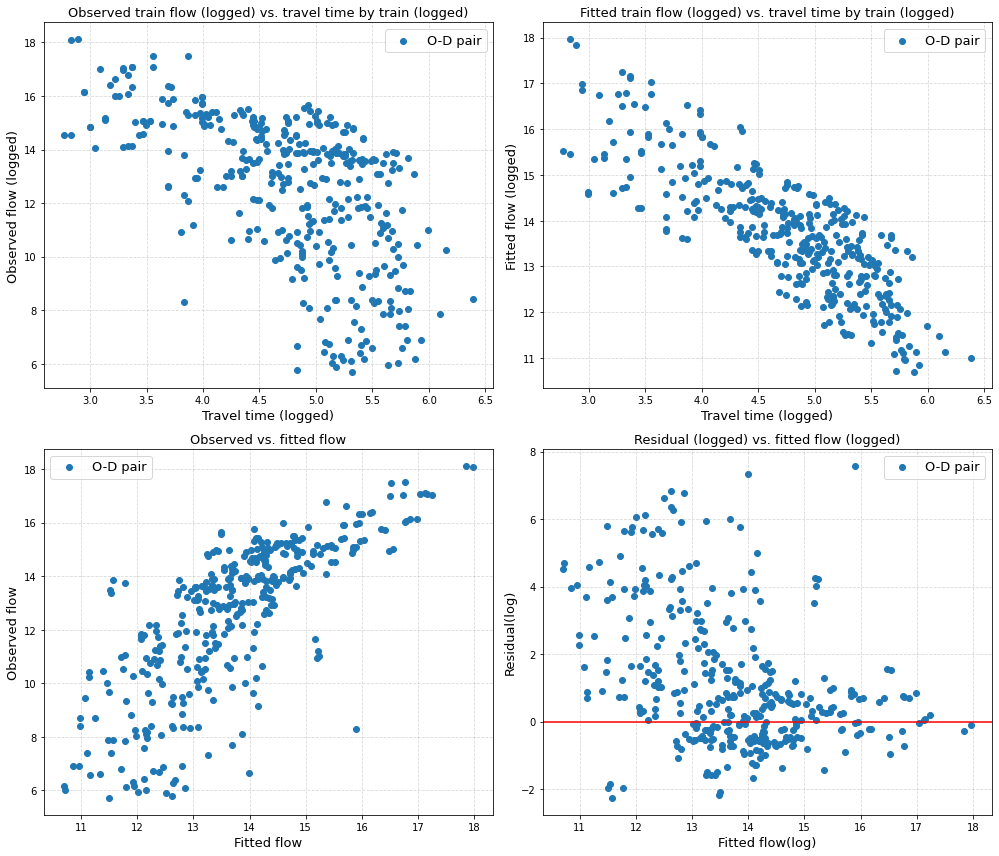

In [96]:
# Observed Flow vs. Travel Time scatter
fig = plt.figure(figsize=(14,12)) 

#time flow observed
ax1 = fig.add_subplot(221)
plt.scatter(ff_train['log_Train_Time'],np.log(ff_train["Flow"]),label = "O-D pair")
plt.xlabel('Travel time (logged)', fontsize = 13)
plt.ylabel('Observed flow (logged)', fontsize = 13)
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Observed train flow (logged) vs. travel time by train (logged)', fontsize = 13)


# time flow fitted
ax2 = fig.add_subplot(222)
plt.scatter(ff_train['log_Train_Time'],np.log(ff_train["Fitted2"]),label =  "O-D pair")
plt.xlabel('Travel time (logged)', fontsize = 13)
plt.ylabel('Fitted flow (logged)', fontsize = 13)
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Fitted train flow (logged) vs. travel time by train (logged)', fontsize = 13)

#flow observed vs fitted
ax3 = fig.add_subplot(223)
plt.scatter(np.log(ff_train["Fitted2"]),np.log(ff_train["Flow"]),label = "O-D pair")
plt.xlabel('Fitted flow', fontsize = 13)
plt.ylabel('Observed flow', fontsize = 13)
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Observed vs. fitted flow', fontsize = 13)

#residual 
ax4 = fig.add_subplot(224)
plt.scatter(np.log(ff_train["Fitted2"]),
            (np.log(ff_train["Fitted2"])-np.log(ff_train["Flow"])),label = "O-D pair")
plt.xlabel('Fitted flow(log)', fontsize = 13)
plt.ylabel('Residual(log)', fontsize = 13)
plt.axhline(y=0, color='r')# , linestyle='--'
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Residual (logged) vs. fitted flow (logged)', fontsize = 13)

plt.savefig('./pics/xxx.jpeg', dpi=150, bbox_inches='tight')
fig.tight_layout()
plt.show()

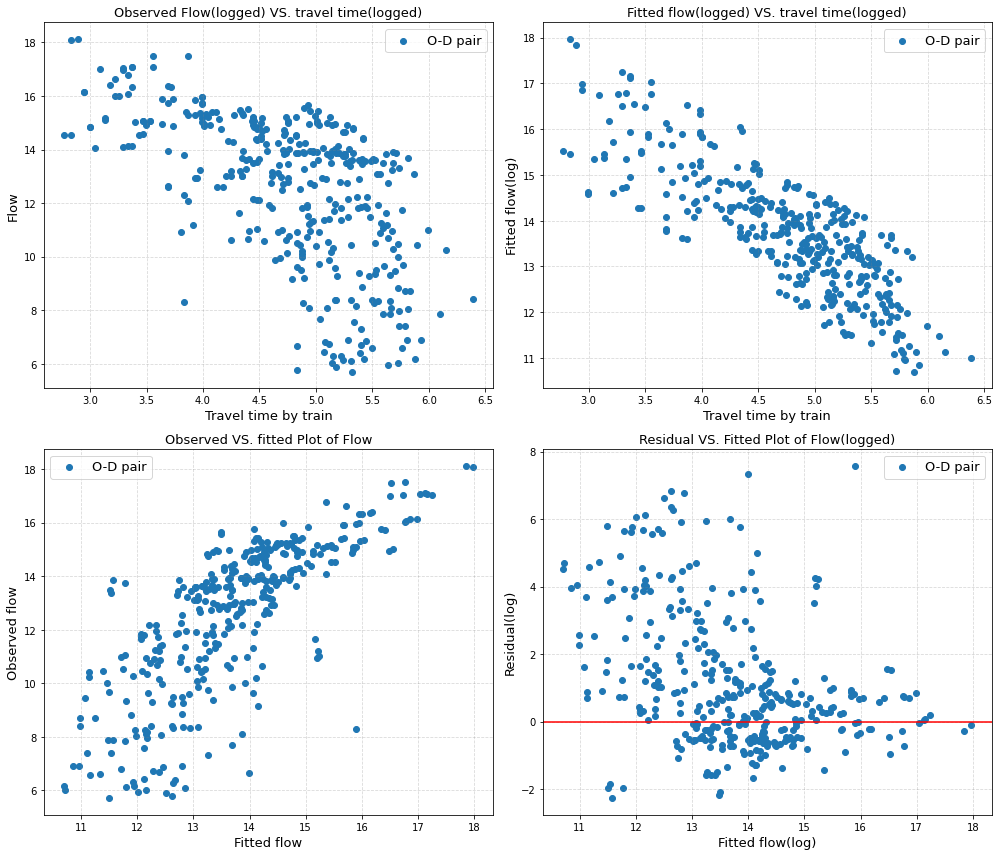

In [93]:
# Observed Flow vs. Travel Time scatter
fig = plt.figure(figsize=(14,12)) 

#time flow observed
ax1 = fig.add_subplot(221)
plt.scatter(ff_train['log_Train_Time'],np.log(ff_train["Flow"]),label = "O-D pair")
plt.xlabel('Travel time by train', fontsize = 13)
plt.ylabel('Flow', fontsize = 13)
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Observed train flow (logged) VS. travel time by train (logged)', fontsize = 13)


# time flow fitted
ax2 = fig.add_subplot(222)
plt.scatter(ff_train['log_Train_Time'],np.log(ff_train["Fitted2"]),label =  "O-D pair")
plt.xlabel('Travel time by train', fontsize = 13)
plt.ylabel('Fitted flow(log)', fontsize = 13)
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Fitted train flow(logged) VS. travel time by train (logged)', fontsize = 13)

#flow observed vs fitted
ax3 = fig.add_subplot(223)
plt.scatter(np.log(ff_train["Fitted2"]),np.log(ff_train["Flow"]),label = "O-D pair")
plt.xlabel('Fitted flow', fontsize = 13)
plt.ylabel('Observed flow', fontsize = 13)
plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Observed VS. fitted Plot of Flow', fontsize = 13)

#residual 
ax4 = fig.add_subplot(224)
plt.scatter(np.log(ff_train["Fitted2"]),
            (np.log(ff_train["Fitted2"])-np.log(ff_train["Flow"])),label = "O-D pair")
plt.xlabel('Fitted flow(log)', fontsize = 13)
plt.ylabel('Residual(log)', fontsize = 13)
plt.axhline(y=0, color='r')# , linestyle='--'

plt.grid(color='grey', linestyle='--',alpha=0.3)
plt.legend(loc='best', fontsize = 13)
plt.title('Residual VS. Fitted Plot of Flow(logged)', fontsize = 13)

plt.savefig('./pics/xxx.jpeg', dpi=150, bbox_inches='tight')
fig.tight_layout()
plt.show()